### Various analysis and plotting functionalities

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
print('devices: ', tf.config.list_physical_devices('GPU') )

tfk  = tf.keras
tfkl = tf.keras.layers
print("TFK Version", tfk.__version__)

# %pip install tensorflow-probability==0.9.0                                                                          
import tensorflow_probability as tfp

tfb  = tfp.bijectors
tfd  = tfp.distributions
print("TFP Version", tfp.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%matplotlib inline

from matplotlib import rcParams
import matplotlib.patches as patches

import numpy as np
import os
import time
from pprint import pprint

import tensorboard.plugins.hparams as HParams
import argparse

from suPAErnova.utils.YParams import YParams
from suPAErnova.utils.data_loader import *
from suPAErnova.utils.calculations import *

from suPAErnova.models.losses import *
from suPAErnova.models.posterior import *

from suPAErnova.models import loader 
from suPAErnova.models import flows

fs = 16

#SET UP FIGURE AESTHETICS 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 18,                                                                                                                                                    
                     'axes.labelsize': 18, 'legend.fontsize': 16, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                     'axes.linewidth': 1.})                                                                                                                                                                    


fs = 16

params = {'text.usetex' : True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica Neue"]}

figdir = '../figures/'

tensorflow version:  2.2.0
devices:  []
TFK Version 2.3.0-tf
TFP Version 0.10.1


In [2]:
1+1

2

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


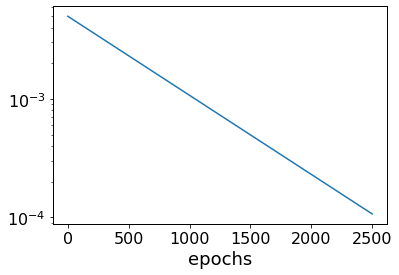

In [3]:
initial_learning_rate = 0.005
decay_rate = 0.95
decay_steps = 100
num_epochs = 2500
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ** (step / decay_steps)

xx = np.arange(num_epochs*3)
yy = decayed_learning_rate(xx)
plt.plot(xx/3, yy)
plt.xlabel('epochs')
plt.yscale('log')

In [4]:
# !ls -rlt ../outputs

In [5]:
# import extinction
# # Load the fiducial color law.
# av = 1.0
# Rv = 2.8
# wave = train_data['wavelengths']
# color_law = extinction.fitzpatrick99(
#             train_data['wavelengths'], av, Rv
#         )

# np.savetxt("../data/F99_colorlaw.txt", np.c_[wave, color_law])
                                            
# w, color_law_old, CL_deriv = np.loadtxt("../data/F99_colorlaw_old.txt", unpack=True)
# plt.plot(train_data['wavelengths'], color_law_old)
# plt.plot(train_data['wavelengths'], color_law)

# plt.figure()
# plt.plot(train_data['wavelengths'], color_law_old/color_law)



### Load in trained models and outputs

In [6]:
want_models = True

latent_dim = 3 
kfold = 0

# savefig = True 
savefig = False

file_string = 'layers256-128-32_test'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' 
# file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"
file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0" #_individuallatent" #_nosigmaweight_smallcov"

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0_longchain"
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"

param_file = '../outputs/params/AE_kfold{:d}_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
                                                                                      
# train_data_file  = '../data/train_data_kfold0.npy'
# test_data_file  = '../data/test_data_kfold0.npy'

# file_string = 'layers256-128-32_3stage_train_decorrelate_all'

# Load data
def load_data(file_path):
    return np.load(file_path, allow_pickle=True).item()

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00
params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False

if want_models:
    # Load in models, as well as the outputs above
    parser = argparse.ArgumentParser()
    parser.add_argument("--yaml_config", default='../config/posterior_analysis.yaml', type=str)
    parser.add_argument("--config", default='posterior', type=str)
    parser.add_argument("--print_params", default=True, action='store_true')

    args = parser.parse_args(args=[])

    params = YParams(os.path.abspath(args.yaml_config), args.config, print_params=True)            
    params['latent_dim'] = latent_dim

#     params = np.load(param_file, allow_pickle=True).item()['parameters']
    params['nlayers'] = 12
    params['nunit'] =  8

    pprint(vars(params))
    # Get PAE model"
    PAE = loader.PAE(params)

    istart = 2

    # get latent representations from encoder and flow                                                                       
    train_data['z_latent'] = PAE.encoder((train_data['spectra'], train_data['times'], train_data['mask'])).numpy()
    test_data['z_latent']  = PAE.encoder((test_data['spectra'], test_data['times'], test_data['mask'])).numpy()

    train_data['u_latent'] = PAE.flow.bijector.inverse(train_data['z_latent'][:, istart:]).numpy()
    test_data['u_latent']  = PAE.flow.bijector.inverse(test_data['z_latent'][:, istart:]).numpy()

    # get reconstructions
    train_data['spectra_ae'] = PAE.decoder((train_data['z_latent'], train_data['times'], train_data['mask'])).numpy()
    test_data['spectra_ae']  = PAE.decoder((test_data['z_latent'], test_data['times'], test_data['mask'])).numpy()


------------------ Configuration ------------------
nchains 25
find_MAP True
stop_ratio 0.0001
max_iterations 2500
max_line_search_iterations 50
tolerance 0.01
run_HMC True
ihmc True
num_burnin_steps 10000
num_samples 10000
num_leapfrog_steps 5
step_size 0.05
dtime_norm 1.0
target_accept_rate 0.651
seed 13579
batch_size 171
train_noise False
vary_mask False
lr 0.001
noise_scale 1.0
mask_vary_frac 0.2
rMAPini False
train_MAP True
train_amplitude True
train_dtime True
train_bias False
savedata True
PROJECT_DIR /global/cscratch1/sd/gstein/machine_learning/sn_project/suPAErnova/
FIG_DIR figures/
DATA_DIR data/
OUTPUT_DIR outputs/
MODEL_DIR outputs/tensorflow_models/
PARAM_DIR outputs/params/
LOG_DIR logs/
verbose True
train_data_file data/train_data_kfold0.npy
test_data_file data/test_data_kfold0.npy
kfold 0
colorlaw_file data/F99_colorlaw.txt
out_file_tail 3stage_train_decorrelate_all_seed0
posterior_file_tail 3stage_train_decorrelate_all_seed0
model_summary True
savefig False
savemodel T

In [11]:
test_data['names'] #== "SNPGC51271"

array(['SN2006dm', 'SN2009hi', 'SN2010dt', 'SNF20070712-003',
       'SNF20070727-016', 'LSQ13avx', 'PTF11mkx', 'SNF20061024-000',
       'SNF20070506-006', 'SNF20080510-005', 'PTF13anh',
       'SNF20070330-024', 'SNF20070429-000', 'LSQ12ekl', 'PTF11bgv',
       'PTF11qzq', 'SNF20071003-016', 'SNF20080919-001', 'SNhunt46',
       'SN2006ob', 'LSQ13vy', 'SNF20070810-004', 'PTF11pbp',
       'SNF20070417-002', 'SNF20070331-025', 'SNF20080810-001',
       'SNNGC2691', 'SNF20080806-002', 'PTF12izc', 'PTF12ena',
       'SNF20080918-002', 'LSQ12hjm', 'PTF12hwb', 'SN2005hc',
       'SNF20080731-000', 'LSQ12fhe', 'SNF20080610-000',
       'SNF20070818-001', 'SN2005bg', 'PTF09foz', 'SNF20061022-005',
       'SNF20070701-005', 'PTF10ndc', 'SNF20060621-012', 'SNNGC2370',
       'SN2007cq', 'SNNGC0927', 'SNF20070403-000', 'SNF20060512-002',
       'SNF20080926-009', 'SNF20070817-003', 'SNF20080614-010',
       'SNF20061030-010', 'SNF20080623-001', 'LSQ14cnm',
       'SNF20080913-031', 'SNNGC4076'

## Construct plotting functions for custom corner plots

In [129]:
import matplotlib.gridspec as gridspec
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap

# cmap = plt.cm.cividis
def plot_grid(data, labels=None, errs=None, 
              color_arr=None, color_label=None, color_symmetric=False,
              plot_density=False, plot_diagonal=False,
              xyminmax=None,
              figsize=(8,8), spacing=0.05, s=30, ms_mean=6, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False, include_mean=False, nbins=25, nbins_contour=15):
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    
    # colors = plt.cm.coolwarm_r(np.linspace(0.6, 1.0, 256))
    # colors[0:4, :3] = 1.
    # colors_1D = colors[int(0.8*colors.shape[0])]
    colors = cmap(np.linspace(0.0, 1.0, 256))
    colors_1D = cmap(0.8)

    
    # cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

    sigmas = np.array([1., 2.])#, 3.]) # sigmas
    colors_contour = plt.cm.coolwarm(np.linspace(0.6, 1.0, 256))
    # contour_colors = colors_contour[ np.linspace(0, colors_contour.shape[0]-1, sigmas.shape[0]).astype(int) ]
    contour_colors = np.zeros((len(sigmas), 4))
    contour_colors[:, -1] = np.linspace(0.2, 0.7, contour_colors.shape[0])

    nx = data.shape[1] - 1
    ny = data.shape[1] - 1
    istart = 1
    jstart = 1
    
    if plot_density:
        plot_diagonal=True
    if not plot_diagonal:
        istart = 0
        jstart = 0

    if color_arr is None:
        color_arr_plt = color_arr
    else:
        color_arr_plt = color_arr.copy()

    if color_symmetric:
        cminmax = min(np.abs(np.min(color_arr_plt)), np.abs(np.max(color_arr_plt)))
        color_arr_plt[color_arr_plt < -cminmax] = -cminmax
        color_arr_plt[color_arr_plt > cminmax] = cminmax

    if labels is None:
        labels = ['z_{:d}'.format(i) for i in range(data.shape[1])]
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=ny+jstart, nrows=nx+istart, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if cmap is None:
        cmap = plt.cm.viridis
       
    if plot_diagonal:
        for i in range(data.shape[1]):
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[i, i])
            
            ax.hist(data[:, jj], histtype='step', 
                    lw=2, 
                    bins=nbins, 
                    color=colors_1D)
            
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')
            
            ax.set_yticklabels([])
            ax.set_yticks([])
            if i == data.shape[1] - 1:
                ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i < data.shape[1] - 1:
                ax.set_xticklabels([])
                      
    for i in range(nx):
        for j in range(i, ny):
            
            ii = ny-j 
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[j+jstart, i])
            if color_arr_plt is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr_plt.min(), color_arr_plt.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels[ii])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels[jj])
            else:
                ax.set_xticklabels([])

            if not plot_density:
                if color_arr_plt is None:
                    if errs is None:
                        ax.scatter(data[:, jj], data[:, ii], s=s, alpha=alpha, rasterized=rasterized)
                    else:
                        ax.errorbar(data[:, jj], data[:, ii], xerr=errs[:, jj], yerr=errs[:, ii], marker='o', 
                                    ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                    rasterized=rasterized, ls='none')

                else:
                    if errs is None:
                        c = ax.scatter(data[:, jj], data[:, ii], s=s, c=color_arr_plt, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                        if include_mean:
                            ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                       ms=ms_mean, marker='o', markeredgecolor='k',
                                       color='w', lw=2, alpha=alpha)

                    else:
                        carr = (color_arr_plt-color_arr_plt.min())/(color_arr_plt.max()-color_arr_plt.min())
                        for ierr in range(data[:, jj].shape[0]):
                            ax.errorbar(data[ierr, jj], data[ierr, ii], xerr=errs[ierr, jj], yerr=errs[ierr, ii], markeredgecolor=markeredgecolor,
                                        color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                         lw=2)

            if plot_density:
                ax.hexbin(data[:, jj], data[:, ii], gridsize=nbins, cmap=cmap)#, norm=matplotlib.colors.LogNorm())
                # ax.contour(counts)#, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
                           # linewidths=3)
                H, xedges, yedges = np.histogram2d(data[:, jj], data[:, ii], bins=nbins_contour)#, bins=(xedges, yedges))

                H /= H.sum()

                n = 10000
                t = np.linspace(0, H.max(), n)
                integral = ((H >= t[:, None, None]) * H).sum(axis=(1,2))

                intervals = (1 - np.exp(-(sigmas)**2/2)) # CDF in 2D

                f = interpolate.interp1d(integral, t)
                t_contours = f(intervals[::-1])
                ax.contour(H.T, t_contours, 
                           extent=[data[:, jj].min(), data[:,jj].max(), data[:,ii].min(), data[:,ii].max()],
                          colors=contour_colors)
                if include_mean:
                        ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                    ms=ms_mean, marker='o', markeredgecolor='w',
                                    color='k', lw=2, alpha=alpha)
                        
            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
            # else:
            #     ax.set_ylim(data[:, ii].min(), data[:, ii].max() )
            #     ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                
            if j == ny-1:
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i == 0:
                xti = ax.get_yticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_yticklabels(xti)
                
    if color_arr_plt is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')
  

def plot_grid_one_vs_other(data1, data2, 
                           labels1=None, labels2=None, 
                           errs1=None, errs2=None, 
                           color_arr=None, color_label=None, xyminmax=None, color_symmetric=False,
              figsize=(8,8), spacing=0.05, s=30, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False):
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    nx = data1.shape[1]
    ny = data2.shape[1]
    print(nx, ny)
    
    if color_symmetric:
        # Assume redshifts
        cmin = 0.02
        cmax = 0.08
        color_arr[color_arr < cmin] = cmin
        color_arr[color_arr > cmax] = cmax

    if labels1 is None:
        labels1 = ['z1_{:d}'.format(i) for i in range(data1.shape[1])]
    if labels2 is None:
        labels2 = ['z2_{:d}'.format(i) for i in range(data2.shape[1])]
                
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=nx, nrows=ny, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if cmap is None:
        cmap = plt.cm.viridis
       
    for i in range(nx):
        for j in range(ny):
            ax = fig.add_subplot(gs[j, i])
            if color_arr is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr.min(), color_arr.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels2[j])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels1[i])
            else:
                ax.set_xticklabels([])

            if color_arr is None:
                if errs1 is None:
                    ax.scatter(data1[:, i], data2[:, j], s=s, alpha=alpha, rasterized=rasterized)
                else:
                    ax.errorbar(data1[:, i], data2[:, j], xerr=errs1[:, i], yerr=errs2[:, j], marker='o', 
                                ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none')

            else:
                if errs1 is None:
                    c = ax.scatter(data1[:, i], data2[:, j], s=s, c=color_arr, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                else:
                    carr = (color_arr-color_arr.min())/(color_arr.max()-color_arr.min())
                    # carr = color_arr
                    for ierr in range(data1[:, i].shape[0]):
                        ax.errorbar(data1[ierr, i], data2[ierr, j], xerr=errs1[ierr, i], yerr=errs2[ierr, j], markeredgecolor=markeredgecolor,
                                    color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                     lw=2)


            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
                
            if j == ny-1:
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=40)

            if i == 0:
                xti = ax.get_yticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_yticklabels(xti)
                                
            # if j == ny-1:
            #     ax.set_xticklabels(ax.get_xticks(), rotation=-15)
                
    if color_arr is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')

# 

# Corner Plots

(50000, 57, 6)
SN2010dt
2 (50000, 57, 6)
0.052895000000000005
-0.069331355 0.03501355
[ 0.00256037 -0.06933136 -0.02809474 -0.06352179 -0.06279175  0.04510436] [0.00217306 0.03501355 0.03118138 0.00669494 0.01170846 0.0093925 ]


<ipython-input-7-0f8c33f2395b>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
<ipython-input-7-0f8c33f2395b>:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-7-0f8c33f2395b>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)


SN2005bg
38 (50000, 57, 6)
0.022823
-0.18199146 0.044967137
[ 0.0145142  -0.18199146 -0.07901135 -0.09333356  0.24711147  0.10151438] [0.00527408 0.04496714 0.04865156 0.008648   0.01783828 0.01317306]


<ipython-input-7-0f8c33f2395b>:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
<ipython-input-7-0f8c33f2395b>:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-7-0f8c33f2395b>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)


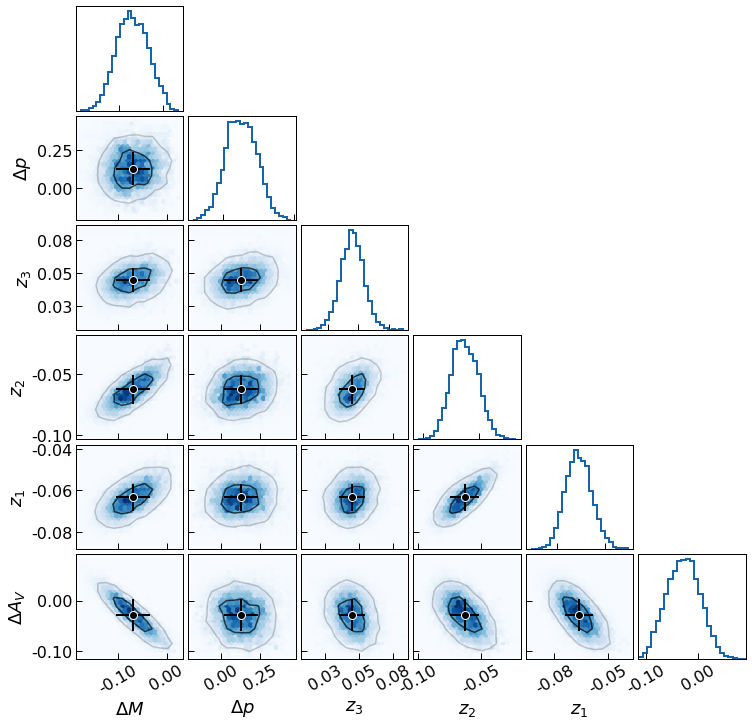

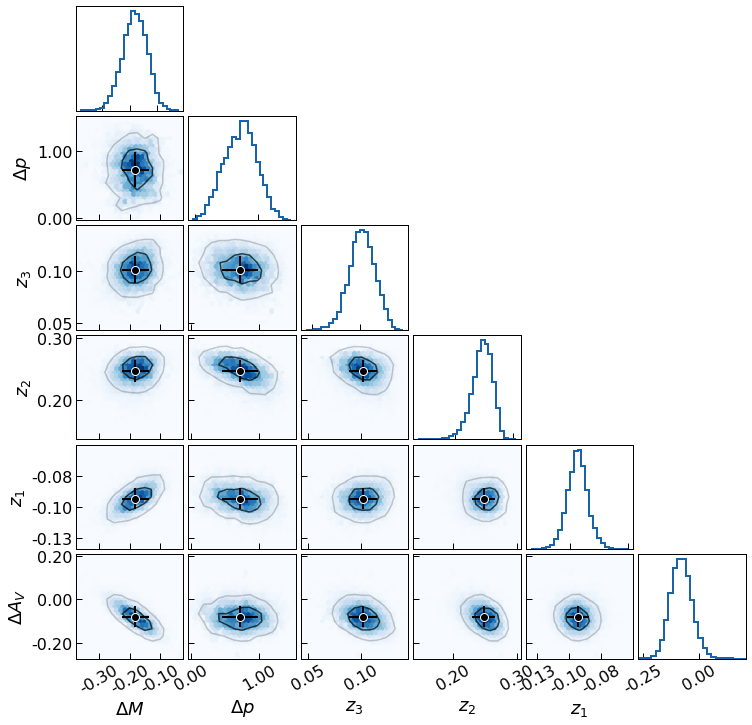

In [9]:
# savefig = True
savefig = False

labels = ['$\Delta p$', '$\Delta M$', '$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]
print(test_data['z_samples'].shape)

z_use = test_data['z_latent'].copy()
z_use[:,0]*=50

# dm = get_train_mask(train_data, params)
# inds = np.argsort(test_data['redshift'])[::-1]
inds = np.arange(test_data['redshift'].shape[0])

inds = [2, 38] #43]#2,24]

# plot_grid(z_use, labels=labels)
for iplt in range(len(inds)):
    print(test_data['names'][inds[iplt]])
    print(inds[iplt], test_data['z_samples'].shape)
    print(test_data['redshift'][inds[iplt]])
    print(test_data['amplitude_mcmc'][inds[iplt]], test_data['amplitude_mcmc_err'][inds[iplt]])
    print(np.mean(test_data['z_samples'][:, inds[iplt], :], axis=0), np.std(test_data['z_samples'][:, inds[iplt], :], axis=0))
    
    zplt = test_data['z_samples'][:, inds[iplt], :].copy()
    zplt[:, 0] *= 50
    
    labelsi = np.roll(labels, -1)
    zplt  = np.roll(zplt, -1, axis=1)

    plot_grid(zplt, 
              labels=labelsi, 
              figsize=(12,12),  s=10, include_mean=True, ms_mean=8,
              plot_density=True, savefig=savefig, filename='../figures/HMC_chains_density_{:03d}_latentdim{:02d}.pdf'.format(inds[iplt], latent_dim),
             cmap=plt.cm.Blues)


['$\\Delta p$', '$\\Delta M$', '$\\Delta A_V$', '$z_1$', '$z_2$', '$z_3$']


<ipython-input-129-0f8c33f2395b>:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-129-0f8c33f2395b>:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)


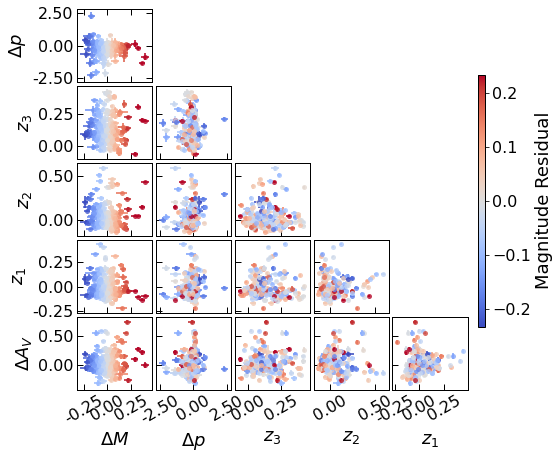

In [132]:
# savefig = False
savefig = True

filename = '../figures/grid_PAE_{:d}Dlatent.pdf'.format(latent_dim)

data = {}
data['z_latent_mcmc'] = np.concatenate((train_data['z_latent_mcmc'], test_data['z_latent_mcmc']), axis=0)
data['z_latent_mcmc_err'] = np.concatenate((train_data['z_latent_mcmc_err'], test_data['z_latent_mcmc_err']), axis=0)

data['z_latent_mcmc'][:,0] *= 50 #days
data['z_latent_mcmc_err'][:,0]  *= 50 #days

data['redshift'] = np.concatenate((train_data['redshift'], test_data['redshift']), axis=0)
data['times_orig'] = np.concatenate((train_data['times_orig'], test_data['times_orig']), axis=0)

labels = ['$\Delta p$', '$\Delta M$', '$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]
print(labels)

dm = get_train_mask(data, params)

arr_use = data['z_latent_mcmc'][dm]
err_use = data['z_latent_mcmc_err'][dm]

labels = np.roll(labels, -1)
arr_use = np.roll(arr_use, -1, axis=1)
err_use = np.roll(err_use, -1, axis=1)

plot_grid(arr_use, errs=err_use, 
          labels=labels, savefig=savefig, filename=filename,
          color_arr=arr_use[:, 0], color_label='Magnitude Residual', color_symmetric=True,
         figsize=(7,7), cmap=plt.cm.coolwarm, s=5, alpha=0.8, markeredgecolor='none') 



[-2.6104446e-05  2.3065642e-03  7.6667592e-03 -5.9830737e-03
  5.7828892e-02  1.3979666e-01]


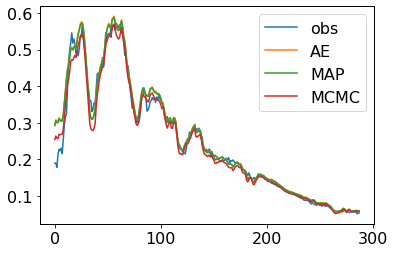

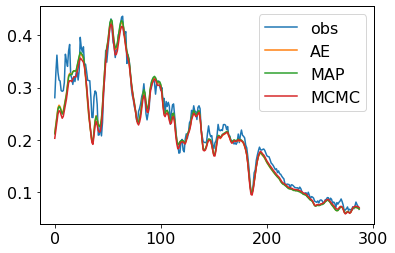

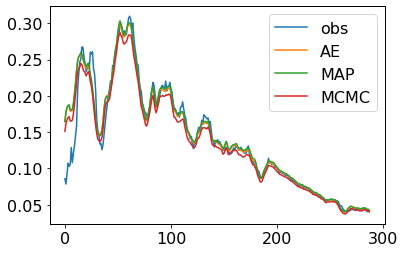

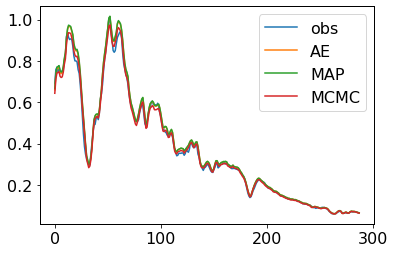

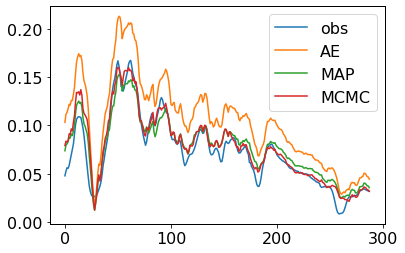

In [11]:
# Simple spectra plots to make sure its doing what I think
for iplt in range(5):
    plt.figure()
    plt.plot(train_data['spectra'][iplt,0], label='obs')
    plt.plot(train_data['spectra_ae'][iplt,0], label='AE')
    plt.plot(train_data['spectra_map'][iplt,0], label='MAP')
    plt.plot(train_data['spectra_mcmc'][iplt,0], label='MCMC')#*10**(-0.4*-0.34430096))

    plt.legend()
    
print(train_data['z_latent'].mean(0))

source:
  class      : SALT2Source
  name       : 'salt2'
  version    : 2.4
  phases     : [-20, .., 50] days
  wavelengths: [2000, .., 9200] Angstroms
parameters:
  z  = 0.05
  t0 = 0.0
  x0 = 1.0
  x1 = 0.0
  c  = 0.0
[3302. 4102.]
(10,) (10, 288) (10,)
[4102. 5100.]
(10,) (10, 288) (10,)
[5200. 6289.]
(10,) (10, 288) (10,)
[6289. 7607.]
(10,) (10, 288) (10,)
[7607. 8598.]
(10,) (10, 288) (10,)


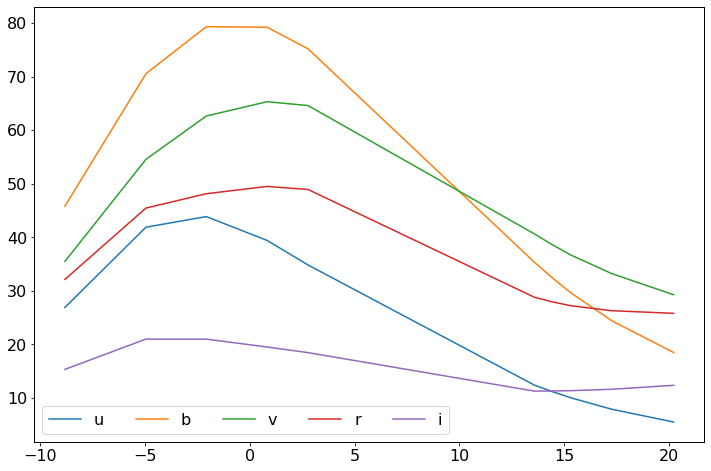

In [15]:
# train_data['luminosity_distance']
import sncosmo

def obs_from_rf_factor(z): #, cosmo=COSMO):
    return z

    # factor = 1/1e15
    # factor = factor*(1.05)/(1+z)
    # dlref = cosmo.luminosity_distance(0.05).value
    # dl = cosmo.luminosity_distance(z).value
    # factor = factor * dlref**2 / dl**2
    # return factor

def lc_from_spectra(band, fluxes, z, phases, spec_ids, flux_errs=None):
    lc = []
    for i, (phase, spec_id) in enumerate(zip(phases, spec_ids)):
        fac = obs_from_rf_factor(z)
        flux = fluxes[spec_id] * fac
        if flux_errs is not None:
            fluxerr = flux_errs[spec_id] * fac
        else:
            fluxerr = None
        spec = sncosmo.Spectrum(wave=obs_wave*(1+z), flux=flux, fluxerr=fluxerr, time=phase)
        lc.append(spec.bandfluxcov(band))
    return lc

dm = 0.
av = 0.
xi1 = 0.
xi2 = 0.
xi3 = 0.
z = 0.05

filter_edges = {'u': np.array([3302., 4102.]),
                'b': np.array([4102., 5100.]),
                'v': np.array([5200., 6289.]),
                'r': np.array([6289., 7607.]),
                'i': np.array([7607., 8598.])}

model = sncosmo.Model(source='salt2')
model.set(t0=0, z=z)
model.wavelengths = train_data['wavelengths']
delta_dm = -2.5*np.log10(obs_from_rf_factor(z))
model_phases = np.linspace(-10, 40, 100)

wavelength = [4000., 5000.]
transmission = [1., 1.]

print(model)
iplt = 0
nspec = 10

plt.figure(figsize=(12,8))
for band_name, band_edges in filter_edges.items():
    print(band_edges)
    band = sncosmo.Bandpass(band_edges, band_edges*0+1, name=band_name)
    sncosmo.register(band, force=True)
    
        
    phases = train_data['times_orig'][iplt, :nspec, 0]
    model.flux = train_data['spectra'][iplt, :nspec]
    model.phases = phases

    bandflux = model.bandflux(band_name, phases)
    print(phases.shape, model.flux.shape, bandflux.shape)
    plt.plot(phases, bandflux, label=band_name)
    
plt.legend(ncol=5)

[[0.         0.03225806 0.06451613 0.09677419 0.12903226 0.16129032
  0.19354839 0.22580645 0.25806452 0.29032258 0.32258065 0.35483871
  0.38709677 0.41935484 0.4516129  0.48387097 0.51612903 0.5483871
  0.58064516 0.61290323 0.64516129 0.67741935 0.70967742 0.74193548
  0.77419355 0.80645161 0.83870968 0.87096774 0.90322581 0.93548387
  0.96774194 1.        ]] [[-10.          -8.38709677  -6.77419355  -5.16129032  -3.5483871
   -1.93548387  -0.32258065   1.29032258   2.90322581   4.51612903
    6.12903226   7.74193548   9.35483871  10.96774194  12.58064516
   14.19354839  15.80645161  17.41935484  19.03225806  20.64516129
   22.25806452  23.87096774  25.48387097  27.09677419  28.70967742
   30.32258065  31.93548387  33.5483871   35.16129032  36.77419355
   38.38709677  40.        ]]


No handles with labels found to put in legend.


-2.7863825718709667 1.1525480756630035


No handles with labels found to put in legend.


-2.7677859279740735 1.1263485027149922


No handles with labels found to put in legend.


-2.749129663984393 1.120814046756993


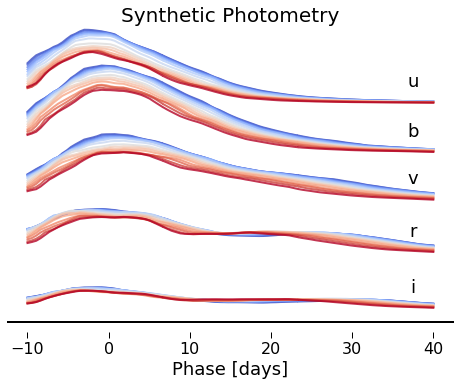

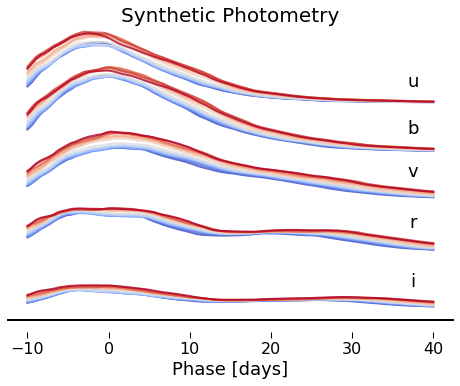

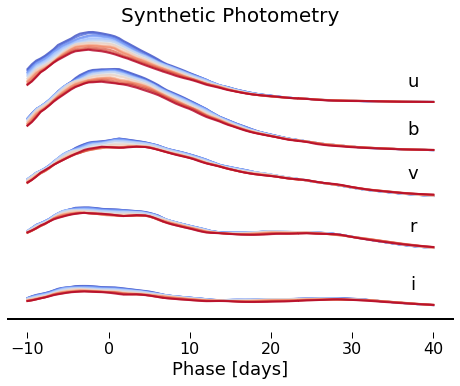

In [109]:
import matplotlib.patheffects as pe
import sncosmo

# Plot SN while varying z latent params to see effects

savefig = True
# savefig = False

figdir = '../figures/'

# Set up figure aesthetics
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
labels = ['$\Delta t$', '$\Delta M$', '$\Delta A_V$'] + latent


alpha=0.8
dim_plus_2 = 1 #2
lw = 2
# Get observation times and bin latent params
dm = get_train_mask(train_data, params)
z_latent_use = train_data['z_latent_mcmc']

nsamples = 15
percentiles = np.linspace(10, 90, nsamples)
z_bin_edge = np.percentile(z_latent_use, percentiles, axis=0)
nsamples = z_bin_edge.shape[0]

Asamp = np.linspace(0.5, 1.5, nsamples)

nshow = 6 #3
times_lin = np.linspace(0,1, params['n_timestep'])[None, ...]
mask_     = np.ones((1, params['n_timestep']))

times_orig_lin = times_lin*50 - 10

print(times_lin, times_orig_lin)

cmaps = [plt.cm.coolwarm] * 5
# cmaps = [plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds]

colors = [cmap(np.linspace(0.0,1,nsamples)) for cmap in cmaps]

z_median = np.median(z_latent_use[dm], axis=0)[None, ...]

# get u array of zeros
nbands = 5
filter_edges = {'u': np.array([3302., 4102.]),
                'b': np.array([4102., 5100.]),
                'v': np.array([5200., 6289.]),
                'r': np.array([6289., 7607.]),
                'i': np.array([7607., 8598.])}

ntime_splits = 3

for dim in range(3, z_bin_edge.shape[1]):

    aoffsets = [0.75, 1.5]
    zsamp = z_bin_edge[:, dim]
        
    title = 'Varying {:s}'.format(labels[dim])

    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))#, gridspec_kw={'height_ratios': [3, 1]})

    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1.)

    ax1.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
    ax1.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')

    ymin = 100
    ymax = -100

    # get origin value
    z_ = z_median.copy()

    for sample in range(z_bin_edge.shape[0]):

        # set u values along slice
        z_ = z_median.copy()
        z_[:, dim:dim+dim_plus_2] = zsamp[sample]

        bandfluxes = np.zeros((nbands, params['n_timestep']*ntime_splits))
        phases = []

        isamp = 0
        for itime_mult in range(1, ntime_splits+1):
            # make time difference smaller by factor of this in order to more smoothly interpolate
            times_lin_use = times_lin / ntime_splits + (itime_mult-1.)/ntime_splits
            phases.extend(list(times_lin_use[0]))
            # times_lin_use = np.clip(times_lin_use, 1./50, 1-1./50)

            xpred_i = np.array(PAE.decoder((z_, times_lin_use, mask_))[0]) #/ (10**(-0.4* (CL*np.exp(z_[:, -1]) + z_[:, 0])))

            for ispec in range(params['n_timestep']):

                spec = sncosmo.Spectrum(wave=train_data['wavelengths'], flux=xpred_i[ispec])
                for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
                    band = sncosmo.Bandpass(band_edges, band_edges*0+1, name=band_name)
                    sncosmo.register(band, force=True)

                    bandflux = spec.bandflux(band_name)/1.e14
                    
                    bandfluxes[iband, isamp] = bandflux
                
                    
                isamp += 1

        for iband in range(bandfluxes.shape[0]):
            ax1.plot(np.array(phases)*50-10, bandfluxes[iband]-iband/3*2, c=colors[iband][sample], lw=lw, alpha=alpha)
            
    for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
        ax1.text(37.5,  bandfluxes[iband, -1]-iband/3*2+0.2, band_name, ha='center')
#         for i in range(nshow):
#             labp = None
#             labo = None
#             if i==0:
#                 labs = 'Encoder'
#                 labp = 'MAP'
#             if plttype == 'normal':
#                 xpi = xpred_i[i] + offset[i]
                
                
#         ax1.plot(train_data['wavelengths'], xpi, '-',
#                  c=colors[sample], lw=lw, alpha=alpha,
#                 path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
#                 )#, label=labp)

  
    ax1.set_ylabel('Normalized Flux')
    ax1.set_xlabel('Phase [days]')

    ymax = offset[0] + aoffsets[iplt] 
    ymin = offset[nshow-1]
    # ax1.set_title(title, fontsize=20, y=0.97, pad=0)
    ax1.set_title("Synthetic Photometry", fontsize=20, y=0.97, pad=0)


    
    ax1.set_frame_on(False)
    ax1.get_xaxis().tick_bottom()
    ax1.axes.get_yaxis().set_visible(False)
    xmin, xmax = ax1.get_xaxis().get_view_interval()
    ymin, ymax = ax1.get_yaxis().get_view_interval()
    print(ymin,ymax)
    ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    ax1.legend(loc='upper right', frameon=False, ncol=3)
    ax1.set_ylim(-3., 1.2)


#     ax1.axis('off')

#     ax2.set_yscale('log')
    # ax1.set_xlim(train_data['wavelengths'][0], train_data['wavelengths'][-1])
#     plt.subplots_adjust(hspace=0.025)

    if savefig: 
        fname = 'vary_zlatent_lc_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)
        if dim_plus_2 > 1:
            fname = 'vary_zlatent_lc_dimplus2_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)

        plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')



Text(0, 0.5, 'PAE $\\Delta p$')

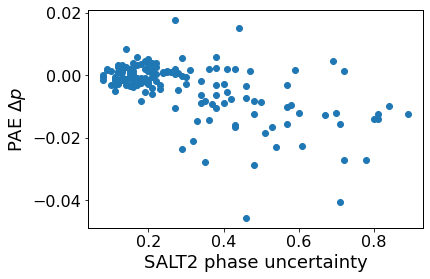

In [13]:
# Correlation of SALT2 time uncertainty and PAE \Delta p parameter
dm = get_train_mask(train_data, params)

plt.scatter(train_data['dphase'][dm], train_data['z_latent_mcmc'][dm, 0])
plt.xlabel("SALT2 phase uncertainty")
plt.ylabel("PAE $\Delta p$")

# Plot spectra and model fits

In [100]:
from scipy.optimize import minimize

def frac_to_mag(fractional_difference):
    """Convert a fractional difference to a difference in magnitude
    Because this transformation is asymmetric for larger fractional changes, we
    take the average of positive and negative differences.
    
    Copied from https://github.com/snfactory/twins_embedding
    """
    pos_mag = 2.5 * np.log10(1. + fractional_difference)
    neg_mag = 2.5 * np.log10(1. - fractional_difference)
    mag_diff = (pos_mag - neg_mag) / 2.0
    return mag_diff

# Fit for the intrinsic dispersion
def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion):
    variance = measurement_uncertainties**2 + intrinsic_dispersion**2
    return 1 / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

def negative_log_likelihood(x):
    likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
    return -np.sum(np.log(likelihoods))

def compute_intrinsic_dispersion(spec_true, spec_pred, sigma,  weighted=False, outlier_cut=98):
    """Calculate std of a true and reconstructed spectra                                     
                                                                                                                    
    Parameters                                                                                                      
    ----------                                                                                                      
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                
       measured spectra                                                                                             
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                
       model spectra                                                                                                
    sigma: array (N_sn, n_timesamples, data_dim)                                                                    
       measurement uncertainty                                                                                      
    time: array (N_sn, n_timesamples)                                                                               
       observation time                                                                                             
    """
   
    residuals = np.abs(spec_pred.copy() - spec_true.copy())
    
    # sometimes there are huge outliers,                                                                            
    # so set errors larger than some percentile to the value corresponding to that percentile        
    intrinsic_dispersion = np.zeros(residuals.shape[0])
    
    for wbin in range(residuals.shape[0]):
        measurement_uncertainty = sigma[wbin]
        residual = residuals[wbin]

        # Fit for the intrinsic dispersion
        def gaussian_likelihood(residual, measurement_uncertainty, intrinsic_dispersion_i):
            variance = measurement_uncertainty**2 + intrinsic_dispersion_i**2
            return 1. / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

        def negative_log_likelihood(x):
            likelihoods = gaussian_likelihood(residual, measurement_uncertainty, x[0])
            likelihoods += 1e-9
            return -np.sum(np.log(likelihoods))
        
        if np.abs(residual) > measurement_uncertainty:
            initial_guess = np.sqrt(residual**2 - measurement_uncertainty**2)

            res = minimize(negative_log_likelihood, [initial_guess])
            itrial = 0
            while res.success is False and itrial < 10:
                xini = np.abs(np.random.normal(initial_guess, measurement_uncertainty, 1))
                res = minimize(negative_log_likelihood, xini)
                itrial += 1

            intrinsic_dispersion[wbin] = np.abs(res.x[0])
        else:
            intrinsic_dispersion[wbin] = 0
    
    return  intrinsic_dispersion


def compute_intrinsic_dispersion_vs_time(spec_true, spec_pred, sigma, time, weighted=False, outlier_cut=98, ntbins=10):
    """Calculate std of true and reconstructed spectra as a function of time                                        
                                                                                                                    
    Parameters                                                                                                      
    ----------                                                                                                      
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                
       measured spectra                                                                                             
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                
       model spectra                                                                                                
    sigma: array (N_sn, n_timesamples, data_dim)                                                                    
       measurement uncertainty                                                                                      
    time: array (N_sn, n_timesamples)                                                                               
       observation time                                                                                             
    """
    dm = spec_true != -1.

    t_bin_edge = np.linspace(0, 1, ntbins+1)
    t_bin_cent = (t_bin_edge[:-1] + t_bin_edge[1:])/2
    # print(t_bin_edge *50 -10)
    s0 = spec_true[dm]
    s1 = spec_pred[dm]

    s0[s0 < 0] = 0
    s1[s1 < 0] = 0
    
    
#     residual = -2.5*np.log10(s1/s0)
#     sig = 2.5*np.log10(np.abs(sigma[dm])/s0)
    
    residual = spec_pred[dm].copy() - spec_true[dm].copy()
    sig = sigma[dm].copy()

    t   = time[dm[:,:,0]][:,0]
    
    # print(sig.min(), np.abs(residual).min(), np.abs(residual/sig).min())
    residual = np.reshape(residual, (-1, 288))
    sig = np.reshape(sig, (-1, 288))
    s0 = np.reshape(s0, (-1, 288))
    s1 = np.reshape(s1, (-1, 288))

    # print(sig.shape)
    # sometimes there are huge outliers,                                                                            
    # so set errors larger than some percentile to the value corresponding to that percentile        
    intrinsic_dispersion = np.zeros((len(t_bin_cent), sig.shape[1]))
    measurement_dispersion = np.zeros((len(t_bin_cent), sig.shape[1]))
    mean_spectra = np.zeros((len(t_bin_cent), sig.shape[1]))

    bins = np.digitize(t, t_bin_edge) - 1
#     for tbin in range(1):
    for tbin in np.unique(bins):
        dm   = bins == tbin
#         print(sig[dm].min(0), sig[dm].max(0))
#         print(residual[dm].min(0), residual[dm].max(0))
        mean_spectra[tbin] = s0[dm].mean(0)

        for wbin in range(sig.shape[1]):
            measurement_uncertainties = sig[dm][:, wbin]
            residuals = residual[dm][:, wbin]
            
            # Fit for the intrinsic dispersion
            def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion_i):
                variance = measurement_uncertainties**2 + intrinsic_dispersion_i**2
                return 1. / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

            def negative_log_likelihood(x):
                likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
                likelihoods += 1e-9
                return -np.sum(np.log(likelihoods))

            mean_resid = np.mean(np.abs(residuals))
#             print(mean_resid)
            mean_meas = np.mean(measurement_uncertainties)
            mean_resid = np.sqrt(np.sum(residuals**2)/residuals.shape[0])
#             print(mean_resid)
#             initial_guess = np.sqrt(mean_resid**2 - mean_meas**2)

            if mean_meas < mean_resid:
                initial_guess = np.sqrt(mean_resid**2 - mean_meas**2)
            else: 
#                 print(mean_resid**2 - mean_meas**2)
                initial_guess = 0.001
    
            res = minimize(negative_log_likelihood, [initial_guess])
            itrial = 0
            while res.success is False and itrial < 2500:
                xini = np.abs(np.random.normal(initial_guess, np.mean(measurement_uncertainties), 1))
                res = minimize(negative_log_likelihood, xini)
                itrial += 1
            intrinsic_dispersion[tbin, wbin] = np.abs(res.x[0])
            measurement_dispersion[tbin, wbin] = np.mean(measurement_uncertainties)

    return t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion


5.890816e-07 24.81813
(57, 32, 1)
inds shape  (57,)
102
Nspectra  11


<ipython-input-30-25ba85382bc3>:303: RuntimeWarning: divide by zero encountered in true_divide
  sig1 = x_1[i]/x_obs[i]
<ipython-input-30-25ba85382bc3>:304: RuntimeWarning: divide by zero encountered in true_divide
  sig2 = x_2[i]/x_obs[i]
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


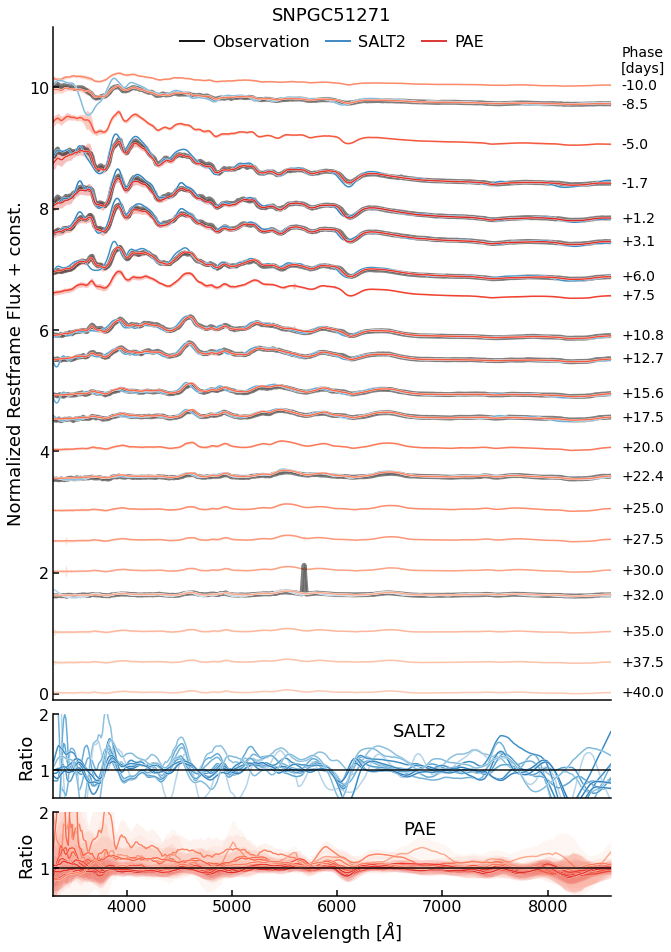

In [30]:
import suPAErnova.utils.calculations as calculations
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from scipy.signal import savgol_filter

ncolor = 256
neg_frac = 0.2 # time ranges from -10 to 40

colors1_salt = plt.cm.Blues(np.linspace(0.4, 0.7, int(ncolor*neg_frac)))
colors2_salt = plt.cm.Blues_r(np.linspace(0.3, 0.8, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors_salt = np.vstack((colors1_salt, colors2_salt))

colors1_pae = plt.cm.Reds(np.linspace(0.4, 0.7, int(ncolor*neg_frac)))
colors2_pae = plt.cm.Reds_r(np.linspace(0.3, 0.8, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors_pae = np.vstack((colors1_pae, colors2_pae))

cmap_salt = LinearSegmentedColormap.from_list('my_colormap', colors_salt)
cmap_pae = LinearSegmentedColormap.from_list('my_colormap', colors_pae)

def plot_spectra_map(data, spec1='salt2',spec2='ae', nshow_interp=26, figsize=(10, 16),
                     lwt=5., lw=1.5, lwpe=2, alpha=1.0, alpha_obs=0.5, alpha_fill=0.3, smooth_bins=7,
                     ispec=0, train=True, savefig=False, tstr='train', relative_error=False):
    
    # Set up plot and aesthetics
    title = data['names'][ispec]
    # Set plot aesthetics                                                                                                 
    aoffsets = [0.4, 0.15, 7]

    cmap = plt.cm.coolwarm
    colors = cmap(np.linspace(0, 1, 256))

    min_sep_interp = 1.5 # minimum seperation of interpolated model and true data, in days
    # c0  = 'C3'
    # c1  = 'C0'
    c0  = colors[int(0.9*len(colors))]
    c1  = colors[int(0.1*len(colors))]    
    
    ### Get data (non-masked spectra)
    spec1 = spec1.upper()
    spec2 = spec2.upper()
    dm = data['mask'][ispec, :, 0] != 0
    x_obs = data['spectra'][ispec, dm].copy()
    
    if spec1=='SALT2':
        x_1 = data['spectra_salt'][ispec, dm].copy()
    if spec1=='AE':
        x_1 = data['spectra_ae'][ispec, dm].copy()
    if spec1=='MAP':
        x_1 = data['spectra_map'][ispec, dm].copy()

    if spec2=='SALT2':
        x_2 = data['spectra_salt'][ispec, dm].copy()
    if spec2=='AE':
        x_2 = data['spectra_ae'][ispec, dm].copy()
    if spec2=='MAP':
        x_2 = data['spectra_map'][ispec, dm].copy()
    if spec2=='PAE':
        x_2 = data['spectra_mcmc'][ispec, dm].copy()

    sigma  = data['sigma'][ispec, dm].copy()
    times_orig  = data['times_orig'][ispec, dm].copy()
    times  = data['times'][ispec, dm].copy()

    wavelengths = data['wavelengths']
    red = data['redshift'][ispec]

    n_spectra = x_obs.shape[0]
    print("Nspectra ", n_spectra)
    
    # get reconstruction uncertainty
    if spec1!="SALT": 
        if spec2=="MAP":
            tuse = times + data['dtime_map'][ispec]
        elif spec2=="PAE":
            tuse = times + data['dtime_mcmc'][ispec]
        else:
            tuse = times
            
        sigma1 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=data['sigma_ae_time'])) # fill_value='extrapolate')   

    if spec2!="SALT": 
        if spec2=="MAP":
            tuse = times + data['dtime_map'][ispec]
        elif spec2=="PAE":
            tuse = times + data['dtime_mcmc'][ispec]
        else:
            tuse = times
            
        sigma2 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=data['sigma_ae_time'])) # fill_value='extrapolate')   


    # Turn off axis lines
#         ax1.set_frame_on(False)
#         ax1.get_xaxis().tick_bottom()
#         ax1.axes.get_yaxis().set_visible(False)
#         xmin, xmax = ax1.get_xaxis().get_view_interval()
#         ymin, ymax = ax1.get_yaxis().get_view_interval()
#         ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    # set constant offset scale
    #         offset = np.arange(len(times)) * -1 * aoffsets[iplt]
    wave_txt = wavelengths[-1]+100
    
    fontsize = 14
    
    offset_scale = 10
    
    offset = -times * offset_scale + offset_scale

    phase_text_loc = offset_scale+0.2
    
    ymin = -0.1
    ymax = offset_scale + 1.0
    # Plot spectra 1 by 1
    toffset_min = 0.3
  
    toffset_prev = 0.0

    ind_tmax = np.argmin(times_orig[:n_spectra])
    
    
    # Get interpolated model predictions at specified times
    # First get spectra from latent variables at linear spaced times between -10 and 40
    times_interp = np.zeros((1, params['n_timestep'])).astype(np.float32) 
    times_interp[:, :nshow_interp] = np.linspace(0, 1, nshow_interp)
    mask_interp    = np.ones((1, params['n_timestep']))
    mask_interp[:, nshow_interp:] = 0
    offset_interp = -times_interp * offset_scale + offset_scale
    
    times_orig_interp = times_interp*50 - 10
    # times_interp[0,0] += 1./50
    # times_interp[0, nshow_interp-1] -= 1./50

    spectra_interp = PAE.decoder((data['z_latent_mcmc'][ispec:ispec+1], times_interp, mask_interp))[0] 

    dm = mask_interp[0] == 1
    dm_time = [np.min(np.abs(times_orig[:, 0] - i)) > min_sep_interp for i in times_orig_interp[0]] # remove closer than this to observed spectra
    dm = dm & dm_time

    spectra_interp = spectra_interp[dm]
    times_interp = times_interp[0, dm]
    times_orig_interp = times_orig_interp[0, dm]
    offset_interp = offset_interp[0, dm]

    sigma_interp = tf.transpose(
        tfp.math.interp_regular_1d_grid(
            x=tf.transpose(times_interp),
            x_ref_min=ae_noise_t_bin_cent[0],
            x_ref_max=ae_noise_t_bin_cent[-1],
            y_ref=data['sigma_ae_time'],
        ),
    ) # fill_value='extrapolate')   

    fig, axs = plt.subplots(
        nrows=3, ncols=1, figsize=figsize,
        gridspec_kw={'height_ratios': [8, 1, 1]},
    )                                  
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for ax in axs:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.5)

        ax.tick_params('both', length=6, width=1.5, which='major', color='k',direction='in')
        ax.tick_params('both', length=3, width=1.5, which='minor', color='k',direction='in')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.set_xlim(wavelengths[0], wavelengths[-1])

    axs[0].get_xaxis().set_ticks([])
    axs[1].get_xaxis().set_ticks([])

    axs[0].set_ylabel('Normalized Restframe Flux + const.') 
    axs[1].set_ylabel('Ratio')
    axs[2].set_ylabel('Ratio')
    axs[2].set_xlabel('Wavelength [$\AA$]')

    axs[0].set_title(title, fontsize=18)   
    
    # Plot interpolated model spectra
    for i in range(spectra_interp.shape[0]):
        c0 = cmap_pae(times_interp[i])

        xi = spectra_interp[i] + offset_interp[i]
        axs[0].fill_between(
            wavelengths,
            xi - spectra_interp[i]*sigma_interp[i],  
            xi + spectra_interp[i]*sigma_interp[i],
            color=c0, alpha=alpha_fill, lw=0)
           

        axs[0].plot(wavelengths, spectra_interp[i] + offset_interp[i], '-', c=c0, lw=lw, alpha=alpha)#,

        phase_label = f"+{times_orig_interp[i]:.1f}" if times_orig_interp[i] > 0 else f"{times_orig_interp[i]:.1f}"
        axs[0].text(wave_txt, offset_interp[i]+(xi[-1]-offset_interp[i]), phase_label, fontsize=fontsize, ha='left', va='center')

    # Plot observations and matching models
           
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= 'k', alpha=0.9, label="Observation")
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= cmap_salt(0.2), alpha=0.9, label="SALT2")
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= cmap_pae(0.2), alpha=0.9, label="PAE")

    for i in range(n_spectra):
        
        if i > 0 and abs(times_orig[i][0]-times_orig[i-1][0]) < 0.5:
            # Don't plot spectra that are on top of each other
            continue
        c1 = cmap_salt(times[i][0])
        c0 = cmap_pae(times[i][0])
        
        labp = None
        labs = None
        labo = None
        ls= '-'

        toffset_i = offset[i]
        dt_add = 0
        if np.abs(toffset_i - toffset_prev) < toffset_min and i >0:
            dt_add = np.abs(toffset_i - toffset_prev)-toffset_min


        xi = x_obs[i] + offset[i]
        x1i = x_1[i] + offset[i]
        x2i = x_2[i] + offset[i]

        #### Plot top panel (spectra)
        axs[0].plot(wavelengths, xi, '-', c='k', lw=lwt, alpha=alpha_obs, label=labo)#colors[i])                       
        axs[0].fill_between(wavelengths, xi-sigma[i],  xi+sigma[i], color='gray', alpha=alpha_fill, lw=1)

        if spec1!="SALT2": 
            if relative_error:
                axs[0].fill_between(wavelengths, x1i-x_1[i]*sigma1[i],  x1i+x_2[i]*sigma1[i], color=c1, alpha=alpha_fill, lw=0)
            else:
                axs[0].fill_between(wavelengths, x1i-sigma1[i],  x1i+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

        if spec2!="SALT2": 
            if relative_error:
                axs[0].fill_between(wavelengths, x2i-x_2[i]*sigma2[i],  x2i+x_2[i]*sigma2[i], color=c0, alpha=alpha_fill, lw=0)
            else:
                axs[0].fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

        axs[0].plot(wavelengths, x1i, '-', c=c1, lw=lw, alpha=alpha, label=labs,
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])
        axs[0].plot(wavelengths, x2i, ls=ls, c=c0, lw=lw, alpha=alpha, label=labp,
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])

        #### Plot bottom ratio panel
        # axs[1].plot(wavelengths, xi*0+1, '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])                       
        # axs[1].fill_between(wavelengths, (x_obs[i]-sigma[i])/x_obs[i],  (x_obs[i]+sigma[i])/x_obs[i], color='gray', alpha=0.8, lw=1)

        if spec1!="SALT2": 
            if relative_error:
                axs[1].fill_between(
                    wavelengths,
                    (x_1[i]-x_1[i]*sigma1[i])/x_obs[i],
                    (x_1[i]+x_1[i]*sigma1[i])/x_obs[i],
                    color=c1,
                    alpha=alpha_fill,
                    lw=0,
                    zorder=-abs(ind_tmax - i),
                )
            else:
                axs[1].fill_between(wavelengths, x1i-sigma1[i],  x1i+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

        if spec2!="SALT2": 
            l = (x_2[i]+x_2[i]*sigma1[i])/x_obs[i]
            u = (x_2[i]-x_2[i]*sigma1[i])/x_obs[i]
            
            l = savgol_filter(l, smooth_bins, 1)
            u = savgol_filter(u, smooth_bins, 1)
                    
            if relative_error:
                axs[2].fill_between(
                    wavelengths,
                    l,
                    u,
                    color=c0,
                    alpha=0.1,
                    lw=0,
                    zorder=-abs(ind_tmax - i),
                )
            else:
                axs[2].fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

        sig1 = x_1[i]/x_obs[i]
        sig2 = x_2[i]/x_obs[i]
        
        # sig1 = np.abs(x_1[i]-x_obs[i])/sigma[i]
        # sig2 = np.abs(x_2[i]-x_obs[i])/sigma[i]

#         resid1 = np.abs(x_1[i] - x_obs[i])
#         sig1 = np.zeros(resid1.shape[0])
#         mask = resid1**2 > sigma[i]**2
#         sig1[mask] = frac_to_mag(np.sqrt(resid1[mask]**2 - sigma[i][mask]**2))
    
#         resid2 = np.abs(x_2[i] - x_obs[i])
#         sig2 = np.zeros(resid2.shape[0])
#         mask = resid2**2 > sigma[i]**2
#         sig2[mask] = frac_to_mag(np.sqrt(resid2[mask]**2 - sigma[i][mask]**2))
    
        sig1 = savgol_filter(sig1, smooth_bins, 1)
        sig2 = savgol_filter(sig2, smooth_bins, 1)
        
        axs[1].plot(wavelengths, sig1, '-', c=c1, lw=lw, alpha=alpha, label=labs, zorder=-abs(ind_tmax - i),
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])
        axs[2].plot(wavelengths, sig2, ls=ls, c=c0, lw=lw, alpha=alpha, label=labp, zorder=-abs(ind_tmax - i),
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])        
        

        # add phase in days
        if i==0:
            axs[0].text(wave_txt+200, phase_text_loc, 'Phase\n[days]', fontsize=fontsize, ha='center', va='bottom')

        phase_label = f"+{times_orig[i][0]:.1f}" if times_orig[i][0] > 0 else f"{times_orig[i][0]:.1f}"
        axs[0].text(wave_txt, offset[i]+(xi[-1]-offset[i])+dt_add, phase_label, fontsize=fontsize, ha='left', va='center')

        # ymin = min(ymin, min(xi), min(x1i), min(x2i) )
        # ymax = max(ymax, max(xi), max(x1i), max(x2i) )

    axs[1].plot(wavelengths, xi*0+1, '-', c='k', lw=2, alpha=0.7, label=labo)#colors[i])                       
    axs[2].plot(wavelengths, xi*0+1, '-', c='k', lw=2, alpha=0.7, label=labo)#colors[i])   
    
    axs[1].text(wavelengths[int(len(wavelengths)*3/4)], 1.6, "SALT2", ha='center')
    axs[2].text(wavelengths[int(len(wavelengths)*3/4)], 1.6, "PAE", ha='center')

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
               frameon=False, ncol=3, columnspacing=1., handletextpad=0.5, handlelength=1.5)

    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(0.5, 2.0)
    axs[2].set_ylim(0.5, 2.0)

    # axs[1].set_yscale('log')

    toffset_prev = offset[i]

    if savefig:
        # plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, plttype, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')
        plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')



dm = (test_data['redshift'] > params['min_train_redshift']) & \
             (test_data['redshift'] < params['max_train_redshift'])

test_data['sigma_ae_time'], ae_noise_t_bin_edge, ae_noise_t_bin_cent = calculations.compute_sigma_ae_time(test_data['spectra'][dm],
                                                                                            np.clip(test_data['spectra_mcmc'][dm], 0, np.inf),
                                                                                            test_data['sigma'][dm],
                                                                                            test_data['times'][dm],
                                                                                            test_data['mask'][dm])
savefig = False
# savefig = True

nshow_interp = 21 #3

istart = 0 #ind_max #4 #44
nplt = 20
# plts = [88,9]
plts = [ 11,  40,  51,  61,  63, 105, 109, 123, 131] # ones not near peak

# for iplt in range(istart, istart+nplt):

print(test_data['mask'].shape)
inds = np.argsort(test_data['mask'].sum(1)[:, 0])#[::-1]
print('inds shape ', inds.shape)

# for iplt in inds[dm[inds]][istart:istart+nplt]: 
# # for iplt in range(1):#[2,43]: 
for iplt in [102]:#2,6, 38, 43]: 
# for iplt in [38]: 

    print(iplt)

    carr = np.arange(train_data['z_samples'][:, iplt].shape[-2])

    latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
    labels = ['$\Delta t$', '$\Delta m$', '$\Delta A_V$'] + latent
    
    # plot_grid(test_data['z_samples'][:, iplt], 
    #           labels=labels, color_arr=carr, 
    #           color_label='HMC step', cmap=plt.cm.viridis, figsize=(12, 12), s=10, rasterized=True, include_mean=True,
    #           savefig=False, filename='../figures/HMC_chains_{:d}_latentdim{:02d}.pdf'.format(iplt, latent_dim))
    
    plot_spectra_map(train_data, ispec=iplt, nshow_interp=nshow_interp, spec1='salt2', spec2='pae', train=True, 
                     savefig=savefig, tstr='test', relative_error=True)


<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-100-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)

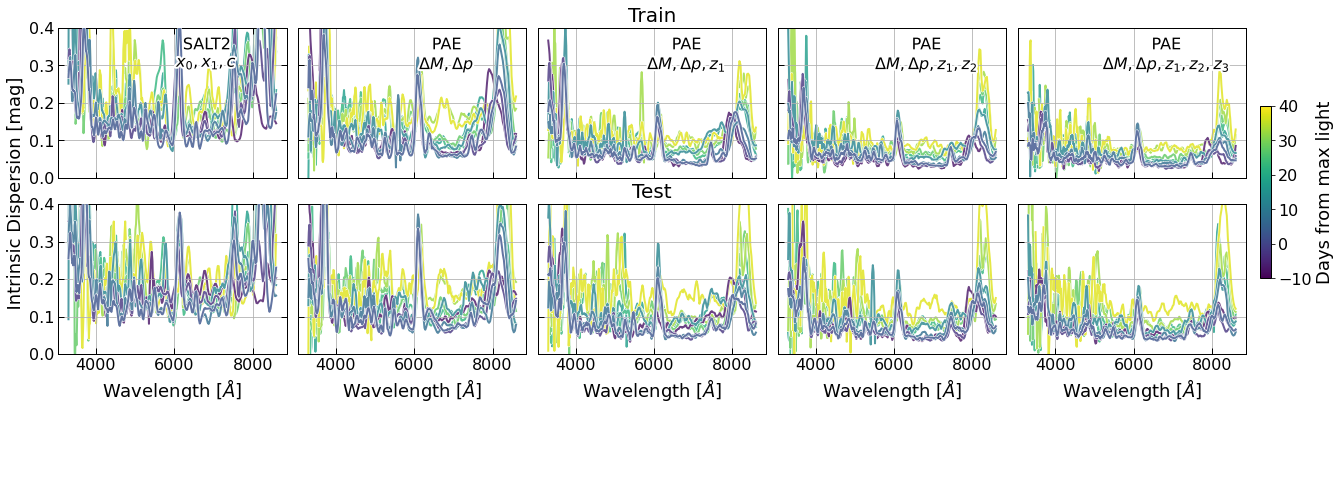

In [101]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from scipy.signal import savgol_filter

np.seterr(divide = 'ignore') 

# Simulate data
# When we quote an "intrinsic dispersion", what we are measuring is the additional dispersion that you need to explain the observed variance in your data.

# Assume that you have a data flux f, a model flux m, measurement uncertainties sigma_f, and you want to measure an intrinsic dispersion sigma_i. Then the statistical model is:

# f ~ N(m, sigma_f^2 + sigma_i^2)

# We fit for the maximum likelihood estimate of sigma_i. This is roughly equivalent to "picking the value of sigma_i that sets the chi2/DoF to 1". Here's a demo of how to do this in Python:
# Our model is a bit more complicated because we use a Gaussian process, but it's doing something similar under the hood. We do this for each wavelength separately.

ncolor = 256
neg_frac = 0.2 # time ranges from -10 to 40
# colors1 = plt.cm.Blues(np.linspace(0.2, 1, int(ncolor*neg_frac)))
# colors2 = plt.cm.Oranges_r(np.linspace(0, 0.8, int(ncolor*(1-neg_frac))))

# colors1 = plt.cm.Blues_r(np.linspace(0., 0.8, int(ncolor*neg_frac)))
# colors2 = plt.cm.Oranges(np.linspace(0.2, 1.0, int(ncolor*(1-neg_frac))))

# colors1 = plt.cm.hot(np.linspace(0.0, 0.4, int(ncolor*neg_frac)))
# colors2 = plt.cm.hot(np.linspace(0.4, 0.7, int(ncolor*(1-neg_frac))))
colors1 = plt.cm.coolwarm_r(np.linspace(0.5, 1.0, int(ncolor*neg_frac))[::-1])
colors2 = plt.cm.coolwarm_r(np.linspace(0.0, 0.5, int(ncolor*(1-neg_frac)))[::-1])
# colors1 = plt.cm.Spectral(np.linspace(0.0, 0.5, int(ncolor*neg_frac)))
# colors2 = plt.cm.Spectral(np.linspace(0.5, 1.0, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = LinearSegmentedColormap.from_list('my_colormap', colors)
# cmap = plt.cm.cividis

# cmap = plt.cm.turbo
cmap = plt.cm.viridis
# cmap = plt.cm.Spectral_r

# intrinsic_dispersion = 0.1
# N = 200
# measurement_uncertainties = np.random.uniform(0.05, 0.1, N)
# residuals = np.random.normal(0, np.sqrt(measurement_uncertainties**2 + intrinsic_dispersion**2), N)

# # Fit for the intrinsic dispersion
# def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion):
#     variance = measurement_uncertainties**2 + intrinsic_dispersion**2
#     return 1 / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

# def negative_log_likelihood(x):
#     likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
#     return -np.sum(np.log(likelihoods))

# from scipy.optimize import minimize
# res = minimize(negative_log_likelihood, [0.05])

# print(f"Recovered intrinsic dispersion: {res.x[0]}")



latent_dims = [1,2,3,4] # 3, 4, 5, 6, 7]
latent_dims = [-1,0,1,2,3]

savefig = True
# savefig = False

smooth_bins=7

# tstr = 'test'
tstrs = ['train', 'test']
# tstrs = ['train']
# tstrs = ['test']

# file_string = 'test'

# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'
# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect'#_longchain_Avvary'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all'#_longchain_Avvary'

# file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' #_magnitude_nosig'
file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"#_nosigmaweight_smallcov"

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00
params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False


fig, axss = plt.subplots(nrows=2, ncols=len(latent_dims),
                        sharey=True, figsize=(4*len(latent_dims), 6))#, gridspec_kw={'height_ratios': [3, 1]})

                         
fig.subplots_adjust(wspace=0.05, hspace=0.175)
    
for itstr, tstr in enumerate(tstrs):

    axs = axss[itstr]                 

    # Make dummie mappable
    xx = np.linspace(-10, 40, 100)
    dummie_cax = axs[0].scatter(xx, xx, c=xx, cmap=cmap)
    # Clear axis
    axs[0].cla()

    for ax in axs:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.)

        ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
        ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')


        ax.set_ylim(0, 0.4)

        ax.set_yscale('linear')

        ax.grid()
        
        if itstr == 1:
            ax.set_xlabel('Wavelength [$\AA$]')

        if itstr == 0:
            ax.set_xticklabels([])

    if itstr==1:
        axs[0].set_ylabel('                              Intrinsic Dispersion [mag]')

    
    for il, latent_dim in enumerate(latent_dims):
        
        if il == 2:
            axs[il].set_title(tstr.capitalize(), fontsize=20)

        if itstr == 0:

            if latent_dim < 0:
                latent_str = "SALT2\n"+r"$x_0, x_1, c$" 
            else:
                latent_str = "PAE\n"+r"$\Delta M, \Delta p" 
                if latent_dim > 0:
                    for idim in range(latent_dim):
                        latent_str += r", z_{:d}".format(idim+1)
                latent_str+="$"
            axs[il].text(train_data['wavelengths'][-70], 0.375,
                         latent_str, fontsize=16, ha='center', va='top',
                            path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], zorder=100)

#         if latent_dim == 3 or latent_dim==-1:
#             file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"
#             print(file_string)
#             train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)
#             test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)

#         else:

#             file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"
#             print(file_string)
#             train_data_file = '../outputs/old/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
#             test_data_file  = '../outputs/old/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
            
        latent_dim_load = latent_dim
        if latent_dim_load < 0:
            latent_dim_load = 3
        train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)
        test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)

    #     train_data['spectra_ae'] = np.clip(train_data['spectra_ae'], 0., np.inf)
    #     test_data['spectra_ae'] = np.clip(test_data['spectra_ae'], 0., np.inf)

        if tstr == 'train':
            train_data = load_data(train_data_file)
            data = train_data
        if tstr == 'test':
            test_data = load_data(test_data_file)
            data = test_data

        # from scipy.optimize import minimize
        # res = minimize(negative_log_likelihood, [0.05])

        # print(f"Recovered intrinsic dispersion: {res.x[0]}")

        dm = get_train_mask(data, params)

        #         dm_redshift = (data['redshifts'] > min_train_redshift) & \
        #                       (data['redshifts'] < max_train_redshift)

        if latent_dim < 0:

            t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_salt'][dm], data['sigma'][dm], data['times'][dm])
        else: 
            # t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_ae'][dm], data['sigma'][dm], data['times'][dm])
            t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_mcmc'][dm], data['sigma'][dm], data['times'][dm])

        zorders = [1,2,3,2,1,0,0,0,0,0,0]
        alpha = 0.9
        lw = 3

        # rms = -2.5*np.log10((mean_spectra)/(mean_spectra+intrinsic_dispersion))
        # rms = 2.5*np.log10((mean_spectra+intrinsic_dispersion)/(mean_spectra))
        rms = frac_to_mag(intrinsic_dispersion/mean_spectra)

        for it in range(t_bin_cent.shape[0]):
            rmsi = savgol_filter(rms[it], smooth_bins, 2)


            axs[il].plot(train_data['wavelengths'], rmsi, '-',
                    path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                    c=cmap(t_bin_cent[it]), 
    #                 lw=lw-abs(0.2-t_bin_cent[it]*2), 
    #                 alpha=alpha-abs(0.2-t_bin_cent[it]/2), 
                    lw=2, 
                    alpha=0.8, 
                    zorder=zorders[it])#, label='MAP')

        # ax1.set_title('SALT2', fontsize=16)

    
    

fig.subplots_adjust(right=0.95)
cax = fig.add_axes([0.96, 0.3, 0.0075, 0.4])
fig.colorbar(dummie_cax, cax=cax, label='Days from max light')

if savefig: 
    fname = 'rmse_train_test_all_dim'
    plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')


<ipython-input-56-8c7f2ea19166>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)


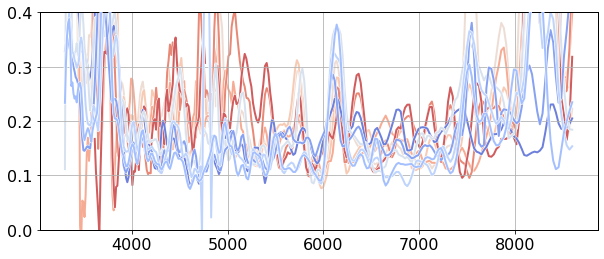

In [82]:
# integrate over bands to get integrates intrinsic dispersion

import sncosmo

file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"#_nosigmaweight_smallcov"
latent_dim = 3
tstrs = ['test']

filter_edges = {'u': np.array([3302., 4102.]),
                'b': np.array([4102., 5100.]),
                'v': np.array([5200., 6289.]),
                'r': np.array([6289., 7607.]),
                'i': np.array([7607., 8598.])}

smooth_bins=7
for itstr, tstr in enumerate(tstrs):
    plt.figure(figsize=(10,4))

    train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
    test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)


    if tstr == 'train':
        train_data = load_data(train_data_file)
        data = train_data
    if tstr == 'test':
        test_data = load_data(test_data_file)
        data = test_data



    dm = get_train_mask(data, params)

    #         dm_redshift = (data['redshifts'] > min_train_redshift) & \
    #                       (data['redshifts'] < max_train_redshift)

   
    t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_salt'][dm], data['sigma'][dm], data['times'][dm])
    # t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_ae'][dm], data['sigma'][dm], data['times'][dm])
    # t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_mcmc'][dm], data['sigma'][dm], data['times'][dm])

    zorders = [1,2,3,2,1,0,0,0,0,0,0]
    alpha = 0.9
    lw = 3

    # rms = -2.5*np.log10((mean_spectra)/(mean_spectra+intrinsic_dispersion))
    # rms = 2.5*np.log10((mean_spectra+intrinsic_dispersion)/(mean_spectra))
    rms = frac_to_mag(intrinsic_dispersion/mean_spectra)

    bandfluxes_salt = np.zeros((5, t_bin_cent.shape[0]))
    for it in range(t_bin_cent.shape[0]):
        # rmsi = rms[it]
        rmsi = savgol_filter(rms[it], smooth_bins, 2)
        
        spec = sncosmo.Spectrum(wave=train_data['wavelengths'], flux=rmsi)
        for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
            band = sncosmo.Bandpass(band_edges, band_edges*0+1, name=band_name)
            sncosmo.register(band, force=True)

            bandflux = spec.bandflux(band_name)/2.5e14

            bandfluxes_salt[iband, it] = bandflux



        plt.plot(train_data['wavelengths'], rmsi, '-',
                path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                c=cmap(t_bin_cent[it]), 
#                 lw=lw-abs(0.2-t_bin_cent[it]*2), 
#                 alpha=alpha-abs(0.2-t_bin_cent[it]/2), 
                lw=2, 
                alpha=0.8, 
                zorder=zorders[it])#, label='MAP')

    # ax1.set_title('SALT2', fontsize=16)

    plt.ylim(0,0.4)
    plt.grid()


[       nan 2.26286513 2.2996509  2.12851924 2.24825773        nan
        nan        nan        nan        nan]
[       nan 2.39851616 1.98633057 2.1329475  1.76586438        nan
        nan        nan        nan        nan]
[       nan 2.69324527 2.34475537 2.31471548 2.15660559        nan
        nan        nan        nan        nan]
[       nan 3.53016255 2.94505153 2.93702252 2.58810225        nan
        nan        nan        nan        nan]
[       nan 3.50628919 2.85280357 2.6971595  2.74335355        nan
        nan        nan        nan        nan]


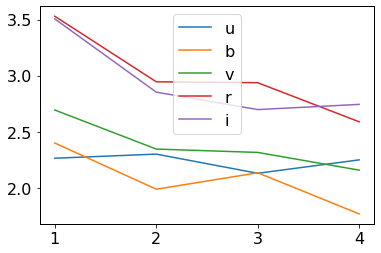

In [91]:
for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
    plt.plot(bandfluxes_salt[iband]/bandfluxes[iband], label=band_name)
    print(bandfluxes_salt[iband]/bandfluxes[iband])
plt.legend()
# plt.ylim(0,0.4)

# Visualize spectral effects of varying model parameters

In [124]:
import matplotlib.patheffects as pe

# Plot SN while varying z latent params to see effects

# savefig = True
savefig = False

figdir = '../figures/'

# Set up figure aesthetics
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
labels = ['$\Delta t$', '$\Delta M$', '$\Delta A_V$'] + latent

plot_line_labels = True

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

lwt = 2
lw  = 3

c0  = 'orangered'
c1  = 'C0'

dim_plus_2 = 1 #2

wave_txt = train_data['wavelengths'][-1]+100

alpha=0.8
plttypes = ['normal', 'residual']
aoffsets_list = [[0.1, 3], [0.1, 5], [1.5, 2.75]] #0.7]

# Get observation times and bin latent params
dm = get_train_mask(train_data, params)
z_latent_use = train_data['z_latent_mcmc']

nsamples = 10
percentiles = np.arange(10, 100, nsamples)
z_bin_edge = np.percentile(z_latent_use, percentiles, axis=0)
nsamples = z_bin_edge.shape[0]

Asamp = np.linspace(0.5, 1.5, nsamples)

nshow = 6 #3
times_lin = np.zeros((1, params['n_timestep'])) 
times_lin[:, :nshow] = np.linspace(0,1,nshow)
mask_     = np.ones((1, params['n_timestep']))

times_orig_lin = times_lin*50 - 10
times_lin[0,0] += 1./50
times_lin[0,nshow-1] -= 1./50

print(times_lin, times_orig_lin)

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0,1,nsamples))

z_median = np.median(z_latent_use[dm], axis=0)[None, ...]

# get u array of zeros
print(z_median, z_median.shape, colors.shape)

for dim in range(z_bin_edge.shape[1]):

    aoffsets = [0.75, 1.5]
    zsamp = z_bin_edge[:, dim]

    for iplt, plttype in enumerate(plttypes):
        
        if plttype == 'normal':   title = 'Varying {:s}'.format(labels[dim])
        if plttype == 'residual': title = 'Ratio'

        fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))#, gridspec_kw={'height_ratios': [3, 1]})

        for axis in ['top','bottom','left','right']:
            ax1.spines[axis].set_linewidth(1.)

        ax1.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
        ax1.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')

        ymin = 100
        ymax = -100
        
        # get origin value
        z_ = z_median.copy()
        xpred_m = PAE.decoder((z_, times_lin,  mask_))[0]
        
        offset = np.arange(times_lin.shape[1]) * -1 * aoffsets[iplt]
        
        for sample in range(z_bin_edge.shape[0]):

            # set u values along slice
            z_ = z_median.copy()
            z_[:, dim:dim+dim_plus_2] = zsamp[sample]

            xpred_i = PAE.decoder((z_, times_lin, mask_))[0] #/ (10**(-0.4* (CL*np.exp(z_[:, -1]) + z_[:, 0])))

            for i in range(nshow):
                labp = None
                labo = None
                if i==0:
                    labs = 'Encoder'
                    labp = 'MAP'
                if plttype == 'normal':
                    xpi = xpred_i[i] + offset[i]
                    ax1.plot(train_data['wavelengths'], xpi, '-',
                             c=colors[sample], lw=lw, alpha=alpha,
                            path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
                            )#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)

                    ymin = min(ymin, min(xpi) )
                    ymax = max(ymax, max(xpi) )

                if plttype == 'residual':
                    xti = xpred_m[i]
                    xpi = xpred_i[i]
                    ax1.plot(train_data['wavelengths'], xpi/xti - 1 + offset[i],
                             '-', c=colors[sample], lw=lw, alpha=alpha,
                            path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
                            )#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, (xpi/xti)[-1] - 1 + offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)
                
                    ymin = min(ymin, min(xpi/xti -1 + offset[i]) )
                    ymax = max(ymax, max(xpi/xti -1 + offset[i]) )

        if plot_line_labels:
            if plttype == 'residual':
                ymax_line_labels = 0.85
            if plttype == 'normal':
                ymax_line_labels = 0.95

            for line_label, (min_wave, max_wave) in label_lines.items():
                ax1.axvspan(min_wave, max_wave, alpha=0.15, ymax=ymax_line_labels, color='gray')
                if plttype == 'normal':
                    # display text
                    mean_wave = (min_wave + max_wave) / 2.
                    ax1.text(mean_wave, -aoffsets[iplt]*2.6, line_label, fontsize=10.,
                             horizontalalignment='center', verticalalignment='bottom')


        ax1.set_ylabel('Restframe Flux')
        ax1.set_xlabel('Wavelength [$\AA$]')
        ax1.set_ylabel('Normalized Restframe Flux(t, $\lambda$)')

        if plttype == 'normal':
            ymax = offset[0] + aoffsets[iplt] 
            ymin = offset[nshow-1]
            ax1.set_title(title, fontsize=20, y=0.97, pad=0)

        if plttype == 'residual':
            # ymax = ymax+0.5
            # ymin = ymin-0.5
            ymax = offset[0] + aoffsets[iplt] * 1.5
            ymin = offset[nshow-1] - aoffsets[iplt]*1./2
            ax1.set_title(title, fontsize=20, y=0.91, pad=0)

        ax1.set_ylim(ymin, ymax)
        ax1.set_frame_on(False)
        ax1.get_xaxis().tick_bottom()
        ax1.axes.get_yaxis().set_visible(False)
        xmin, xmax = ax1.get_xaxis().get_view_interval()
        ymin, ymax = ax1.get_yaxis().get_view_interval()
        ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

        ax1.legend(loc='upper right', frameon=False, ncol=3)


    #     ax1.axis('off')

    #     ax2.set_yscale('log')
        ax1.set_xlim(train_data['wavelengths'][0], train_data['wavelengths'][-1])
    #     plt.subplots_adjust(hspace=0.025)

        if savefig: 
            fname = 'vary_zlatent_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)
            if dim_plus_2 > 1:
                fname = 'vary_zlatent_dimplus2_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)

            plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')



[[0.02 0.2  0.4  0.6  0.8  0.98 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]] [[-10.   0.  10.  20.  30.  40. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10.]]
[[-0.00159222 -0.00817813  0.01704234 -0.03345852  0.0035843   0.109412  ]] (1, 6) (9, 4)


No handles with labels found to put in legend.


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aab2e1330d0> (for post_execute):


KeyboardInterrupt: 

# Magnitude residuals vs other techniques

In [24]:
import pandas as pd
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

### Simple magnitude standardization function trials. Not used in paper 

(155, 4)
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.04207724],
       [-0.07141614],
       [ 0.0156042 ],
       [ 0.00592166]], dtype=float32)> <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-0.01146601], dtype=float32)>


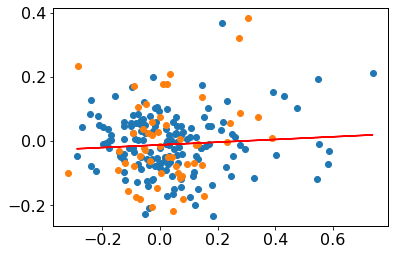

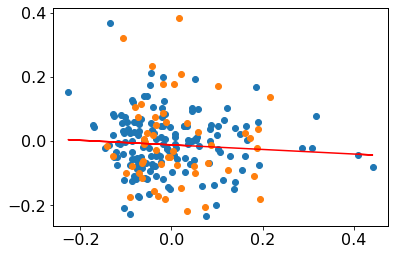

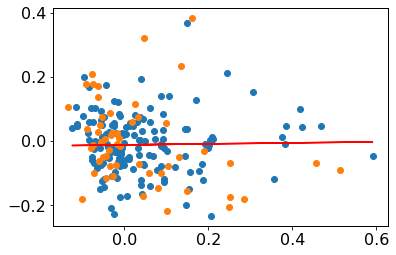

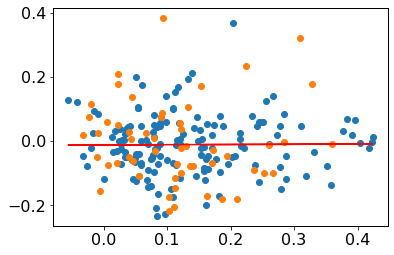

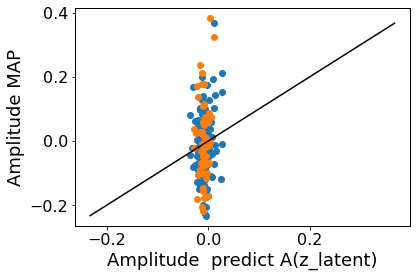

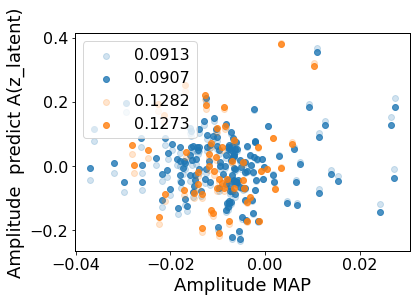

In [25]:
# fit NL model to predict delta m
# standardize_time = True
standardize_time = False

# fit_model = 'OLS'
fit_model = 'NN1'
# fit_model = 'NN3'

start_dim = 2
end_dim = 10
train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)


# dm = (train_data['redshifts'] > params['min_train_redshift']) & \
#               (train_data['redshifts'] < params['max_train_redshift'])
    
dm = get_train_mask(train_data, params)
dm_test = get_train_mask(test_data, params)

# dm_in, dm = get_twins_mask(train_data)
# dm_in, dm_test = get_twins_mask(test_data)

z_train = train_data['z_latent_mcmc'][dm, start_dim:end_dim]
if standardize_time:
    z_train = np.c_[z_train, train_data['dtime_map'][dm]]
A_train = train_data['z_latent_mcmc'][dm, 1]
A_train_err = train_data['z_latent_mcmc_err'][dm, 1]

z_test = test_data['z_latent_mcmc'][dm_test, start_dim:end_dim]
if standardize_time:
    z_test = np.c_[z_test, test_data['dtime_map'][dm_test]]
A_test = test_data['z_latent_mcmc'][dm_test, 1]


# OLS
import scipy.optimize as optimization

if fit_model == 'OLS':
    def func(x, a, b, c):
        return a + b*x[:,0] + c*x[:,1] 
    x0  = np.zeros(z_train.shape[1]+1)

    print(z_train.shape)
#     pfit, pcov = optimization.curve_fit(func, z_train, A_train.flatten(), x0, A_train_err.flatten())
    pfit, pcov = optimization.curve_fit(func, z_train, A_train.flatten(), x0)

    print(pfit, pcov)

    print('debug', (z_train @ pfit[1:]).shape)
    pred_train = pfit[0] + z_train @ pfit[1:]
    pred_test = pfit[0] + z_test @ pfit[1:]

# 1 layer NN
if fit_model == 'NN1':
    amplitude_input_dim = z_train.shape[1]
    amplitude_predictor_inputs = tfkl.Input(shape=(amplitude_input_dim))            
    amplitude_predictor_outputs = tf.keras.layers.Dense(1, use_bias=True)(amplitude_predictor_inputs)                   

    
# 3 layer NN
if fit_model == 'NN3':
    amplitude_input_dim = z_train.shape[1]
    amplitude_predictor_inputs = tfkl.Input(shape=(amplitude_input_dim))
    x = tf.keras.layers.Dense(4, activation=tf.nn.tanh, use_bias=True)(amplitude_predictor_inputs) 
    x = tf.keras.layers.Dense(2, activation=tf.nn.tanh, use_bias=True)(x) 
    amplitude_predictor_outputs = tf.keras.layers.Dense(1, use_bias=True)(x)                   
  
if 'NN' in fit_model:
    Amodel = tfk.Model(inputs=amplitude_predictor_inputs, 
              outputs=amplitude_predictor_outputs)   

    optimizer = tfk.optimizers.Adam(learning_rate=0.01)

    Amodel.compile(optimizer=optimizer, loss="mse", metrics=["mse"])


    print(z_train.shape)
    # z_train = np.c_[z_train, train_data['dtime_map']]
    Amodel.fit(z_train, A_train, epochs=2500, verbose=0)

    for il in Amodel.layers:
        if il.weights != []:
    #         print(il.weights)
            w, b = il.weights
            print(w,b)

    xx = np.linspace(A_train.min(),A_train.max(),10)
    pred_train = Amodel.predict(z_train).flatten()
    pred_test = Amodel.predict(z_test).flatten()


for i in range(z_train.shape[1]):
    plt.figure()
    plt.scatter(z_train[:, i], A_train)
    plt.scatter(z_test[:, i], A_test)
    if fit_model=='NN1':
        plt.plot(z_train[:, i], (z_train[:, i]*w[i] + b), color='r')
    if fit_model=='OLS':
         plt.plot(z_train[:, i], pfit[0] + z_train[:, i] * pfit[1:][i], color='r')

if z_train.shape[1]==2:
    plt.figure()
    plt.scatter(z_train[:, 0], z_train[:, -1], c=A_train)
    plt.figure()
    plt.scatter(z_test[:, 0], z_test[:, -1], c=A_test)
#     plt.scatter(z_train[:, i], (z_train*w + b)[:, i])
# # plt.scatter(z_test, A_test)
# plt.xlabel('z')
# plt.ylabel('Amplitude')

xx = np.linspace(A_train.min(),A_train.max(),10)

plt.figure()
plt.scatter(pred_train, A_train)
plt.scatter(pred_test, A_test)
plt.plot(xx, xx, 'k')
plt.xlabel('Amplitude  predict A(z_latent)')
plt.ylabel('Amplitude MAP')

plt.figure()
plt.scatter(pred_train, A_train, color='C0', alpha=0.2, label='{:.4f}'.format(A_train.std()))
plt.scatter(pred_train, A_train-pred_train, color='C0', alpha=0.8,  label='{:.4f}'.format((A_train-pred_train).std()))

plt.scatter(pred_test, A_test, color='C1', alpha=0.2, label='{:.4f}'.format(A_test.std()))
plt.scatter(pred_test, A_test-pred_test, color='C1', alpha=0.8,  label='{:.4f}'.format((A_test-pred_test).std()))

# plt.scatter(A_test, A_test-pred_test)

plt.ylabel('Amplitude  predict A(z_latent)')
plt.xlabel('Amplitude MAP')
plt.legend()

(122, 9)
9 5


<ipython-input-7-0f8c33f2395b>:281: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-7-0f8c33f2395b>:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=40)


(42, 9)
9 5


<ipython-input-7-0f8c33f2395b>:281: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-7-0f8c33f2395b>:276: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=40)


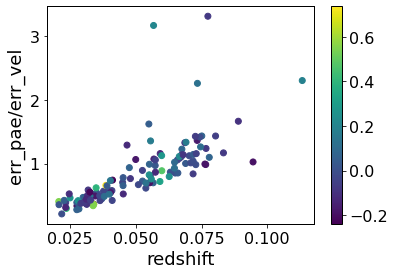

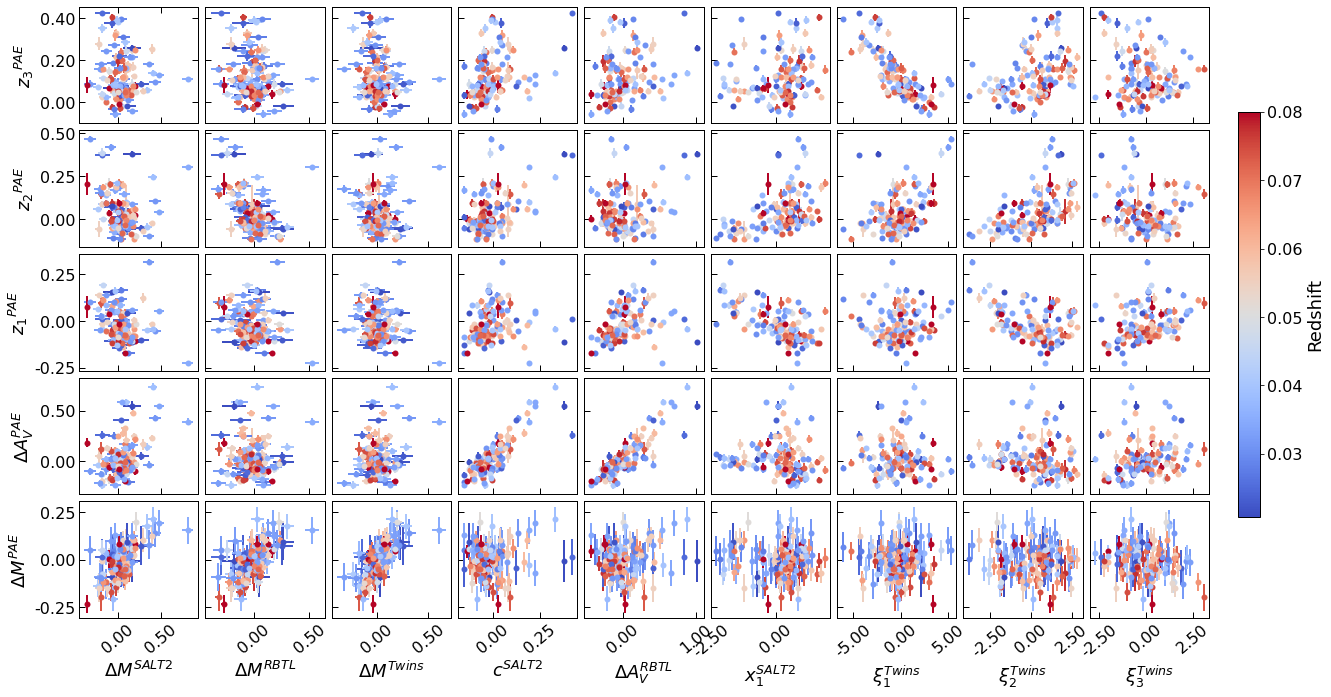

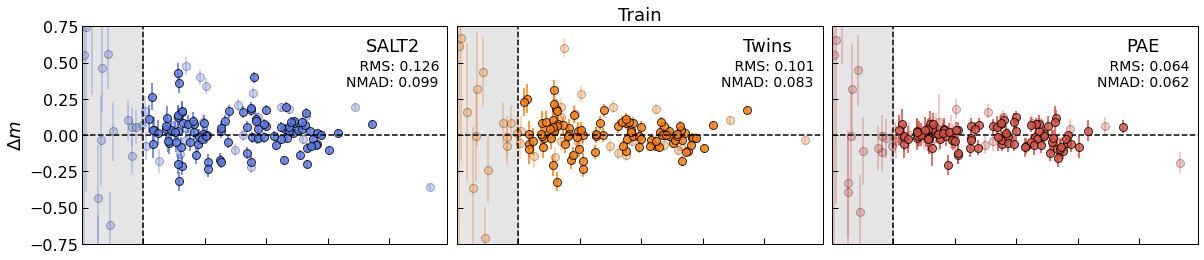

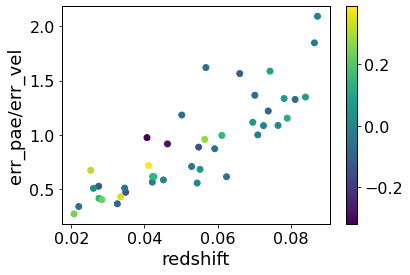

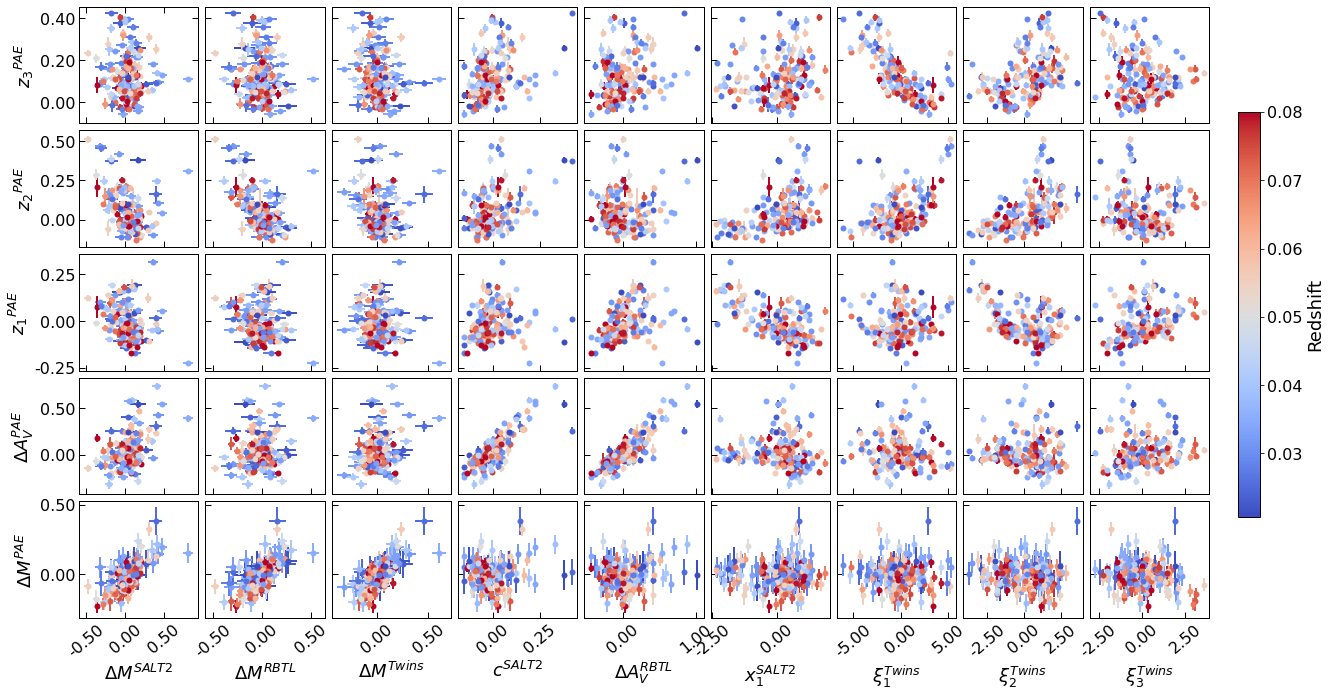

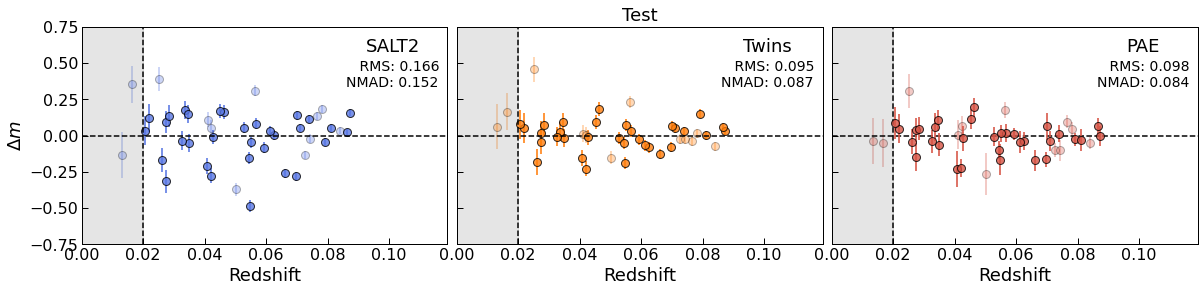

In [32]:
import pandas as pd

df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

maxlightcut_str = ''
# maxlightcut_str = '_maxlightcut_new'


# file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0{:s}'.format(maxlightcut_str)

# # file_string = 'layers256-128-32_3stage_train_decorrelate_all_reverse_2_longchain' #_lonchain_newinit' #_magnitude_nosig_twinscut'

file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

# file_string = 'layers256-128-32_3stage_train_decorrelate_all'

file_string = "layers256-128-32_3stage_train_decorrelate_all"

savefig = True
# savefig = False

# show_plot_grid = True
show_plot_grid = False

show_plot_grid_one_vs_other = True
# show_plot_grid_one_vs_other = False

# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
color_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

ms = 8
yminmax = 0.75

alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
fontsize_meas = 14
fontsize_label = 18

ypos_meas = 0.85
ypos_label = 0.95

xpos_meas = 0.85
xpos_label = 0.85

frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3: xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']
# tstrs = ['test']

# seeds_use = np.arange(8)
seeds_use = np.array([0, 1, 2, 3, 4, 5, 6, 7])#, 8, 9])

grid_xy = 2.25 #1.75
spacing = 0.06

for ti, tstr in enumerate(tstrs):
    
    if tstr=='train':
        data = train_data

        m = '*'
#         dm = np.full(train_data['maximum_likelihood'].shape[0], True, dtype=bool)
#         dm = train_data['maximum_likelihood'] > test_data['maximum_likelihood']

    if tstr=='test':
        m = '*'
        data = test_data

    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    xi1_twins = np.zeros(data['redshift'].shape[0])
    xi2_twins = np.zeros(data['redshift'].shape[0])
    xi3_twins = np.zeros(data['redshift'].shape[0])

    
    c_salt = data['c']
    x1_salt = data['x1']

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
        xi1_twins[ind_snf] = dfi['xi_1']
        xi2_twins[ind_snf] = dfi['xi_2']
        xi3_twins[ind_snf] = dfi['xi_3']

    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    
    # Dl = c*z/H0
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err to get new redshift      

    dl = z #(1+z)*z
    dl1 = z1 #(1+z1)*z1 # don't need leading constant c/H0
    
    # mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05
    mag_err_vel = abs(-5*np.log10(dl/dl1)) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]

    mask_grid = in_twins
    # mask_grid = mask_twins
    mask_grid = dm_redshift & mask_grid


    labels_pae = [
        # '$\Delta t$',
        '$\Delta M^{PAE}$',
        '$\Delta A_V^{PAE}$',
    ] + latent
    labels_twins = [
        r'$\xi_3^{Twins}$',
        r'$\xi_2^{Twins}$',
        r'$\xi_1^{Twins}$',
        r'$\Delta A_V^{RBTL}$',
        r'$\Delta m^{Twins}$',
        r'$\Delta m^{RBTL}$',
    ]
    labels_salt = ['$x_1^{SALT2}$',
                   '$c^{SALT2}$',
                   '$\Delta m^{SALT2}$',
                  ]

#     c_err = np.exp(data['z_latent_mcmc'][mask_twins][:, -1] + data['z_latent_mcmc_err'][mask_twins][:, -1]) - np.exp(data['z_latent_mcmc'][mask_twins][:, -1])
    arr_pae = data['z_latent_mcmc'][mask_grid, 1:]
    arr_pae_err = data['z_latent_mcmc_err'][mask_grid, 1:]
    
#     arr_pae[:, 0] *= 50
#     arr_pae_err[:, 0] *= 50
    
    arr_pae_err[:, 0] = np.sqrt(arr_pae_err[:,1]**2 + mag_err_vel[mask_grid]**2)

    # labels_pae = list(np.roll(labels_pae, -1))
    # arr_pae = np.roll(arr_pae, -1, axis=1)
    # arr_pae_err = np.roll(arr_pae_err, -1, axis=1)

    plt.figure()
    plt.scatter(data['redshift'][mask_grid], arr_pae_err[:,1]/mag_err_vel[mask_grid], c=arr_pae[:,1])
    plt.xlabel('redshift')
    plt.ylabel('err_pae/err_vel')
    plt.colorbar()
    
    arr_twins = np.c_[
        xi3_twins[mask_grid],
        xi2_twins[mask_grid],
        xi1_twins[mask_grid],
        av_rbtl[mask_grid],
        dm_resid_twins[mask_grid],
        dm_rbtl[mask_grid]]
    arr_twins_err = np.c_[
        xi1_twins[mask_grid]*0.,
        xi1_twins[mask_grid]*0.,
        xi1_twins[mask_grid]*0.,
        av_twins_err[mask_grid],
        dm_twins_err[mask_grid],
        dm_twins_err[mask_grid],
    ]
    
    arr_salt = np.c_[x1_salt[mask_grid], c_salt[mask_grid], dm_resid_salt[mask_grid]+mag_err_vel[mask_grid]]
    arr_salt_err = arr_salt*0.
    
    # arr_others = np.c_[arr_twins, arr_salt]
    # arr_others_err = np.c_[arr_twins_err, arr_salt_err]
    # labels_others = labels_twins + labels_salt
    labels_others = [
        r'$\xi_3^{Twins}$',
        r'$\xi_2^{Twins}$',
        r'$\xi_1^{Twins}$',
        '$x_1^{SALT2}$',
        '$\Delta A_V^{RBTL}$',
        '$c^{SALT2}$',
        '$\Delta M^{Twins}$',
        '$\Delta M^{RBTL}$',
        '$\Delta M^{SALT2}$',

        ]
    arr_others = np.c_[
        xi3_twins[mask_grid],
        xi2_twins[mask_grid],
        xi1_twins[mask_grid],
        x1_salt[mask_grid],
        av_rbtl[mask_grid],
        c_salt[mask_grid],
        dm_resid_twins[mask_grid],
        dm_rbtl[mask_grid],
        dm_resid_salt[mask_grid],
    ]
    arr_others_err = np.c_[
        xi3_twins[mask_grid]*0,
        xi2_twins[mask_grid]*0,
        xi1_twins[mask_grid]*0,
        x1_salt[mask_grid]*0,
        av_twins_err[mask_grid],
        c_salt[mask_grid]*0,
        dm_twins_err[mask_grid],
        dm_twins_err[mask_grid],
        dm_resid_salt[mask_grid]*0.+mag_err_vel[mask_grid],
    ]

    if tstr=='train':
        arr_pae_all = arr_pae.copy()
        arr_pae_err_all = arr_pae_err.copy()
        arr_others_all = arr_others.copy()
        arr_others_err_all = arr_others_err.copy()   
        color_all = data['redshift'][mask_grid].copy()
    if tstr=='test':
        arr_pae_all = np.concatenate([arr_pae_all, arr_pae], axis=0)
        arr_pae_err_all = np.concatenate([arr_pae_err_all, arr_pae_err])
        arr_others_all = np.concatenate([arr_others_all, arr_others], axis=0)
        arr_others_err_all = np.concatenate([arr_others_err_all, arr_others_err], axis=0)  
        color_all = np.concatenate([color_all, data['redshift'][mask_grid]])
        
    arr = np.c_[arr_pae, arr_twins, arr_salt]
    err = np.c_[arr_pae_err, arr_twins_err, arr_salt_err]
    labels = labels_pae + labels_twins + labels_salt
#     err = np.c_[data['amplitude_mcmc_err'][in_twins], data['z_latent_mcmc_err'][in_twins][:, 1:-1], c_err, data['dtime_mcmc_err'][in_twins]*50, av_twins_err[in_twins], dm_twins_err[in_twins]]

    if show_plot_grid:
        plot_grid(arr, labels=labels, color_arr=data['redshift'][mask_grid], errs=err, #xyminmax=xyminmax,
                  color_label='Redshift', cmap=plt.cm.viridis, figsize=(12,12), s=6,
                  savefig=savefig, filename=figdir+'AE_and_RBTL_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))

    if show_plot_grid_one_vs_other:
#         plot_grid_one_vs_other(arr_pae, arr_salt, labels1=labels_pae, labels2=labels_salt,
#                                errs1=arr_pae_err, errs2=arr_salt_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_salt.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_salt_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
#         plot_grid_one_vs_other(arr_pae, arr_twins, labels1=labels_pae, labels2=labels_twins,
#                                errs1=arr_pae_err, errs2=arr_twins_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_twins.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_twins_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
        
#         plot_grid_one_vs_other(arr_pae, arr_others, labels1=labels_pae, labels2=labels_others,
#                                errs1=arr_pae_err, errs2=arr_others_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_others.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_others_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
 
        print(arr_others.shape)
        plot_grid_one_vs_other(arr_others_all[:, ::-1], arr_pae_all[:, ::-1], labels1=labels_others[::-1], labels2=labels_pae[::-1],
                               errs1=arr_others_err_all[:, ::-1], errs2=arr_pae_err_all[:, ::-1],
                               color_arr=color_all, spacing=spacing, color_symmetric=True, #xyminmax=xyminmax,
                  color_label='Redshift', cmap=plt.cm.coolwarm, figsize=(grid_xy*arr_others.shape[1], grid_xy*arr_pae.shape[1]), s=6, markeredgecolor='none',
                  savefig=savefig, filename=figdir+'PAE_vs_others_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        # z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
    


#     wrms_twins =  np.sqrt(np.sum( (dm_twins[in_twins][dm_redshift] - dm_twins[in_twins][dm_redshift].mean())**2 / dm_twins_err[in_twins][dm_redshift]**2) / np.sum(1./dm_twins_err[in_twins][dm_redshift]**2))
#     wrms_hmc =  np.sqrt(np.sum( (data['amplitude_mcmc'][in_twins][dm_redshift]- data['amplitude_mcmc'][in_twins][dm_redshift].mean())**2 / data['amplitude_mcmc_err'][in_twins][dm_redshift]**2) / np.sum(1./data['amplitude_mcmc_err'][in_twins][dm_redshift]**2))
#     mask_performance = in_twins

    mask_performance = mask_twins
    
    dm_redshift = dm_redshift[mask_performance]

    wrms_resid_salt =  np.std(dm_resid_salt[mask_twins]) 

    wrms_rbtl =  np.std(dm_rbtl[mask_twins]) 
    wrms_resid_twins =  np.std(dm_resid_twins[mask_twins]) 

    wrms_hmc =  np.std(data['amplitude_mcmc'][mask_twins]) 

    k_nmad = 1.4826
    mad_rbtl   = k_nmad * np.median( np.abs(dm_rbtl[mask_performance][dm_redshift] - np.median(dm_rbtl[mask_performance][dm_redshift]) ))
    mad_hmc    = k_nmad * np.median( np.abs(data['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data['amplitude_mcmc'][mask_performance][dm_redshift]) ))

    mad_resid_salt  = k_nmad * np.median( np.abs(dm_resid_salt[mask_performance][dm_redshift] - np.median(dm_resid_salt[mask_performance][dm_redshift]) ))
    mad_resid_twins = k_nmad * np.median( np.abs(dm_resid_twins[mask_performance][dm_redshift] - np.median(dm_resid_twins[mask_performance][dm_redshift]) ))

    lab_rbtl = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_rbtl, mad_rbtl)    
    lab_salt = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_resid_salt, mad_resid_salt)    
    lab_twins = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_resid_twins, mad_resid_twins)
    lab_hmc = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_hmc, mad_hmc)



    fig = plt.figure(figsize=(20,4))

    nx = 3
    # SALT
    ax = fig.add_subplot(1, nx, 1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_resid_salt[in_twins & ~mask_twins], yerr=mag_err_vel[in_twins & ~mask_twins],
                ms=ms, marker='o', color=color_salt, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)

    ax.errorbar(data['redshift'][mask_twins], dm_resid_salt[mask_twins], yerr=mag_err_vel[mask_twins],
                ms=ms, marker='o', label=lab_salt, color=color_salt, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha1)

    ax.text(xpos_meas, ypos_meas, lab_salt,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'SALT2',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)    
    
    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_ylabel('$\Delta m$')
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    # ax.set_title('SALT2', fontsize=18)

    
    ax = fig.add_subplot(1, nx, 2)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    # ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_rbtl[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
    #             ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    # ax.errorbar(data['redshift'][mask_twins], dm_rbtl[mask_twins], yerr=dm_twins_err[mask_twins],
    #             ms=ms, marker='o', label=lab_rbtl, color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=0, alpha=alpha0)

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_resid_twins[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_twins, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], dm_resid_twins[mask_twins], yerr=dm_twins_err[mask_twins],
                ms=ms, marker='o', label=lab_twins, color=c_twins, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha1)

    ax.text(xpos_meas, ypos_meas, lab_twins,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'Twins',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)    
    

    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_yticklabels([])
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    ax.set_title(tstr.capitalize(), fontsize=18)
    

    for iseed, seed in enumerate(seeds_use):
        data_filei = f'../outputs/{tstr}_data_kfold{kfold}_posterior_{latent_dim:02d}Dlatent_{file_string}_seed{seed}{maxlightcut_str}.npy'
        datai = load_data(data_filei)

        if iseed == 0:
            A = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))
            A_err = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))

        A[iseed] = datai['amplitude_mcmc']
        A_err[iseed] = np.sqrt(datai['amplitude_mcmc_err']**2)# + mag_err_vel**2)


    # ND
    for iplt in range(A.shape[0]):
        wrms_hmc =  np.std(A[iplt][mask_twins]) 
        lab_hmc = '$Model{:d}: \sigma={:.3f}, NMAD={:.3f}$'.format(iplt,  wrms_hmc, mad_hmc)

        k_nmad = 1.4826
        mad_hmc    = k_nmad * np.median( np.abs(A[iplt][mask_twins] - np.median(A[iplt][mask_twins]) ))

        # ax.errorbar(data['redshift'][in_twins & ~mask_twins], A[iplt][in_twins & ~mask_twins], yerr=A_err[iplt][in_twins & ~mask_twins],
        #             ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
        # ax.errorbar(data['redshift'][mask_twins], A[iplt][mask_twins], yerr=A_err[iplt][mask_twins],
        #             ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', label=lab_hmc, ls='none', lw=2, zorder=4, alpha=alpha1) #

        
        
#     # http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
    weight = 1./A_err**2
    n_eff = np.sum(weight*A, axis=0)**2/np.sum(weight**2, axis=0)

    # A_mean = A.mean(0)
    weighted_mean = np.sum(weight*A, axis=0)/np.sum(weight, axis=0)

    weighted_deviation  = np.sqrt(A.shape[0]/(A.shape[0] - 1) *  
                            ( np.sum(weight*A**2, axis=0)/np.sum(weight, axis=0) - weighted_mean**2))

    weighted_err = weighted_deviation #/np.sqrt(A.shape[0])
    weighted_err = np.sqrt(weighted_err**2 + mag_err_vel**2)

    # save final parameters to file
    np.savez('../data/final_magnitude_fits_{:s}{:s}.npz'.format(tstr, maxlightcut_str),
             dm=weighted_mean,
             dm_sig=weighted_err,
             dm_vel=mag_err_vel,

             dm_resid_salt=dm_resid_salt,
             dm_resid_salt_err=mag_err_vel,
             
             dm_rbtl=dm_rbtl,
             dm_rbtl_err=mag_err_vel,

             dm_resid_twins=dm_resid_twins,
             dm_resid_twins_err=dm_twins_err,
             
            in_twins=in_twins,
            mask_twins=mask_twins)
    
    wrms_hmc =  np.std(weighted_mean[mask_twins], axis=0)

    k_nmad = 1.4826
    mad_hmc = k_nmad * np.median( np.abs(weighted_mean[mask_twins] - np.median(weighted_mean[mask_twins]) ))

    lab_hmc = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_hmc, mad_hmc)

    ax = fig.add_subplot(1, nx, 3)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')
   

    # ND
    # weighted_mean = A[0]
    # weighted_err = weighted_mean*0
    ax.errorbar(data['redshift'][in_twins & ~mask_twins], weighted_mean[in_twins & ~mask_twins], yerr=weighted_err[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_pae, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], weighted_mean[mask_twins], yerr=weighted_err[mask_twins],
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc, color=c_pae, ls='none', lw=2, zorder=4, alpha=alpha1)
    
    ax.text(xpos_meas, ypos_meas, lab_hmc,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'PAE',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)

    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)#, title=r'$\sigma, NMAD$')
    ax.axhline(0.0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    if savefig:
        plt.savefig(figdir+'deltamag_vs_others_{:02d}latent_{:s}.pdf'.format(latent_dim, tstr), bbox_inches='tight')
          

(164, 5)
Train mean : 0.033647, var : 0.174732


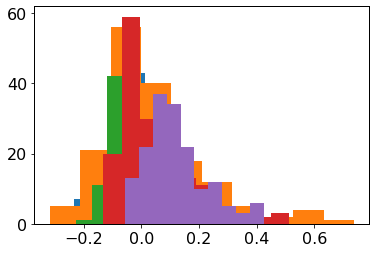

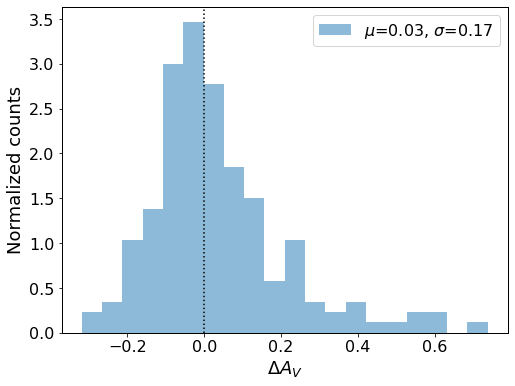

In [98]:
print(arr_pae_all[:, ::-1].shape)
for i in range(5):
    plt.hist(arr_pae_all[:, i])
    
    
import numpy as np
import sklearn
import sklearn.mixture
from scipy.stats import norm
import matplotlib.pyplot as plt

# np.save('dt_train', data_fit)


gmm = sklearn.mixture.GaussianMixture()

r_train = gmm.fit(arr_pae_all[:, 1][:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
gmm_mean_train =  r_train.means_[0, 0]
gmm_std_train = np.sqrt(r_train.covariances_[0, 0])
print("Train mean : %f, var : %f" % (gmm_mean_train, gmm_std_train))


plt.figure(figsize=(8,6))

plt.hist(arr_pae_all[:, 1], alpha=0.5, bins=20, color='C0', density=True, label='$\mu$=%.2f, $\sigma$=%.2f'%(gmm_mean_train, gmm_std_train))

xx = np.linspace(arr_pae_all[:, 1], arr_pae_all[:, 1], 100)
plt.plot(xx, norm.pdf(xx, gmm_mean_train, gmm_std_train), color='C0')

plt.axvline(0, color='k', ls=':')

plt.xlabel('$\Delta A_V$')
plt.ylabel('Normalized counts')

plt.legend(loc='upper right')

# plt.figure()
# plt.hist(arr_pae_all[:, 1])

# Perform bootstrap error sampling

In [34]:
#     np.savez(
#              deltam=weighted_mean,
#              deltam_sig=weighted_err,
#             in_twins=in_twins,
#             mask_twins=mask_twins)
def calculate_nmad(thetas):
    k_nmad = 1.4826
    nmad = k_nmad * np.median( np.abs(thetas - np.median(thetas)) )
    return nmad

def bootstrap_errors(thetas, nresample=10):
    # takes in list of measurements and performs boostrap sampling
    
    sample_rms = np.zeros(nresample)
    sample_nmad = np.zeros(nresample)

    for isamp in range(nresample):
        samples = np.random.choice(thetas, thetas.shape[0], replace=True)
        
        sample_rms[isamp] = np.std(samples)
        sample_nmad[isamp] = calculate_nmad(samples)
    
    bootstrap_rms  = np.mean(sample_rms)
    bootstrap_nmad = np.mean(sample_nmad)
    
    bootstrap_rms_std  = np.sqrt(1./(nresample-1) * np.sum( (bootstrap_rms - sample_rms)**2))
    bootstrap_nmad_std = np.sqrt(1./(nresample-1) * np.sum( (bootstrap_nmad - sample_nmad)**2))

    return bootstrap_rms_std, bootstrap_nmad_std

maxlightcut_str = ''
# maxlightcut_str = '_maxlightcut'

# ['dm', 'dm_sig', 'dm_resid_salt', 'dm_resid_salt_err', 'dm_rbtl', 'dm_rbtl_err', 'dm_resid_twins', 'dm_resid_twins_err', 'in_twins', 'mask_twins']
nbootstrap_sample = 10000

# dm_strs = ['dm_resid_salt', 'dm_rbtl', 'dm_resid_twins', 'dm']#, 'dm_vel']
dm_strs = ['dm']#, 'dm_vel']

dm_strs_to_display = {'dm': 'PAE',
                      'dm_resid_salt': 'SALT2',
                      'dm_resid_twins': 'Twins',
                       'dm_rbtl': 'RBTL',
                     'dm_vel': 'Vel'}

tstrs = ['train', 'test']
remove_vel = True
table = {}
for tstr in tstrs:
    tablei = {}

    for dm_str in dm_strs:
        data = np.load('../data/final_magnitude_fits_{:s}{:s}.npz'.format(tstr, maxlightcut_str))
        rms_vel = np.sqrt(np.sum(data['dm_vel'][data['mask_twins']]**2)/data['dm_vel'][data['mask_twins']].shape[0])
        print(rms_vel)

        print(tstr, data['in_twins'].sum(), data['mask_twins'].sum())
        measurements = data[dm_str][data['mask_twins']]

        rms =  np.std(measurements, axis=0)
        nmad = calculate_nmad(measurements)

        rms_std, nmad_std = bootstrap_errors(measurements, nbootstrap_sample)

        d = {}
        d['NMAD'] = '{:.3f} pm {:.3f}'.format(nmad, nmad_std)
        d['RMS'] = '{:.3f} pm {:.3f}'.format(rms, rms_std)
        d['RMS_noVel'] = '{:.3f} pm {:.3f}'.format(np.sqrt(rms**2-rms_vel**2), rms_std)

#         if remove_vel:
#             dm = measurements > 0
#             measurements_i = measurements[dm].copy()
#             measurements_i -= data['dm_vel'][data['mask_twins']][dm]
#             measurements_i[measurements_i < 0] = 0.
#             measurements[dm] = measurements_i
            
#             dm = measurements < 0
#             measurements_i = measurements[dm].copy()
#             measurements_i += data['dm_vel'][data['mask_twins']][dm]
#             measurements_i[measurements_i > 0] = 0.
#             measurements[dm] = measurements_i    
            
#         rms =  np.std(measurements, axis=0)
#         nmad = calculate_nmad(measurements)

#         rms_std, nmad_std = bootstrap_errors(measurements, nbootstrap_sample)
     
#         d['RMS_unexplained'] = '{:.3f} pm {:.3f}'.format(rms, rms_std)

        # d['rms_err'] = rms_std
        # d['nmad'] = nmad
        # d['nmad_err'] = nmad_std


        tablei[dm_strs_to_display[dm_str]] = d

        print(r'{:s}: RMS = {:.3f} $\pm$ {:.3f}, NMAD {:.3f} $\pm$ {:.3f}'.format(tstr, 
                                                                                  rms,
                                                                                  rms_std,
                                                                                  nmad,
                                                                                  nmad_std))
    table[tstr] = tablei
    
print(table)

0.0524253606386224
train 137 96
train: RMS = 0.064 $\pm$ 0.005, NMAD 0.062 $\pm$ 0.009
0.05343261553738736
test 44 32
test: RMS = 0.098 $\pm$ 0.012, NMAD 0.084 $\pm$ 0.025
{'train': {'PAE': {'NMAD': '0.062 pm 0.009', 'RMS': '0.064 pm 0.005', 'RMS_noVel': '0.036 pm 0.005'}}, 'test': {'PAE': {'NMAD': '0.084 pm 0.025', 'RMS': '0.098 pm 0.012', 'RMS_noVel': '0.082 pm 0.012'}}}


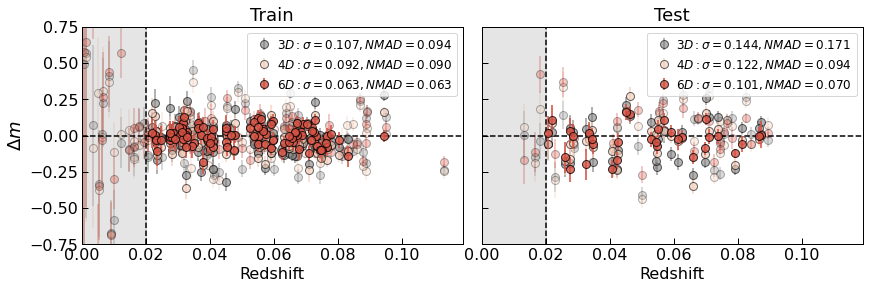

In [302]:
#RBTL vs PAE 2 d
# rbtl_av	rbtl_av_err	rbtl_dm	rbtl_dm_err

# name,iau_name,salt_x1,salt_x1_err,salt_c,salt_c_err,rbtl_av,rbtl_av_err,rbtl_dm,rbtl_dm_err,xi_1,xi_2,xi_3,dm_residuals_twins,dm_residuals_salt,mask_twins,mask_salt
import pandas as pd
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 4

kfold = 0
# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'
# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'#_nooverfit'
# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect'#_longchain'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all_amploss'#_1e-3clip'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all_reverse_2'#_magnitude_nosig_twinscut' #_maxlight'#_1e-3clip'

file_string = 'layers64-32-16_3stage_train_decorrelate_all'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)

train_data_2d = load_data(train_data_file)
test_data_2d  = load_data(test_data_file)

file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_01Dlatent_{:s}.npy'.format(kfold, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_01Dlatent_{:s}.npy'.format(kfold, file_string)

train_data_3d = load_data(train_data_file)
test_data_3d  = load_data(test_data_file)

train_data_file = '../outputs/train_data_kfold{:d}_posterior_02Dlatent_{:s}.npy'.format(kfold, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_02Dlatent_{:s}.npy'.format(kfold, file_string)

train_data_4d = load_data(train_data_file)
test_data_4d  = load_data(test_data_file)

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

savefig = True
# savefig = False

save_str = '_twinscut' #_maxlight'

# show_plot_grid = True
show_plot_grid = False

# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.6*len(colors))]
ms = 8
yminmax = 0.75

alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3:xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']

spacing=0.01
fig = plt.figure(figsize=(14, 4))

nx = 2
# SALT

for ti, tstr in enumerate(tstrs):
    ax = fig.add_subplot(1, nx, ti+1)
    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if ti==0:
        ax.set_ylabel('$\Delta m$')

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    if tstr=='train':
        data = train_data
        data_2d = train_data_2d
        data_3d = train_data_3d
        data_4d = train_data_4d

        m = '*'

    if tstr=='test':
        m = '*'
        data = test_data
        data_2d = test_data_2d
        data_3d = test_data_3d
        data_4d = test_data_4d

        m = '*'

    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift)

    
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err      

    dl = (1+z)*z
    dl1 = (1+z1)*z1 # don't need leading constant c/H0
    
    mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05

    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
    


#     wrms_twins =  np.sqrt(np.sum( (dm_twins[in_twins][dm_redshift] - dm_twins[in_twins][dm_redshift].mean())**2 / dm_twins_err[in_twins][dm_redshift]**2) / np.sum(1./dm_twins_err[in_twins][dm_redshift]**2))
#     wrms_hmc =  np.sqrt(np.sum( (data['amplitude_mcmc'][in_twins][dm_redshift]- data['amplitude_mcmc'][in_twins][dm_redshift].mean())**2 / data['amplitude_mcmc_err'][in_twins][dm_redshift]**2) / np.sum(1./data['amplitude_mcmc_err'][in_twins][dm_redshift]**2))
    # mask_performance = in_twins
    mask_performance = mask_twins
    # mask_performance = dm_redshift 

    dm_redshift = dm_redshift[mask_performance]

    wrms_resid_salt =  np.std(dm_resid_salt[mask_performance][dm_redshift]) 

    wrms_rbtl =  np.std(dm_rbtl[mask_performance][dm_redshift]) 
    wrms_resid_twins =  np.std(dm_resid_twins[mask_performance][dm_redshift]) 

    wrms_hmc =  np.std(data['amplitude_mcmc'][mask_performance][dm_redshift]) 
    wrms_hmc_2d =  np.std(data_2d['amplitude_mcmc'][mask_performance][dm_redshift]) 
    wrms_hmc_3d =  np.std(data_3d['amplitude_mcmc'][mask_performance][dm_redshift]) 
    wrms_hmc_4d =  np.std(data_4d['amplitude_mcmc'][mask_performance][dm_redshift]) 

    k_nmad = 1.4826
    
    mad_rbtl   = k_nmad * np.median( np.abs(dm_rbtl[mask_performance][dm_redshift] - np.median(dm_rbtl[mask_performance][dm_redshift]) ))
    mad_hmc    = k_nmad * np.median( np.abs(data['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    mad_hmc_2d = k_nmad * np.median( np.abs(data_2d['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data_2d['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    mad_hmc_3d = k_nmad * np.median( np.abs(data_3d['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data_3d['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    mad_hmc_4d = k_nmad * np.median( np.abs(data_4d['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data_4d['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    
    mad_resid_salt  = k_nmad * np.median( np.abs(dm_resid_salt[mask_performance][dm_redshift] - np.median(dm_resid_salt[mask_performance][dm_redshift]) ))
    mad_resid_twins = k_nmad * np.median( np.abs(dm_resid_twins[mask_performance][dm_redshift] - np.median(dm_resid_twins[mask_performance][dm_redshift]) ))
    
#     lab_rbtl  = '$2D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(wrms_rbtl, mad_rbtl)
#     lab_twins  = '$2D+3D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(wrms_resid_twins, mad_resid_twins) 

#     lab_hmc = '${:d}D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(latent_dim,  wrms_hmc, mad_hmc)
#     lab_hmc_2d = '$2D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format( wrms_hmc_2d, mad_hmc_2d)

#     lab_salt  = r'$3D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format( wrms_resid_salt, mad_resid_salt)
    lab_rbtl  = '$\mathrm{{RBTL\ (2D)}}: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_rbtl, mad_rbtl)
    lab_twins  = '$2D+3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_twins, mad_resid_twins) 

    lab_hmc = '${:d}D: \sigma={:.3f}, NMAD={:.3f}$'.format(latent_dim+2,  wrms_hmc, mad_hmc)
    lab_hmc_2d = '$2D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_hmc_2d, mad_hmc_2d)
    lab_hmc_3d = '$3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_hmc_3d, mad_hmc_3d)
    lab_hmc_4d = '$4D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_hmc_4d, mad_hmc_4d)

    lab_salt  = r'$3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_salt, mad_resid_salt)



    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    # ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_rbtl[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
    #             ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    # ax.errorbar(data['redshift'][mask_twins], dm_rbtl[mask_twins], yerr=dm_twins_err[mask_twins],
    #             ms=ms, marker='o', label=lab_rbtl, color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=0, alpha=alpha0)

    #3D
    ax.errorbar(data['redshift'][~mask_twins], data_3d['amplitude_mcmc'][~mask_twins], yerr=np.sqrt(data_3d['amplitude_mcmc_err']**2 + mag_err_vel**2)[~mask_twins],
                ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data_3d['redshift'][mask_twins], data_3d['amplitude_mcmc'][mask_twins], yerr=np.sqrt(data_3d['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2), 
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc_3d, color=c_bg, ls='none', lw=2, zorder=3, alpha=alpha0)
    # 4D
    ax.errorbar(data['redshift'][~mask_twins], data_4d['amplitude_mcmc'][~mask_twins], yerr=np.sqrt(data_4d['amplitude_mcmc_err']**2 + mag_err_vel**2)[~mask_twins],
                ms=ms, marker='o', color=c_bg_2, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data_4d['redshift'][mask_twins], data_4d['amplitude_mcmc'][mask_twins], yerr=np.sqrt(data_4d['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2), 
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc_4d, color=c_bg_2, ls='none', lw=2, zorder=3, alpha=alpha0)
       
    # ND
    ax.errorbar(data['redshift'][~mask_twins], data['amplitude_mcmc'][~mask_twins], yerr=np.sqrt(data['amplitude_mcmc_err']**2 + mag_err_vel**2)[~mask_twins],
                ms=ms, marker='o', color=c_pae, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], data['amplitude_mcmc'][mask_twins], yerr=np.sqrt(data['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2),
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc, color=c_pae, ls='none', lw=2, zorder=4, alpha=alpha1) #

    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_xlabel('Redshift', fontsize=16)

    # if ti == 1:
    #     ax.legend(frameon=True, loc='lower center', fontsize=fontsize,
    #               handletextpad=0.05, ncol=1, bbox_to_anchor=(0., 0.75), columnspacing=0.5)
    ax.legend(frameon=True, loc='upper right', fontsize=fontsize,
                handletextpad=0.05, ncol=1, columnspacing=0.5)
    ax.axhline(0.0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    if ti==1:
        ax.set_yticklabels([])

    ax.set_title(tstr.capitalize(), fontsize=18)

    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if savefig:
    plt.savefig(figdir+'deltamag_vs_latent_train_test.pdf', bbox_inches='tight')
          

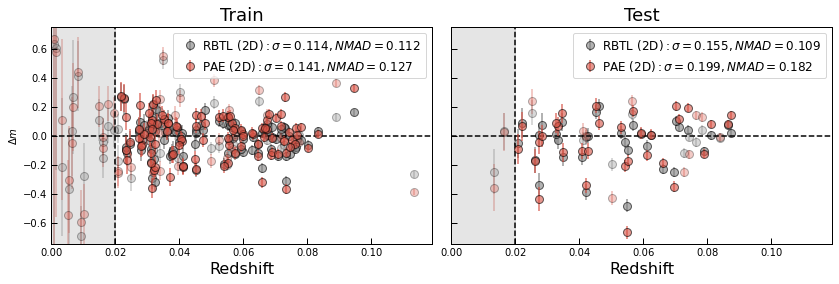

In [14]:
#RBTL vs PAE 2 d
# rbtl_av	rbtl_av_err	rbtl_dm	rbtl_dm_err

# name,iau_name,salt_x1,salt_x1_err,salt_c,salt_c_err,rbtl_av,rbtl_av_err,rbtl_dm,rbtl_dm_err,xi_1,xi_2,xi_3,dm_residuals_twins,dm_residuals_salt,mask_twins,mask_salt
import pandas as pd
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 0

kfold = 0
# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'
# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'#_nooverfit'
# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect'#_longchain'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all_amploss'#_1e-3clip'
file_string = 'layers256-128-32_3stage_train_decorrelate_all_magnitude_nosig_twinscut' #_maxlight'#_1e-3clip'

# file_string = 'layers64-32-16_3stage_train_decorrelate_all'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)

train_data_2d = load_data(train_data_file)
test_data_2d  = load_data(test_data_file)

# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect_longchain_Avvary'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

savefig = True
# savefig = False

save_str = '_twinscut' #_maxlight'

# show_plot_grid = True
show_plot_grid = False

# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'

ms = 8
yminmax = 0.75

alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3:xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']


fig = plt.figure(figsize=(14, 4))

nx = 2
# SALT

for ti, tstr in enumerate(tstrs):
    ax = fig.add_subplot(1, nx, ti+1)
    if ti==0:
        ax.set_ylabel('$\Delta m$')

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    if tstr=='train':
        data = train_data
        data_2d = train_data_2d

        m = '*'
#         dm = np.full(train_data['maximum_likelihood'].shape[0], True, dtype=bool)
#         dm = train_data['maximum_likelihood'] > test_data['maximum_likelihood']

    if tstr=='test':
        m = '*'
        data = test_data
        data_2d = test_data_2d

    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift)

    
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err      

    dl = (1+z)*z
    dl1 = (1+z1)*z1 # don't need leading constant c/H0
    
    mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]

    labels = ['$\Delta m^{PAE}$', '$\Delta A_V^{PAE}$'] + ['$\Delta A_V^{RBTL}$', '$\Delta m^{RBTL}$']

#     c_err = np.exp(data['z_latent_mcmc'][mask_twins][:, -1] + data['z_latent_mcmc_err'][mask_twins][:, -1]) - np.exp(data['z_latent_mcmc'][mask_twins][:, -1])
    arr = np.c_[data['z_latent_mcmc'][in_twins][:, 1:], av_rbtl[in_twins], dm_rbtl[in_twins]]
    err = np.c_[data['z_latent_mcmc_err'][in_twins][:, 1:], av_twins_err[in_twins], dm_twins_err[in_twins]]
    
    # arr[:, 0] *= 50
    err[:, 0] = np.sqrt(err[:,1]**2 + mag_err_vel[in_twins]**2)
    
    arr = arr[dm_redshift[in_twins]]
    err = err[dm_redshift[in_twins]]

#     err = np.c_[data['amplitude_mcmc_err'][in_twins], data['z_latent_mcmc_err'][in_twins][:, 1:-1], c_err, data['dtime_mcmc_err'][in_twins]*50, av_twins_err[in_twins], dm_twins_err[in_twins]]

    if show_plot_grid:
        plot_grid(arr, labels=labels, color_arr=data['redshift'][in_twins], errs=err, #xyminmax=xyminmax,
                  color_label='Redshift', cmap=plt.cm.viridis, figsize=(8,8), s=6,
                  savefig=savefig, filename=figdir+'PAE_vs_RBTL_{:02d}latent_params_{:s}_{:s}.pdf'.format(latent_dim, tstr, save_str))


    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
    


#     wrms_twins =  np.sqrt(np.sum( (dm_twins[in_twins][dm_redshift] - dm_twins[in_twins][dm_redshift].mean())**2 / dm_twins_err[in_twins][dm_redshift]**2) / np.sum(1./dm_twins_err[in_twins][dm_redshift]**2))
#     wrms_hmc =  np.sqrt(np.sum( (data['amplitude_mcmc'][in_twins][dm_redshift]- data['amplitude_mcmc'][in_twins][dm_redshift].mean())**2 / data['amplitude_mcmc_err'][in_twins][dm_redshift]**2) / np.sum(1./data['amplitude_mcmc_err'][in_twins][dm_redshift]**2))
    # mask_performance = in_twins
    mask_performance = mask_twins
    dm_redshift = dm_redshift[mask_performance]

    wrms_resid_salt =  np.std(dm_resid_salt[mask_performance][dm_redshift]) 

    wrms_rbtl =  np.std(dm_rbtl[mask_performance][dm_redshift]) 
    wrms_resid_twins =  np.std(dm_resid_twins[mask_performance][dm_redshift]) 

    wrms_hmc =  np.std(data['amplitude_mcmc'][mask_performance][dm_redshift]) 
    wrms_hmc_2d =  np.std(data_2d['amplitude_mcmc'][mask_performance][dm_redshift]) 

    k_nmad = 1.4826
    
    mad_rbtl   = k_nmad * np.median( np.abs(dm_rbtl[mask_performance][dm_redshift] - np.median(dm_rbtl[mask_performance][dm_redshift]) ))
    mad_hmc    = k_nmad * np.median( np.abs(data['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    mad_hmc_2d = k_nmad * np.median( np.abs(data_2d['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data_2d['amplitude_mcmc'][mask_performance][dm_redshift]) ))
    
    mad_resid_salt  = k_nmad * np.median( np.abs(dm_resid_salt[mask_performance][dm_redshift] - np.median(dm_resid_salt[mask_performance][dm_redshift]) ))
    mad_resid_twins = k_nmad * np.median( np.abs(dm_resid_twins[mask_performance][dm_redshift] - np.median(dm_resid_twins[mask_performance][dm_redshift]) ))
    
#     lab_rbtl  = '$2D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(wrms_rbtl, mad_rbtl)
#     lab_twins  = '$2D+3D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(wrms_resid_twins, mad_resid_twins) 

#     lab_hmc = '${:d}D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format(latent_dim,  wrms_hmc, mad_hmc)
#     lab_hmc_2d = '$2D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format( wrms_hmc_2d, mad_hmc_2d)

#     lab_salt  = r'$3D: ^{{\sigma={:.3f}}}_{{MAD={:.3f}}}$'.format( wrms_resid_salt, mad_resid_salt)
    lab_rbtl  = '$\mathrm{{RBTL\ (2D)}}: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_rbtl, mad_rbtl)
    lab_twins  = '$2D+3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_twins, mad_resid_twins) 

    lab_hmc = '${:d}D: \sigma={:.3f}, NMAD={:.3f}$'.format(latent_dim+2,  wrms_hmc, mad_hmc)
    lab_hmc_2d = '$\mathrm{{PAE\ (2D)}}: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_hmc_2d, mad_hmc_2d)

    lab_salt  = r'$3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_salt, mad_resid_salt)



    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_rbtl[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], dm_rbtl[mask_twins], yerr=dm_twins_err[mask_twins],
                ms=ms, marker='o', label=lab_rbtl, color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=0, alpha=alpha0)


    # 2D
    ax.errorbar(data['redshift'][in_twins & ~mask_twins], data_2d['amplitude_mcmc'][in_twins & ~mask_twins], yerr=np.sqrt(data_2d['amplitude_mcmc_err']**2 + mag_err_vel**2)[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_pae, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data_2d['redshift'][mask_twins], data_2d['amplitude_mcmc'][mask_twins], yerr=np.sqrt(data_2d['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2), 
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc_2d, color=c_pae, ls='none', lw=2, zorder=3, alpha=alpha0) #
 
    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_xlabel('Redshift', fontsize=16)

    ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)
    ax.axhline(0.0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    if ti==1:
        ax.set_yticklabels([])

    ax.set_title(tstr.capitalize(), fontsize=18)

    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if savefig:
    plt.savefig(figdir+'deltamag_vs_rbtl_{:02d}latent_{:s}_{:s}.pdf'.format(latent_dim, tstr, save_str), bbox_inches='tight')
          

DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed0.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed1.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed2.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed3.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed4.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed5.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_seed6.npy (171, 6)
DEBUG  train ../outputs/train_data_kfold0_posterior_03Dlatent_layers256-128-32_3stage_train_decorrelate_all_see

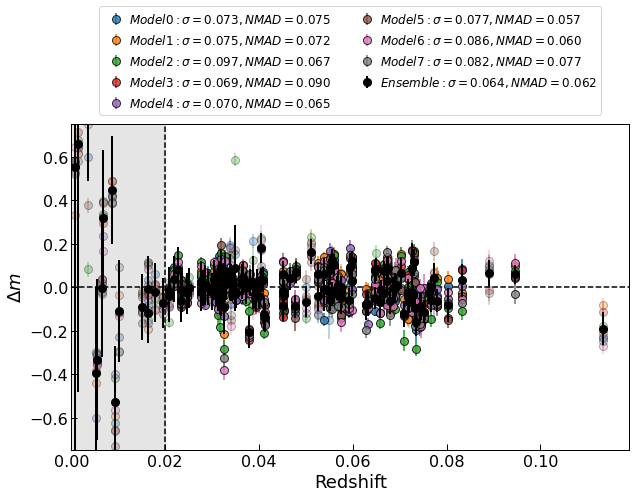

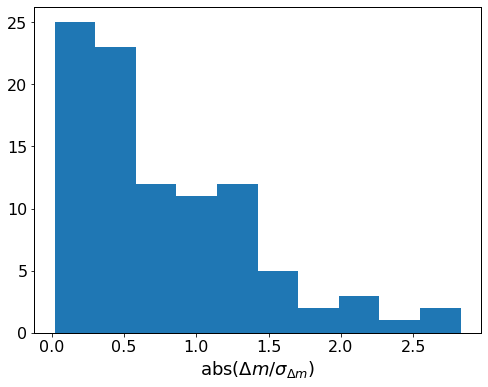

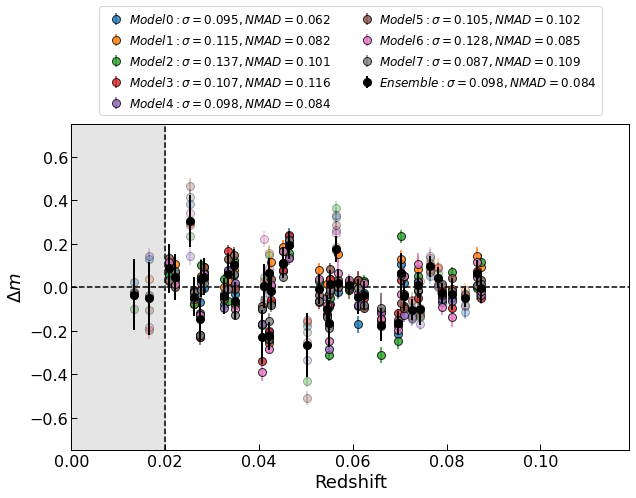

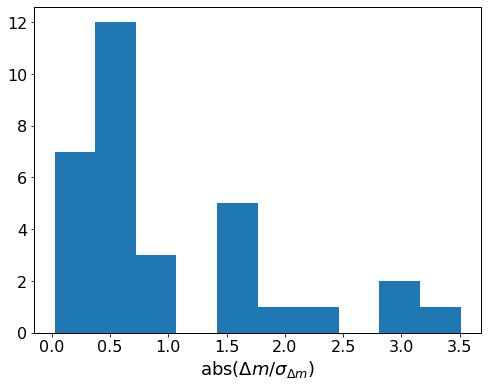

In [29]:
# Does ensembeling help?
# savefig = True
savefig = False

# name,iau_name,salt_x1,salt_x1_err,salt_c,salt_c_err,rbtl_av,rbtl_av_err,rbtl_dm,rbtl_dm_err,xi_1,xi_2,xi_3,dm_residuals_twins,dm_residuals_salt,mask_twins,mask_salt
import pandas as pd
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

# seeds_use = np.arange(8)
seeds_use = np.array([0, 1, 2, 3, 4, 5, 6, 7])#, 8])#, 9])


file_string = "layers256-128-32_3stage_train_decorrelate_all"

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}_seed0_new.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}_seed0_new.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

tstrs = ['train', 'test']

for ti, tstr in enumerate(tstrs):
    if tstr=='train':
        data = train_data
     
    if tstr=='test':
        data = test_data
  
    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True
 
    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err      

    dl = (1+z)*z
    dl1 = (1+z1)*z1 # don't need leading constant c/H0
    
    mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]

    mask_performance = mask_twins


    for iseed, seed in enumerate(seeds_use):
        data_filei = '../outputs/{:s}_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}_seed{:d}.npy'.format(tstr, kfold, 
                                                                                                    latent_dim, file_string,
                                                                                                   seed)

        datai = load_data(data_filei)
        print('DEBUG ', tstr, data_filei, datai['z_latent'].shape)

        if iseed == 0:
            A = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))
            A_err = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))

        A[iseed] = datai['amplitude_mcmc']
        A_err[iseed] = np.sqrt(datai['amplitude_mcmc_err']**2)# + mag_err_vel**2)

    
    # print(A)
#     dm_redshift = dm_redshift[mask_performance]

#     wrms_resid_salt =  np.std(dm_resid_salt[mask_performance][dm_redshift]) 

#     wrms_rbtl =  np.std(dm_rbtl[mask_performance][dm_redshift]) 
#     wrms_resid_twins =  np.std(dm_resid_twins[mask_performance][dm_redshift]) 

#     wrms_hmc =  np.std(data['amplitude_mcmc'][mask_performance][dm_redshift]) 
#     wrms_hmc2 =  np.std(data2['amplitude_mcmc'][mask_performance][dm_redshift]) 
#     wrms_hmc_mean =  np.std((data['amplitude_mcmc'][mask_performance][dm_redshift] + data2['amplitude_mcmc'][mask_performance][dm_redshift])/2) 


#     mad_resid_salt  = k_nmad * np.median( np.abs(dm_resid_salt[mask_performance][dm_redshift] - np.median(dm_resid_salt[mask_performance][dm_redshift]) ))
#     mad_resid_twins = k_nmad * np.median( np.abs(dm_resid_twins[mask_performance][dm_redshift] - np.median(dm_resid_twins[mask_performance][dm_redshift]) ))
    

#     lab_rbtl  = '$2D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_rbtl, mad_rbtl)
#     lab_twins  = '$2D+3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_twins, mad_resid_twins) 

#     lab_hmc2 = '${:d}D: \sigma={:.3f}, NMAD={:.3f}$'.format(latent_dim+2,  wrms_hmc2, mad_hmc)
#     lab_hmc_mean = '${:d}D: \sigma={:.3f}, NMAD={:.3f}$'.format(latent_dim+2,  wrms_hmc_mean, mad_hmc)

#     lab_salt  = r'$3D: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_resid_salt, mad_resid_salt)


    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(1, 1, 1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    # ND
    for iplt in range(A.shape[0]):
        wrms_hmc =  np.std(A[iplt][mask_twins]) 
        lab_hmc = '$Model{:d}: \sigma={:.3f}, NMAD={:.3f}$'.format(iplt,  wrms_hmc, mad_hmc)

        k_nmad = 1.4826
        mad_hmc    = k_nmad * np.median( np.abs(A[iplt][mask_twins] - np.median(A[iplt][mask_twins]) ))

        ax.errorbar(data['redshift'][in_twins & ~mask_twins], A[iplt][in_twins & ~mask_twins], yerr=A_err[iplt][in_twins & ~mask_twins],
                    ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
        ax.errorbar(data['redshift'][mask_twins], A[iplt][mask_twins], yerr=A_err[iplt][mask_twins],
                    ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', label=lab_hmc, ls='none', lw=2, zorder=4, alpha=alpha1) #

    # http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
    weight = 1./A_err**2
    n_eff = np.sum(weight*A, axis=0)**2/np.sum(weight**2, axis=0)

    # A_mean = A.mean(0)
    weighted_mean = np.sum(weight*A, axis=0)/np.sum(weight, axis=0)
    # weighted_err  = np.sqrt(A.shape[0]/(A.shape[0] - 1) *  
    #                         ( np.sum(weight*A**2, axis=0)/np.sum(weight, axis=0) - weighted_mean**2))

    weighted_deviation  = np.sqrt(A.shape[0]/(A.shape[0] - 1) *  
                            ( np.sum(weight*A**2, axis=0)/np.sum(weight, axis=0) - weighted_mean**2))

    weighted_err = weighted_deviation#/np.sqrt(A.shape[0])
    weighted_err = np.sqrt(weighted_err**2 + mag_err_vel**2)

    wrms_hmc =  np.std(weighted_mean[mask_twins], axis=0)

    k_nmad = 1.4826
    mad_hmc = k_nmad * np.median( np.abs(weighted_mean[mask_twins] - np.median(weighted_mean[mask_twins]) ))

    lab_hmc = '$Ensemble: \sigma={:.3f}, NMAD={:.3f}$'.format(wrms_hmc, mad_hmc)

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], weighted_mean[in_twins & ~mask_twins], yerr=weighted_err[in_twins & ~mask_twins],
                    ms=ms, marker='o', color='k', markeredgecolor='k', ls='none', lw=2, alpha=1.0, zorder=100)#alpha_out)
    ax.errorbar(data['redshift'][mask_twins], weighted_mean[mask_twins], yerr=weighted_err[mask_twins],
                    ms=ms, marker='o', color='k', markeredgecolor='k', label=lab_hmc, ls='none', lw=2, alpha=1.0, zorder=100)#alpha1) #

#     ax.errorbar(data2['redshift'][in_twins & ~mask_twins], data2['amplitude_mcmc'][in_twins & ~mask_twins], yerr=np.sqrt(data2['amplitude_mcmc_err']**2 + mag_err_vel**2)[in_twins & ~mask_twins],
#                 ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
#     ax.errorbar(data2['redshift'][mask_twins], data2['amplitude_mcmc'][mask_twins], yerr=np.sqrt(data2['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2),
#                 ms=ms, marker='o', markeredgecolor='k', label=lab_hmc2, color=c_bg, ls='none', lw=2, zorder=4, alpha=alpha1) #

#     ax.errorbar(data['redshift'][in_twins & ~mask_twins], (data['amplitude_mcmc'][in_twins & ~mask_twins]+data2['amplitude_mcmc'][in_twins & ~mask_twins])/2, yerr=np.sqrt(data['amplitude_mcmc_err']**2 + mag_err_vel**2)[in_twins & ~mask_twins],
#                 ms=ms, marker='o', color=c_salt, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
#     ax.errorbar(data['redshift'][mask_twins], (data['amplitude_mcmc'][mask_twins] + data2['amplitude_mcmc'][mask_twins])/2, yerr=np.sqrt(data['amplitude_mcmc_err'][mask_twins]**2 + mag_err_vel[mask_twins]**2),
#                 ms=ms, marker='o', markeredgecolor='k', label=lab_hmc_mean, color=c_salt, ls='none', lw=2, zorder=4, alpha=alpha1) #


    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_xlabel('Redshift')
    ax.set_ylabel('$\Delta m$')

    ax.legend(frameon=True, loc='lower center', 
              fontsize=fontsize, handletextpad=0.05, ncol=2,
             bbox_to_anchor=(0.5, 1.01))#, title=r'$\sigma, NMAD$')
    ax.axhline(0.0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    # ax.set_yticklabels([])

#     ax.set_title('PAE', fontsize=18)

#     plt.subplots_adjust(wspace=0.025, hspace=0.025)

    if savefig:
        plt.savefig(figdir+'deltamag_ensemble_{:02d}latent_{:s}.pdf'.format(latent_dim, tstr), bbox_inches='tight')

    plt.figure(figsize=(8,6))
    plt.hist( np.abs(weighted_mean[mask_twins]/weighted_err[mask_twins]))
    plt.xlabel('abs($\Delta m$/$\sigma_{{\Delta m}}$)')
#     xx = np.linspace(-0.3,0.3,10)
#     plt.figure(figsize=(8, 8))
#     plt.plot(xx,xx, color='k')
#     plt.scatter(data2['amplitude_mcmc'][in_twins & ~mask_twins], data['amplitude_mcmc'][in_twins & ~mask_twins])
#     plt.scatter(data2['amplitude_mcmc'][mask_twins], data['amplitude_mcmc'][mask_twins])
#     # plt.scatter(data2['redshift'][in_twins & ~mask_twins], data2['amplitude_mcmc'][in_twins & ~mask_twins] - data['amplitude_mcmc'][in_twins & ~mask_twins])
#     # plt.scatter(data2['redshift'][mask_twins], data2['amplitude_mcmc'][mask_twins] - data['amplitude_mcmc'][mask_twins])
#     # plt.scatter(data['amplitude_mcmc'][in_twins & ~mask_twins], data2['amplitude_mcmc'][in_twins & ~mask_twins] - data['amplitude_mcmc'][in_twins & ~mask_twins], c=data['redshift'][in_twins & ~mask_twins])
#     # plt.scatter(data['amplitude_mcmc'][mask_twins], data2['amplitude_mcmc'][mask_twins] - data['amplitude_mcmc'][mask_twins], c=data['redshift'][mask_twins])


## Does magnitude residual depend on SN p(z) or p(u) density?

[96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11]


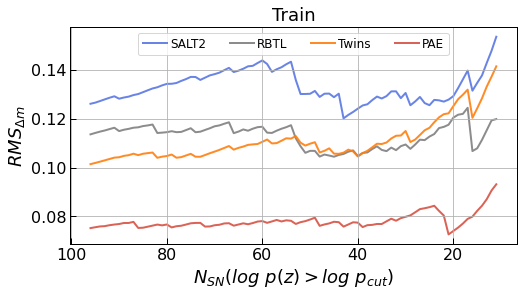

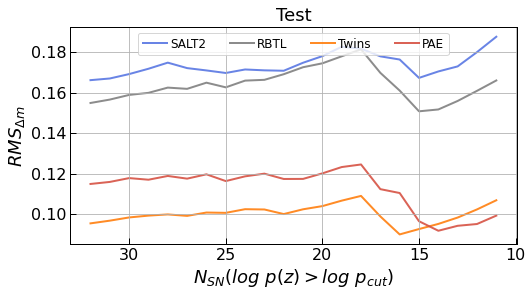

In [49]:
import pandas as pd

# savefig = True
savefig = False

# name,iau_name,salt_x1,salt_x1_err,salt_c,salt_c_err,rbtl_av,rbtl_av_err,rbtl_dm,rbtl_dm_err,xi_1,xi_2,xi_3,dm_residuals_twins,dm_residuals_salt,mask_twins,mask_salt
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

# file_string = 'layers256-128-32_multistage_train_decorrelate_all'#_1e-3clip'
file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed1' #_magnitude_nosig_twinscut_maxlight'   #_1e-3clip'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)


# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

ms = 8
yminmax = 0.75

alpha=0.9
alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3: xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']

grid_xy = 2

use_pz = True
ymin = -15

log_p_cuts = np.linspace(-5, -1, 100) #[-10., -5., -2.]

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

for ti, tstr in enumerate(tstrs):
    if tstr=='train':
        data = train_data
        m = '*'

    if tstr=='test':
        m = '*'
        data = test_data

        
    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    mask_performance = mask_twins

    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err      

    dl = (1+z)*z
    dl1 = (1+z1)*z1 # don't need leading constant c/H0
    
    mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]


    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        # z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
   

    fig = plt.figure(figsize=(8, 4))

    lp_u = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(data['u_latent_mcmc']**2, axis=1)))

    if use_pz:
        lp_u -= data['logJ_u_latent_mcmc']

    lp_u -= lp_u.max()
    lp_u = np.nan_to_num(lp_u, nan=ymin)
    
    # lp_u = lp_u[mask_performance & dm_redshift]
    
    nx = 1
    # SALT
    ax = fig.add_subplot(1, 1, 1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    mask_performance = mask_twins

    inds_keep = np.arange(lp_u.shape[0])

    dm_resid_twins = dm_resid_twins[mask_performance]
    dm_resid_salt = dm_resid_salt[mask_performance]
    dm_rbtl = dm_rbtl[mask_performance]
    dm_pae = data['amplitude_mcmc'][mask_performance]

    lp_u = lp_u[mask_performance]
    inds_keep = inds_keep[mask_performance]

    inds_sort = np.argsort(lp_u)
    inds_lin = np.arange(lp_u.shape[0])

    wrms_resid_salt = []
    wrms_resid_twins = []
    wrms_rbtl = []
    wrms_hmc = []
    n_sn = []
    
    min_num = 10
    for ind_min in range(inds_sort.shape[0]-min_num):#, 0, -1):
        dm = inds_sort >= ind_min
        
        n_sn.append(dm.sum())

        wrms_resid_salt.append(np.std(dm_resid_salt[dm]) )

        wrms_rbtl.append(np.std(dm_rbtl[dm]) )
        wrms_resid_twins.append(np.std(dm_resid_twins[dm]) )
        
        wrms_hmc.append(np.std(dm_pae[dm]) )

    print(n_sn)
    ax.plot(n_sn, wrms_resid_salt,
                ms=ms, 
                color=c_salt, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='SALT2')

    ax.plot(n_sn, wrms_rbtl,
                ms=ms, 
                color=c_bg, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='RBTL')

    ax.plot(n_sn, wrms_resid_twins,
                ms=ms, 
                color=c_twins, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='Twins')

    ax.plot(n_sn, wrms_hmc,
                ms=ms, 
                color=c_pae, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='PAE')

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.grid()
    # ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_xlabel('$N_{SN}(log\ p(z) > log\ p_{cut})$')
    ax.set_ylabel('$RMS_{\Delta m}$')
    
    ax.legend(frameon=True, loc='upper center', 
              fontsize=fontsize, handletextpad=0.25, ncol=4,
             bbox_to_anchor=(0.5, 1.00))#, title=r'$\sigma, NMAD$')
    # ax.axhline(0.0, color='k', ls='--')
    # ax.axvline(min_train_redshift, color='k', ls='--')

    # ax.set_xlim(0,0.119)
    # ax.set_ylim(-yminmax,yminmax)
    # ax.set_yticklabels([])

    ax.set_title(tstr.capitalize(), fontsize=18)

    if savefig:
        plt.savefig(figdir+'deltamag_vs_density_{:02d}latent_{:s}.pdf'.format(latent_dim, tstr), bbox_inches='tight')
          

# Anomaly Detection

In [22]:
latent_dim = 3
# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect'#_longchain'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all'#_longchain_Avvary'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all'#_longchain'

# train_data_file = '../outputs/train_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)
# test_data_file  = '../outputs/test_data_kfold{:d}_posterior_00Dlatent_{:s}.npy'.format(kfold, file_string)

# train_data_2d = load_data(train_data_file)
# test_data_2d  = load_data(test_data_file)

# file_string = 'layers256-128-32_3stage_train_decorrelate_all_reverse_2_longchain'
file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00

params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False


In [23]:
weird = ['SNF20070528-003', 
'SNF20070912-000', 
'SNF20080723-012', 
'SN2009ig',        
'SN2005di',        
'SNF20061009-008', 
'SNF20071001-005',
        ]
np.isin(test_data['names'], weird)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [24]:
# load in data for peculiar galaxies
peculiar_sn = np.genfromtxt('../data/peculiar_sn.txt', delimiter='\t', dtype=None, names=('name', 'peculiar_type'))
peculiar_sn_names = [peculiar_sn[i][0].split()[0].decode("utf-8") for i in range(peculiar_sn.shape[0])]
peculiar_sn_types = [peculiar_sn[i][0].split()[1].decode("utf-8") for i in range(peculiar_sn.shape[0])]

print(peculiar_sn_names)
print(peculiar_sn_types)

train_data['sn_type'] = ['normal']*len(train_data['names'])
test_data['sn_type'] = ['normal']*len(test_data['names'])

for n, t in zip(peculiar_sn_names, peculiar_sn_types):
    
    if n in train_data['names']:
        ind = np.argwhere(train_data['names']==n)[0][0]
        train_data['sn_type'][ind] = t
 
    if n in test_data['names']:
        ind = np.argwhere(test_data['names']==n)[0][0]
        test_data['sn_type'][ind] = t
    

['SNF20070528-003', 'SNF20070803-005', 'SNF20070825-001', 'SNF20070912-000', 'SNF20080522-000', 'SNF20080723-012', 'SNF20080805-007', 'LSQ12cyz', 'LSQ12fhe', 'PTF11bju', 'PTF11mkx', 'LSQ12cfx', 'PTF10ops', 'PTF11bkf', 'PTF11kjn', 'PTF11okh', 'PTF11pra', 'PTF12dwm', 'SN2005bl', 'SN2005dh', 'SN2005dm', 'SN2007ba', 'SN2009hs', 'SNNGC6430', 'SN2005cc', 'SNBOSS38', 'SN2012dn', 'SNNGC2691', 'SN2011hr', 'SN2006X']
['91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '02cx-like', '09dc-like', '09dc-like', '91T-like', '91T-like', 'extreme']


<ipython-input-24-4a14c1e0332c>:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  peculiar_sn = np.genfromtxt('../data/peculiar_sn.txt', delimiter='\t', dtype=None, names=('name', 'peculiar_type'))


In [26]:
np.argwhere(train_data['names'] == "SNPGC51271")

array([[102]])

In [18]:
# change SN names from internal to external
sn_names = np.genfromtxt('../data/name_convention_sn.txt', delimiter='\t', dtype=None, names=('name_in', 'name_out'))
names_in = [sn_names[i][0].split()[0].decode("utf-8") for i in range(sn_names.shape[0])]
names_out = [sn_names[i][0].split()[1].decode("utf-8") for i in range(sn_names.shape[0])]

print(names_in, names_out)
train_names_in = train_data['names']
train_names_out = train_data['names']

test_names_in = test_data['names']
test_names_out = test_data['names']

for n_in, n_out in zip(names_in, names_out):
    
    if n_in in train_data['names']:
        print('name change train ', n_in, n_out)
        ind = np.argwhere(train_data['names']==n_in)[0][0]
        train_names_out[ind] = n_out
 
    if n_in in test_data['names']:
        print('name change test ', n_in, n_out)
        ind = np.argwhere(test_data['names']==n_in)[0][0]
        test_names_out[ind] = n_out
 
train_data['names'] = train_names_out
test_data['names'] = test_names_out

['Boles130718', 'CSS110918_01', 'CSS110918_02', 'PQOT0241-0338', 'PTF09dro', 'SDSS16392', 'SN2007pip', 'SN7876', 'SNBOSS38', 'SNhunt281', 'SNhunt46', 'SNhunt89', 'SNIC219', 'SNIC3573', 'SNISSP120630', 'SNNGC0927', 'SNNGC1401', 'SNNGC2370', 'SNNGC2691', 'SNNGC2891', 'SNNGC4076', 'SNNGC4424', 'SNNGC6343', 'SNNGC6430', 'SNNGC6619', 'SNNGC6801', 'SNNGC6956', 'SNNGC7364', 'SNNGC7589', 'SNPGC027923', 'SNPGC1354027', 'SNPGC51271', 'SNUGC11797', 'SNUGC12809', 'SNUGC2384', 'SNUGC2855', 'UT-06-2-015', 'WL2007ge'] ['SN2013ed', 'SN2011gf', 'SN2011ga', 'SN2007no', 'SN2009ih', 'SN2006ob', 'SN2007qe', 'SN2005ir', 'SN2012dn', 'AT2015bp', 'SN2011be', 'SN2011ho', 'SN2005dm', 'SN2013be', 'SN2012df', 'PSNJ02263653+120855', 'SN2011iv', 'PSNJ07250042+234703', 'SN2011hr', 'SN2013cg', 'SN2011bc', 'SN2012cg', 'SN2013bs', 'SN2012ea', 'SN2012dz', 'SN2011df', 'PSNJ20435314+123030', 'SN2011im', 'SN2011hv', 'SN2011ia', 'SN2011io', 'SN2013bt', 'SN2015N', 'SN2011iu', 'SN2006os', 'SN2014dg', 'SN2006cj', 'SN2007ge']
na

<ipython-input-18-2570f6ec21df>:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sn_names = np.genfromtxt('../data/name_convention_sn.txt', delimiter='\t', dtype=None, names=('name_in', 'name_out'))


In [106]:
#recheck SN types given SN name can have been updated 
for n, t in zip(peculiar_sn_names, peculiar_sn_types):
    
    if n in train_data['names']:
        ind = np.argwhere(train_data['names']==n)[0][0]
        train_data['sn_type'][ind] = t
 
    if n in test_data['names']:
        ind = np.argwhere(test_data['names']==n)[0][0]
        test_data['sn_type'][ind] = t
    

In [107]:
train_data['sn_type'] = np.array(train_data['sn_type'])
test_data['sn_type']  = np.array(test_data['sn_type'])

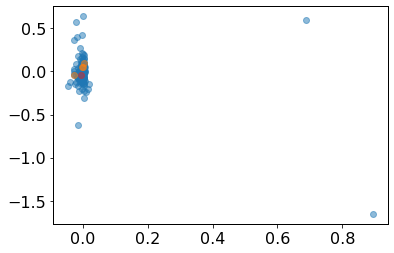

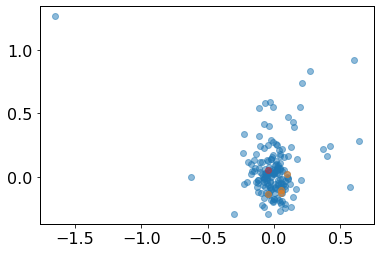

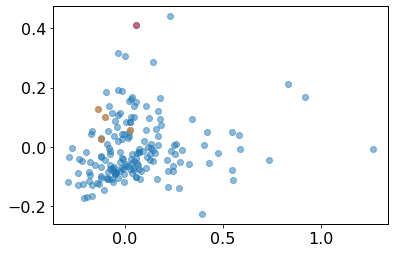

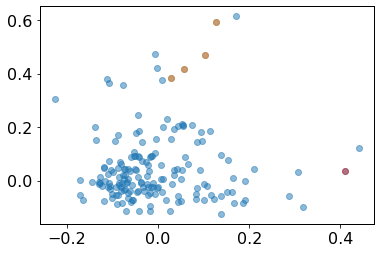

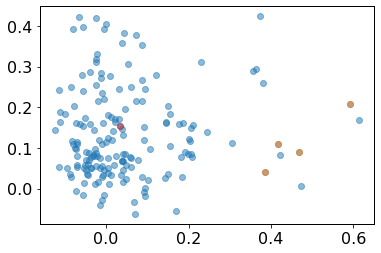

In [108]:
# plot sn belonging to types

data = train_data
# data = test_data
dm_T = data['sn_type'] == '91T-like'
dm_bg = data['sn_type'] == '91bg-like'

for j in range(data['z_latent_mcmc'].shape[1] - 1):
    plt.figure()
    plt.scatter(data['z_latent_mcmc'][:, j], data['z_latent_mcmc'][:, j+1], alpha=0.5)
    plt.scatter(data['z_latent_mcmc'][dm_T, j], data['z_latent_mcmc'][dm_T, j+1], alpha=0.5, c='C1')
    plt.scatter(data['z_latent_mcmc'][dm_bg, j], data['z_latent_mcmc'][dm_bg, j+1], alpha=0.5, c='C3')

    # plt.xlim(-20,20)
    # plt.ylim(-20,20)
    # plt.xlabel(labels[j])
    # plt.ylabel(labels[j+1])
 

-36.575653 -8.303856
[ 17  51  88 170  98 113  68 149 112  77 129  53  90   4  85  19  65 127
  89  16 138  67 123   3 106  48  15 146  94 147 128 120 159  83 142 130
  45  59 166 162 167 139 135 148 119  78  43   8  72 116  26  84  86 115
  57 133  63 152   9  71 111 107  20 108  50 153  28  91 140 121   5  40
 114  35  27   1  18  34 126  66 137 150  44 158  97   0  41  60 144 100
  95  56 103 155 136  25 131  22 169 151  12 164  29  99  62  93  79   7
 163  73 104 105  64   2 134 122  47 145  30 165 157  96 124  55  10  70
 161  23 102  80   6  14  76  39  69 154  42  49 101 160 132  11  81 117
  31  37  32  33 118 156 143  21 141  38  46  74 110 125  92  82  24  36
  75  87  58  13 109 168  61  54  52]
[[88]]
[]


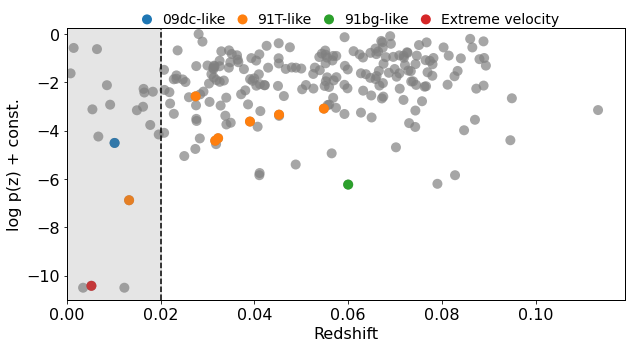

In [109]:
import matplotlib.patheffects as pe

# savefig=True
savefig=False

# use_pz = False
use_pz = True

fontsize = 12
text_rotation_angle = -30
text_lw = 2

dx = 0.0005
dy_max = 0.25
dy_min = 0.5

nplt_train = 3
nplt_test = 3
nplt_train_max = 4
nplt_test_max = 0

ms = 100

fontsize_label=16

alpha_train = 0.7
alpha_test = 0.7
alpha_pec = 1.0

ymin = -11
ymax = 0

peculiar_colors = ['C0', 'C1', 'C2', 'C3']
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
# 2D
print(train_data['logp_u_latent_mcmc'].min(), test_data['logp_u_latent_mcmc'].min())

p_u_train = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(train_data['u_latent_mcmc']**2, axis=1)))
p_u_test  = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(test_data['u_latent_mcmc']**2, axis=1)))

if use_pz:
    p_u_train -= train_data['logJ_u_latent_mcmc']
    p_u_test  -= test_data['logJ_u_latent_mcmc']

p_u_train = np.nan_to_num(p_u_train, nan=ymin)
p_u_test = np.nan_to_num(p_u_test, nan=ymin)

pmax = max(p_u_train.max(), p_u_test.max())

inds_train = np.argsort(p_u_train)#[::-1]
inds_test = np.argsort(p_u_test)#[::-1]

inds_train_max = np.argsort(p_u_train)[::-1]
inds_test_max = np.argsort(p_u_test)[::-1]

p_u_train -= pmax
p_u_test -= pmax

dm_test = p_u_test == False
dm_train = p_u_train == False

p_u_test[p_u_test < ymin+dy_min] = ymin+dy_min
p_u_train[p_u_train < ymin+dy_min] = ymin+dy_min

dm_train[p_u_train < ymin+dy_min] = True
dm_test[p_u_test < ymin+dy_min] = True

# z_train = train_data['redshift']
# z_test  = train_data['redshift']

ax.scatter(train_data['redshift'], p_u_train, edgecolor='none', color='gray', alpha=alpha_train, s=ms)
ax.scatter(test_data['redshift'], p_u_test, edgecolor='none', color='gray', alpha=alpha_test, s=ms)

peculiar_strings = sorted(np.unique( np.concatenate((train_data['sn_type'], test_data['sn_type']))))
ic = 0
for i, peculiar_string in enumerate(peculiar_strings):
    if peculiar_string not in ['normal']:
        dm_train = train_data['sn_type'] == peculiar_string
        dm_test = test_data['sn_type'] == peculiar_string

        if peculiar_string == 'extreme':
            peculiar_string = 'Extreme velocity'
            
        ax.scatter(train_data['redshift'][dm_train], p_u_train[dm_train], 
                   edgecolor='none', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)
        
    
        ax.scatter(test_data['redshift'][dm_test], p_u_test[dm_test],
                   label=peculiar_string, edgecolor='none', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)

#         for i, name in enumerate(train_data['names'][dm_train]):
#             ax.annotate(name, (dx+train_data['redshift'][dm_train][i], p_u_train[dm_train][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                              path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
#             # txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            
#         for i, name in enumerate(test_data['names'][dm_test]):
#             ax.annotate(name, (dx+test_data['redshift'][dm_test][i], p_u_test[dm_test][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])

                
        ic+=1
# peculiar_string = '91bg-like'
# dm_train = train_data['sn_type'] == peculiar_string
# dm_test = test_data['sn_type'] == peculiar_string

# ax.scatter(train_data['redshift'][dm_train], train_data['logp_u_latent_mcmc'][dm_train], 
#            label=peculiar_string, edgecolor='k', color=peculiar_colors[1], alpha=0.5)
# ax.scatter(test_data['redshift'][dm_test], test_data['logp_u_latent_mcmc'][dm_test],
#            edgecolor='k', color=peculiar_colors[1], alpha=0.9)

# dm_train = train_data['sn_type'] == '09dc-like'
# dm_test = test_data['sn_type'] == '09dc-like'

# dm_train = train_data['sn_type'] == '02cx-like'
# dm_test = test_data['sn_type'] == '02cx-like'

# ax.scatter(train_data['redshift'][dm_train], train_data['logp_u_latent_mcmc'][dm_train], label='Train', edgecolor='k', color='b', alpha=0.5)
# ax.scatter(test_data['redshift'][dm_test], test_data['logp_u_latent_mcmc'][dm_test], label='Test', edgecolor='k', color='b', alpha=0.9)


ax.axvspan(0, params['min_train_redshift'], alpha=0.2, color='gray')
ax.set_xlabel('Redshift', fontsize=fontsize_label)

ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.105), 
          fontsize=fontsize_label-2, handletextpad=0.05, ncol=4, columnspacing=0.25)
ax.axvline(params['min_train_redshift'], color='k', ls='--')

ax.set_xlim(0,0.119)
ax.set_ylim(ymin, ymax+dy_max)
#
# ax.set_ylim(-yminmax,yminmax)

if use_pz:
    ax.set_ylabel('log p(z) + const.', fontsize=fontsize_label)
else:
    ax.set_ylabel('log p(u) + const.', fontsize=fontsize_label)
    
plt.subplots_adjust(wspace=0.025, hspace=0.025)


print(inds_train)
inds_lin = np.arange(inds_train.shape[0]+inds_test.shape[0])

# for i, name in enumerate(train_data['names'][inds_train][:nplt_train]):
#     ax.annotate(name, (dx+train_data['redshift'][inds_train][i], p_u_train[inds_train][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
                
# for i, name in enumerate(test_data['names'][inds_test][:nplt_test]):
#     ax.annotate(name, (dx+test_data['redshift'][inds_test][i], p_u_test[inds_test][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
     
# for i, name in enumerate(train_data['names'][inds_train_max][:nplt_train_max]):
#     ax.annotate(name, (dx+train_data['redshift'][inds_train_max][i], p_u_train[inds_train_max][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
                
# for i, name in enumerate(test_data['names'][inds_test_max][:nplt_test_max]):
#     ax.annotate(name, (dx+test_data['redshift'][inds_test_max][i], p_u_test[inds_test_max][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
     

inds_below = np.argwhere(dm_train == True)
print(inds_below)

inds_below = np.argwhere(dm_test == True)
print(inds_below)

# print(dm_train)
# print(dm_test)


if savefig:
    if use_pz:
        plt.savefig('../figures/log_pz_all.pdf', bbox_inches='tight')     
    else:
        plt.savefig('../figures/log_pu_all.pdf', bbox_inches='tight')     

                


# dm_redshift_train = (data_train['redshifts'] > train_data['min_train_redshift']) & \
#               (data_train['redshifts'] < train_data['max_train_redshift'])



(228, 4) (228, 4)


<ipython-input-110-82716bc00e83>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)
<ipython-input-110-82716bc00e83>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)
<ipython-input-110-82716bc00e83>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)


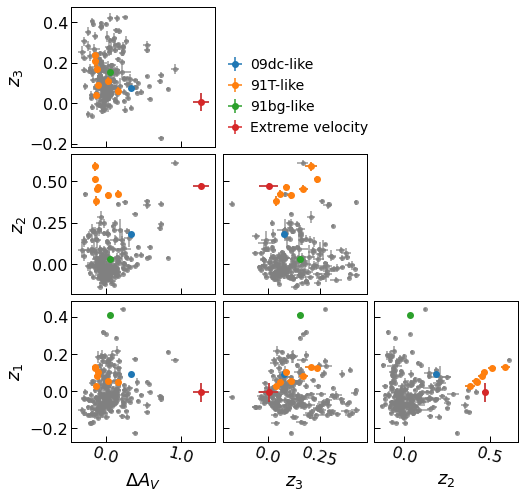

In [110]:
import matplotlib.gridspec as gridspec

savefig = False
# savefig = True

def plot_grid(data, labels=None, errs=None, names=None, sn_type=None, color_arr=None, color_label=None, xyminmax=None,
              figsize=(8,8), spacing=0.05, s=30, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False):
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    nx = data.shape[1]-1
    ny = data.shape[1]-1

    if labels is None:
        labels = ['z_{:d}'.format(i) for i in range(data.shape[1])]
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=ny, nrows=nx, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    peculiar_colors = ['C0', 'C1', 'C2', 'C3']

    if cmap is None:
        cmap = plt.cm.viridis
       
    for i in range(nx):
        for j in range(i, ny):
            
            ii = ny-j
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[j, i])
            if color_arr is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr.min(), color_arr.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels[ii])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels[jj])
            else:
                ax.set_xticklabels([])

            if color_arr is None:
                if errs is None:
                    ax.scatter(data[:, jj], data[:, ii], s=s, alpha=alpha, rasterized=rasterized)
                else:
                    ax.errorbar(data[:, jj], data[:, ii], xerr=errs[:, jj], yerr=errs[:, ii], marker='o', color='gray',
                                ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none', zorder=-1)
                    
                    peculiar_strings = ['09dc-like', '91T-like', '91bg-like', 'extreme', 'normal']
                    ic = 0
                    for ipec, peculiar_string in enumerate(peculiar_strings):
                        if peculiar_string not in ['normal']:
                            dm = sn_type == peculiar_string

                            if peculiar_string == 'extreme':
                                peculiar_string = 'Extreme velocity'

                            ax.errorbar(data[dm, jj], data[dm, ii], xerr=errs[dm, jj], yerr=errs[dm, ii], marker='o', color=peculiar_colors[ic],
                                ms=s+2, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none', alpha=alpha_pec, label=peculiar_string)
                    
                            # ax.scatter(data[dm, jj], data[dm, ii], 
                            #            edgecolor='k', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)

                            # for iii, name in enumerate(names[dm]):
                            #     ax.annotate(name, (dx+data[dm, jj][iii], data[dm, ii][iii]),
                            #         fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
                            #                      path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])

                            ic += 1
            else:
                if errs is None:
                    c = ax.scatter(data[:, jj], data[:, ii], s=s, c=color_arr, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                else:
                    carr = (color_arr-color_arr.min())/(color_arr.max()-color_arr.min())
                    for ierr in range(data[:, jj].shape[0]):
                        ax.errorbar(data[ierr, jj], data[ierr, ii], xerr=errs[ierr, jj], yerr=errs[ierr, ii], markeredgecolor=markeredgecolor,
                                    color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                     lw=2)


            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
                
            if j == ny-1:
                ax.set_xticklabels(ax.get_xticks(), rotation=-15)
            if i == nx//2 and j==ny//2:
                ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1.05), 
                          fontsize=fontsize_label-2, handletextpad=0.05, ncol=1, columnspacing=0.25)                
    if color_arr is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')
        
        

filename = '../figures/grid_PAE_{:d}Dlatent_peculiar_all.pdf'.format(latent_dim)

# latent = 'u_latent_mcmc'
latent = 'z_latent_mcmc'

data = {}
data['names'] = np.concatenate((train_data['names'], test_data['names']), axis=0)
data['sn_type'] = np.concatenate((train_data['sn_type'], test_data['sn_type']), axis=0)
data['z_latent_mcmc'] = np.concatenate((train_data[latent], test_data[latent]), axis=0)
data['z_latent_mcmc_err'] = np.concatenate((train_data[latent+'_err'], test_data[latent+'_err']), axis=0)

if latent == 'z_latent_mcmc':
    data['z_latent_mcmc'][:,0] *= 50 #days
    data['z_latent_mcmc_err'][:,0]  *= 50 #days

data['redshift'] = np.concatenate((train_data['redshift'], test_data['redshift']), axis=0)
data['times_orig'] = np.concatenate((train_data['times_orig'], test_data['times_orig']), axis=0)


# dm = get_train_mask(data, params)
dm = np.full(data['redshift'].shape[0], True, dtype=bool)

names = data['names'][dm]
sn_type = data['sn_type'][dm]

istart = 0
labels = ['$u_{:d}$'.format(i+1) for i in range(data['z_latent_mcmc'].shape[1])]
if latent == 'z_latent_mcmc':
    istart = 2
    labels = ['$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]

arr_use = data['z_latent_mcmc'][dm, istart:]
err_use = data['z_latent_mcmc_err'][dm, istart:]


print(arr_use.shape, err_use.shape)
# labels = np.roll(labels, -1)
# arr_use = np.roll(arr_use, -1, axis=1)
# err_use = np.roll(err_use, -1, axis=1)

plot_grid(arr_use, errs=err_use, names=names, sn_type=sn_type, 
          labels=labels, savefig=savefig, filename=filename,
         figsize=(8, 8), s=5, alpha=0.8, markeredgecolor='none') 


# ax.scatter(train_data['redshift'], p_u_train, edgecolor='k', color='gray', alpha=alpha_train, s=ms)
# ax.scatter(test_data['redshift'], p_u_test, edgecolor='k', color='gray', alpha=alpha_test, s=ms)



In [120]:
arr_use.shape, names.shape
ind_use = 2
dm = arr_use[:, ind_use] > 0.3

ind_sort = np.argsort(arr_use[dm][:, ind_use])[::-1]
print(ind_sort)
arr_use[dm][ind_sort], names[dm][ind_sort], sn_type[dm][ind_sort]

'SN2012cu', 'LSQ12cyz', 'PTF11mkx', 'SN2006X', 'SNF20070803-005',
        'LSQ12fhe', 'SN2011hr', 'LSQ12gdj', 'PTF11bju', 'SNF20080522-000',
        'SNF20080720-001', 'PTF10ygu', 'PSNJ07250042+23', 'SN2007le',
        'SNF20060624-019', 'LSQ12gxj'

[ 1  8 12  6 10 14 13  3  7 11  2  5 15  0  9  4]


(array([[ 0.92259777,  0.16979432,  0.61394554,  0.16741659],
        [-0.13807665,  0.12768789,  0.59067297,  0.20680031],
        [-0.14589068,  0.12466559,  0.51285934,  0.23703186],
        [ 1.2661036 , -0.00702261,  0.47255805,  0.00557441],
        [-0.10101726,  0.10191999,  0.46794185,  0.0892588 ],
        [-0.1215545 ,  0.08092345,  0.45675313,  0.17004497],
        [ 0.15789779,  0.05188501,  0.4272334 ,  0.06029901],
        [-0.26985002, -0.00238724,  0.42179942,  0.08351187],
        [ 0.02572247,  0.05721979,  0.41753143,  0.10961258],
        [-0.12328086,  0.02723964,  0.38455296,  0.04068903],
        [ 0.5501358 , -0.11293382,  0.38118976,  0.2606165 ],
        [ 0.25996304,  0.00789457,  0.37428534,  0.42363667],
        [ 0.7327726 , -0.03233537,  0.3668012 , -0.17325014],
        [ 0.16471212, -0.10867302,  0.3637698 ,  0.29298946],
        [ 0.54594874, -0.07715168,  0.35610455,  0.2878103 ],
        [ 0.3913789 , -0.22665088,  0.30646902,  0.11245347]],
       

In [61]:
#Weird SN
SNF20070528-003 
SNF20070912-000 
SNF20080723-012 
SN2009ig        
SN2005di        
SNF20061009-008 
SNF20071001-005

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-61-30527ecd6719>, line 2)

# Look at high and low density spectra

shape (171, 6)
SN2012cu -10.5


NameError: name 'plot_spectra_map' is not defined

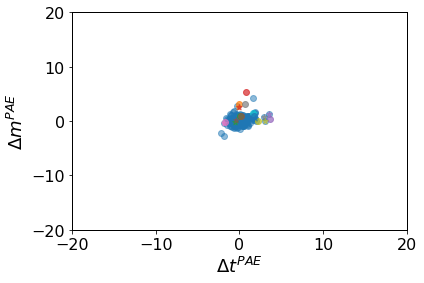

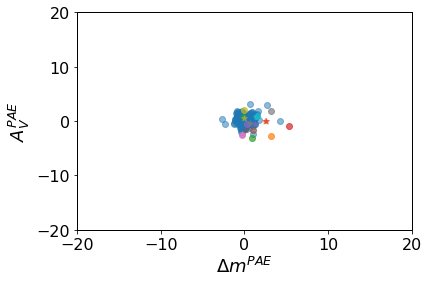

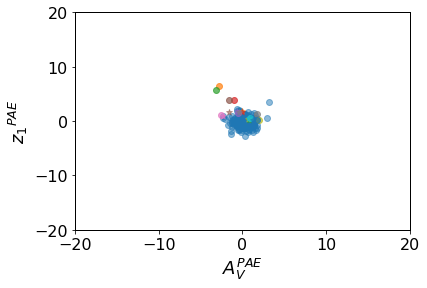

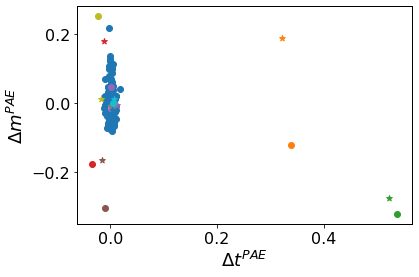

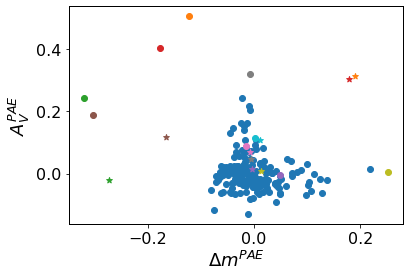

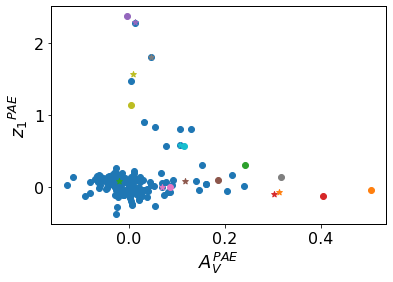

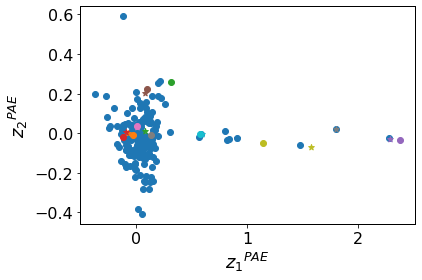

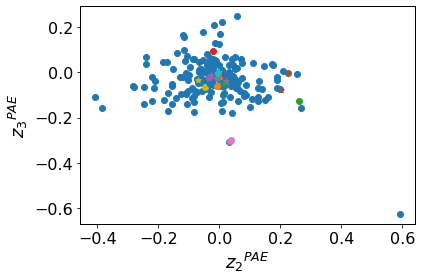

In [34]:
# savefig = True 
savefig = False

nplt = 10
print('shape', train_data['z_latent_mcmc'].shape)

latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]
labels = ['$\Delta t^{PAE}$', '$\Delta m^{PAE}$', '$A_V^{PAE}$'] + latent
    
for j in range(train_data['u_latent_mcmc'].shape[1] - 1):
    plt.figure()
    plt.scatter(train_data['u_latent'][:, j], train_data['u_latent'][:, j+1], alpha=0.5)
    for i in range(nplt):
        ind = inds_lin[inds_train][i]
        # print('log p ', train_data['names'][ind], train_data['logp_u_latent_mcmc'][ind], train_data['logp_u_latent_map'][ind])
        plt.scatter(train_data['u_latent_map'][ind, j], train_data['u_latent_map'][ind, j+1], color='C{:d}'.format(i+1), marker='*', alpha=0.57)
        plt.scatter(train_data['u_latent_mcmc'][ind, j], train_data['u_latent_mcmc'][ind, j+1], color='C{:d}'.format(i+1), alpha=0.7)
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.xlabel(labels[j])
    plt.ylabel(labels[j+1])
 
for j in range(train_data['z_latent_mcmc'].shape[1] - 1):
    plt.figure()
    plt.scatter(train_data['z_latent'][:, j], train_data['z_latent'][:, j+1])
    for i in range(nplt):
        ind = inds_lin[inds_train][i]
        # print('log p ', train_data['names'][ind], train_data['logp_z_latent_mcmc'][ind], train_data['logp_z_latent_map'][ind])
        plt.scatter(train_data['z_latent_map'][ind, j], train_data['z_latent_map'][ind, j+1], color='C{:d}'.format(i+1), marker='*')
        plt.scatter(train_data['z_latent_mcmc'][ind, j], train_data['z_latent_mcmc'][ind, j+1], color='C{:d}'.format(i+1))
    plt.xlabel(labels[j])
    plt.ylabel(labels[j+1])
    
nplt = 2
plttypes = ['normal', 'residual']

for i in range(nplt):
    print(train_data['names'][inds_train][i], p_u_train[inds_train][i])
    plot_spectra_map(train_data, spec2='PAE', ispec=inds_lin[inds_train][i], train=False, savefig=savefig, tstr='train_low_density{:03d}'.format(i), plttypes=plttypes)
    # plot_spectra_map(test_data, ispec=iplt, spec1='salt2', spec2='pae', train=False, savefig=savefig, tstr='test', plttypes=['normal', 'residual'])
    print(train_data['spectra'][inds_lin[inds_train][i]])
    print(inds_lin[inds_train_max][i])
    
print('TEST')
for i in range(nplt):
    print(test_data['names'][inds_test][i], p_u_test[inds_test][i])
    plot_spectra_map(test_data, spec2='PAE', ispec=inds_lin[inds_test][i], train=False, savefig=savefig, tstr='test_hlowdensity{:03d}'.format(i), plttypes=plttypes)
    print(inds_lin[inds_test_max][i])



for i in range(nplt):
    print(train_data['names'][inds_train_max][i], p_u_train[inds_train_max][i])
    plot_spectra_map(train_data, spec2='PAE', ispec=inds_lin[inds_train_max][i], train=False, savefig=savefig, tstr='train_high_density{:03d}'.format(i), plttypes=plttypes)
    # plot_spectra_map(test_data, ispec=iplt, spec1='salt2', spec2='pae', train=False, savefig=savefig, tstr='test', plttypes=['normal', 'residual'])

    print(inds_lin[inds_train_max][i])
    
print('TEST')
for i in range(nplt):
    print(test_data['names'][inds_test_max][i], p_u_test[inds_test_max][i])
    plot_spectra_map(test_data, spec2='PAE', ispec=inds_lin[inds_test_max][i], train=False, savefig=savefig, tstr='test_high_density{:03d}'.format(i), plttypes=plttypes)
    print(inds_lin[inds_test_max][i])

# Old Analyses and Plots

# Fit Gaussian to data

Train mean : -0.092487, var : 0.230465


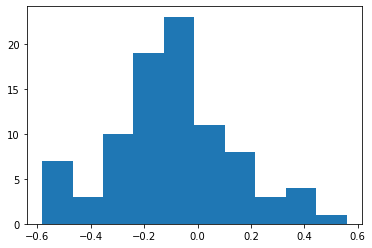

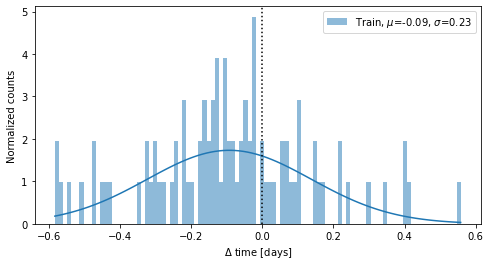

In [9]:
import numpy as np
import sklearn
import sklearn.mixture
from scipy.stats import norm
import matplotlib.pyplot as plt

# np.save('dt_train', data_fit)
data_fit = np.load('dt_train.npy')
dm = (data_fit > -0.6) & (data_fit < 0.6)
data_fit = data_fit[dm]

plt.hist(data_fit)

dt_bins = np.linspace(data_fit.min(), data_fit.max(), 100)


gmm = sklearn.mixture.GaussianMixture()

r_train = gmm.fit(data_fit[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
gmm_mean_train =  r_train.means_[0, 0]
gmm_std_train = np.sqrt(r_train.covariances_[0, 0])
print("Train mean : %f, var : %f" % (gmm_mean_train, gmm_std_train))


plt.figure(figsize=(8,4))

plt.hist(data_fit, bins=dt_bins, alpha=0.5, color='C0', density=True, label='Train, $\mu$=%.2f, $\sigma$=%.2f'%(gmm_mean_train, gmm_std_train))

xx = np.linspace(data_fit.min(), data_fit.max(), 100)
plt.plot(xx, norm.pdf(xx, gmm_mean_train, gmm_std_train), color='C0')

plt.axvline(0, color='k', ls=':')

plt.xlabel('$\Delta$ time [days]')
plt.ylabel('Normalized counts')

plt.legend(loc='upper right')


nan nan
(47, 288) (47,)
(196, 288) (196,)
(238, 288) (238,)
(289, 288) (289,)
(284, 288) (284,)
(250, 288) (250,)
(226, 288) (226,)
(214, 288) (214,)
(151, 288) (151,)
(134, 288) (134,)
(70, 288) (70,)
[-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05]
(288, 11)


<ipython-input-165-54cec18ca0c7>:47: RuntimeWarning: invalid value encountered in true_divide
  mse = np.abs((s0 - s1))/np.abs(s1) #np.abs(s1) #/np.abs(s0)
/global/homes/g/gstein/.conda/envs/tfp/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Figure size 432x288 with 0 Axes>

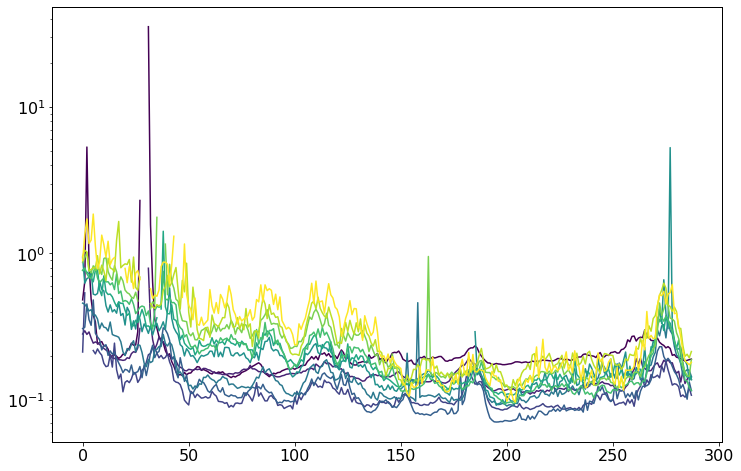

In [165]:
from scipy.signal import savgol_filter

def compute_sigma_ae_time(spec_true, spec_pred, sigma, time, mask, weighted=False, outlier_cut=100, relative=True):
    """Calculate std of true and reconstructed spectra as a function of time                                           
                                                                                                                       
    Parameters                                                                                                         
    ----------                                                                                                         
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                   
       measured spectra                                                                                                
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                   
       model spectra                                                                                                   
    sigma: array (N_sn, n_timesamples, data_dim)                                                                       
       measurement uncertainty                                                                                         
    time: array (N_sn, n_timesamples)                                                                                  
       observation time                                                                                                
    """

    dm = mask[:, :, 0] == 1.

    dtbin = 0.1
    tmax = 1.0
    tmin = 0.0

    ntbins = int((tmax-tmin)//dtbin)+2

    t_bin_edge = np.linspace(tmin-dtbin/2, tmax+dtbin/2, ntbins+1)
    t_bin_cent = (t_bin_edge[:-1] + t_bin_edge[1:])/2

    s0 = spec_true[dm].copy()
    s1 = spec_pred[dm].copy()
    sig = sigma[dm].copy()

    t   = time[dm][:,0]

    s0 = np.reshape(s0, (-1, 288))
    s1 = np.reshape(s1, (-1, 288))
    sig = np.reshape(sig, (-1, 288))

    
    # s0 = np.clip(s0, 1e-3, np.inf)
    # s1 = np.clip(s1, 1e-3, np.inf)
    # for i in range(s1.shape[0]):
    #     s1[i] = savgol_filter(s1[i], 5, 1)

    mse = np.abs((s0 - s1))
    if relative:
        mse = np.abs((s0 - s1))/np.abs(s1) #np.abs(s1) #/np.abs(s0)

    print(mse.min(), mse.max())
    #mse = np.log(np.abs(s1/s0))                                                                                       
    #mse = np.abs(s1/(s0+1e-9)) - 1                                                                                    

    if weighted:
        mse /= sig**2

    # sometimes there are huge outliers,                                                                               
    # so set errors larger than some percentile to the value corresponding to that percentile                          
    sigma_t = np.zeros((mse.shape[1], len(t_bin_cent)))
    bins = np.digitize(t, t_bin_edge) - 1
    for ibin in np.unique(bins):
        dm   = bins == ibin
        msei = mse[dm].copy()
        s0i = s0[dm].copy()
        s1i = s1[dm].copy()
        ti = t[dm].copy()
        
        print(msei.shape, ti.shape)
        maxval = np.percentile(msei, outlier_cut, axis=0)
        maxval_tile = np.tile(maxval, (msei.shape[0], 1))

        indgt = np.greater(msei, maxval)

        # mask values greater than outlier_cut                                                                         
        mask = np.ones(msei.shape)
        mask[indgt] = 0.

        if not relative:
#             minval = np.percentile(msei, 100-outlier_cut, axis=0)
#             minval_tile = np.tile(minval, (msei.shape[0], 1))

#             indlt = np.less(msei, minval)
#             mask[indlt] = 0.

            # take std of non masked                                                                                   
            #sigma_t[:, ibin] = np.sum(  (msei - np.sum(msei*mask, axis=0)/np.sum(mask, axis=0))**2*mask, axis=0)/np.sum(mask, axis=0)
            #sigma_t[:, ibin] = np.sum(  msei*mask, axis=0) / np.sum(mask, axis=0)
            sigma_t[:, ibin] = np.sqrt(np.sum(  (msei)**2*mask, axis=0)/np.sum(mask, axis=0))
            yy = (msei)#/sigma_t[:, ibin])
            
            # w_use = 52
            w_use = 225
            plt.figure(figsize=(12,6))
            
            inds_max = np.argsort(s0i[:, w_use])[::-1]
            inds_min = np.argsort(s0i[:, w_use])#[::-1]

            for iii, ind in enumerate(inds_max[:10]):
                plt.plot(yy[ind], color='r', alpha=0.2)
                plt.plot(yy[inds_min[iii]], color='b', alpha=0.2)
                
            plt.plot(yy[inds_max[:inds_max.shape[0]//4]].mean(0), color='r', lw=2)
            plt.plot(yy[inds_max[inds_max.shape[0]//4:-inds_max.shape[0]//4]].mean(0), color='g', lw=2)

            plt.plot(yy[inds_min[:inds_max.shape[0]//4]].mean(0), color='b', lw=2)

            plt.title(t_bin_cent[ibin]*50-10)
            plt.yscale('log')
            plt.ylim(1e-4, 2e-1)
            plt.grid()

            # inds = np.argsort(msei[:, w_use])#[::-1]
            inds = np.argsort(s0i[:, w_use])#[::-1]
   
            for iii, ind in enumerate(inds[:1]):
                plt.figure(figsize=(12,6))
            
                s0i_smooth = savgol_filter(s0i, 5, 1)
                plt.plot(s0i[ind], color='C{:d}'.format(iii%10), ls=':')
                plt.plot(s0i_smooth[ind], color='C{:d}'.format(iii%10), ls='-')
                plt.plot(s0i[ind] - s0i_smooth[ind], color='k', ls=':')

                plt.plot(s1i[ind], color='C{:d}'.format(iii%10), ls='--')
                # plt.plot(np.abs(s1i[ind]-s0i[ind]), color='k', ls='--')
                plt.grid()
                
                # plt.plot(sigma_t[:, ibin], color='k')
                plt.axvline(w_use, color='k', ls='--')
                plt.title(ti[ind]*50-10)
                plt.yscale('log')
                
        if relative:
            # take mean of non masked                                                                                  
            #sigma_t[:, ibin] = np.sum(msei * mask, axis=0)/np.sum(mask, axis=0)
            sigma_t[:, ibin] = np.sqrt(np.sum(msei**2 * mask, axis=0)/np.sum(mask, axis=0))                           
            yy = (msei)#/sigma_t[:, ibin])
            
            # w_use = 52
#             w_use = 225
#             plt.figure(figsize=(12,6))
            
#             inds_max = np.argsort(s0i[:, w_use])[::-1]
#             inds_min = np.argsort(s0i[:, w_use])#[::-1]

#             for iii, ind in enumerate(inds_max[:10]):
#                 plt.plot(yy[ind], color='r', alpha=0.2)
#                 plt.plot(yy[inds_min[iii]], color='b', alpha=0.2)
                
#             plt.plot(yy[inds_max[:inds_max.shape[0]//4]].mean(0), color='r', lw=2)
#             plt.plot(yy[inds_max[inds_max.shape[0]//4:-inds_max.shape[0]//4]].mean(0), color='g', lw=2)

#             plt.plot(yy[inds_min[:inds_max.shape[0]//4]].mean(0), color='b', lw=2)

#             plt.title(t_bin_cent[ibin]*50-10)
#             plt.yscale('log')
#             plt.ylim(1e-2, 1e0)
#             plt.grid()


    # if not relative:
    #     sigma_t = np.sqrt(sigma_t)

    return sigma_t.astype(np.float32), t_bin_edge.astype(np.float32), t_bin_cent.astype(np.float32)


# dm = (train_data['redshift'] > params['min_train_redshift']) & \
#              (train_data['redshift'] < params['max_train_redshift'])

# test_data['sigma_ae_time'], ae_noise_t_bin_edge, ae_noise_t_bin_cent = compute_sigma_ae_time(train_data['spectra'][dm],
#                                                                                             train_data['spectra_ae'][dm],
#                                                                                             # np.clip(test_data['spectra_ae'][dm], 0, np.inf),

#                                                                                             train_data['sigma'][dm],
#                                                                                             train_data['times'][dm],
#                                                                                             train_data['mask'][dm],
#                                                                                             outlier_cut = 100,
#                                                                                             relative=True)


# relative_error = False
relative_error = True

params['min_train_redshift'] = 0.00
params['max_train_redshift'] = 1.0

dm = (test_data['redshift'] > params['min_train_redshift']) & \
             (test_data['redshift'] < params['max_train_redshift'])

test_data['sigma_ae_time'], ae_noise_t_bin_edge, ae_noise_t_bin_cent = compute_sigma_ae_time(test_data['spectra'][dm],
                                                                                            test_data['spectra_ae'][dm],
                                                                                            # np.clip(test_data['spectra_ae'][dm], 0, np.inf),

                                                                                            test_data['sigma'][dm],
                                                                                            test_data['times'][dm],
                                                                                            test_data['mask'][dm],
                                                                                            outlier_cut = 100,
                                                                                            relative=relative_error)

print(ae_noise_t_bin_edge)
# print(test_data['sigma_ae_time'].shape)
plt.figure()

print(test_data['sigma_ae_time'].shape)
colors = plt.cm.viridis( np.linspace(0, 1, test_data['sigma_ae_time'].shape[1]) )

plt.figure(figsize=(12, 8))
for i in range(test_data['sigma_ae_time'].shape[1]):
#     print(i, test_data['sigma_ae_time'][:, i].shape)
    # plt.plot(test_data['msigma_ae_time'][:, i]/test_data['sigma_ae_time'][:, i], color=colors[i])
    # plt.plot(test_data['msigma_ae_time'][:, i], color=colors[i])
    plt.plot(test_data['sigma_ae_time'][:, i], color=colors[i])

plt.yscale('log')
# plt.ylim(0.05, 1)


In [328]:
dtbin = 0.1
tmax = 1.0
tmin = 0.0

ntbins = int((tmax-tmin)//dtbin)+2

t_bin_edge = np.linspace(tmin-dtbin/2, tmax+dtbin/2, ntbins+1)
t_bin_cent = (t_bin_edge[:-1] + t_bin_edge[1:])/2
print(t_bin_edge*50-10, t_bin_cent*50-10)

[-12.5  -7.5  -2.5   2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5] [-1.00000000e+01 -5.00000000e+00  1.77635684e-15  5.00000000e+00
  1.00000000e+01  1.50000000e+01  2.00000000e+01  2.50000000e+01
  3.00000000e+01  3.50000000e+01  4.00000000e+01]


data_kfold0_posterior_02Dlatent_layers256-128-32_minz_0pt02_data_augment_decorrelatedust.npy
-1.6478629 0.654063 -0.0065143765
-1.6478629 0.654063 -0.0065143765


<ipython-input-82-9dea0993c7a1>:193: RuntimeWarning: divide by zero encountered in log10
  ax[ired+1, it].plot(train_data['wavelengths'], np.std(-2.5*np.log10(spec_all[tstr][it]/ae_spec_all[tstr][it]), axis=0),
/global/homes/g/gstein/.conda/envs/tfp/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-82-9dea0993c7a1>:193: RuntimeWarning: divide by zero encountered in log10
  ax[ired+1, it].plot(train_data['wavelengths'], np.std(-2.5*np.log10(spec_all[tstr][it]/ae_spec_all[tstr][it]), axis=0),
/global/homes/g/gstein/.conda/envs/tfp/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-82-9dea0993c7a1>:193: RuntimeWarning: divide by zero encountered in log10
  ax[ired+1, it].plot(train_data['wavelengths'], np.std(-2.5*np.log10(spec_all[tstr][it]/ae_spec_all[tstr][it]), axis=0),
/glob

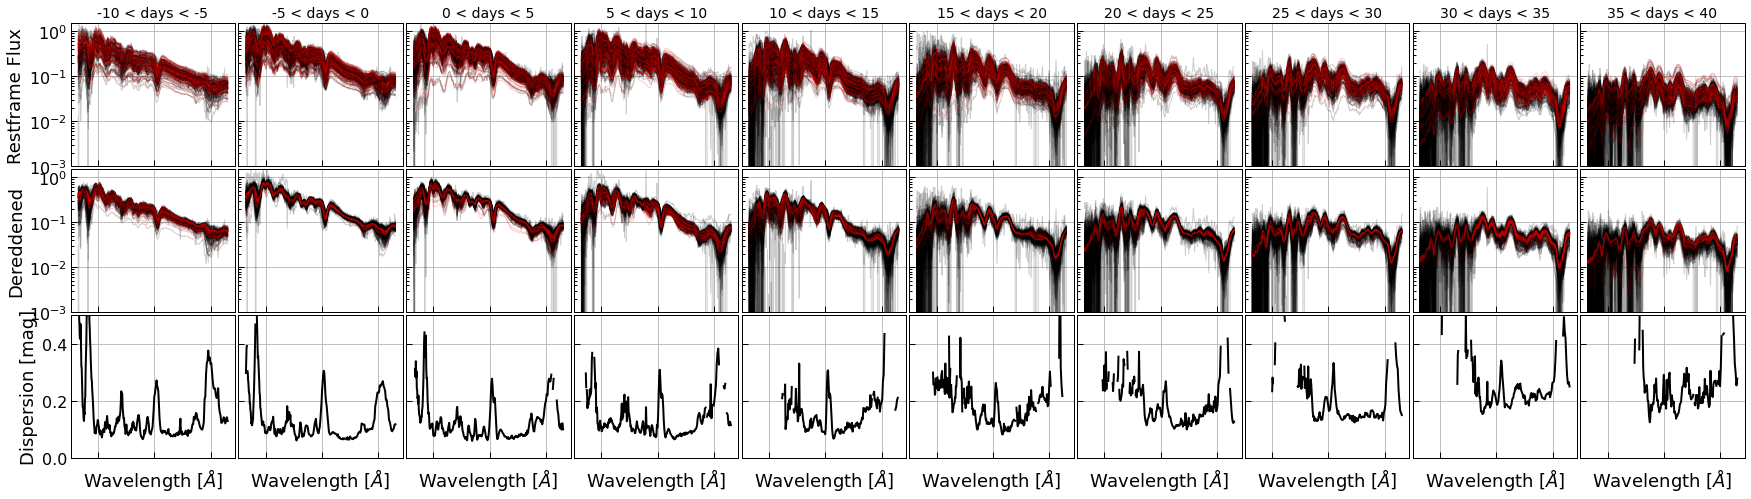

In [82]:
def bin_spectra_time(spec_, mask, sigma, time, z_latent, weighted=False, outlier_cut=98, ntbins=11, deredden=False, c=0, gray=0, CL=None):
    """Calculate std of true and reconstructed spectra as a function of time                                        
                                                                                                                    
    Parameters                                                                                                      
    ----------                                                                                                      
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                
       measured spectra                                                                                             
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                
       model spectra                                                                                                
    sigma: array (N_sn, n_timesamples, data_dim)                                                                    
       measurement uncertainty                                                                                      
    time: array (N_sn, n_timesamples)                                                                               
       observation time                                                                                             
    """
    dm = mask[:,:,0] != 0.
    
    spec_use = spec_.copy()
    t_bin_edge = np.linspace(0, 1, ntbins+1)
    t_bin_cent = (t_bin_edge[:-1] + t_bin_edge[1:])/2

    if deredden:
        if CL is None:
            _, CL, _ = np.loadtxt('data/F99_colorlaw.txt', unpack=True)
            
#         plt.figure(figsize=(20,10))

        for i in range(spec_use.shape[0]):    
#                         print((CL*np.exp(c[i]) + gray[i]))
#             plt.plot(spec_use[i, 0], color='C0')
            spec_use[i] = spec_use[i] / 10**(-0.4 * ( CL*c[i] + gray[i]) )
#             plt.plot(spec_use[i, 0], color='C1')

    s0 = spec_use[dm]
    sig = sigma[dm].copy()

    z = np.repeat(z_latent[:, np.newaxis, :], spec_use.shape[1], axis=-2)[dm]
    
    t   = time[dm][:,0]

    s0 = np.reshape(s0, (-1, 288))
    sig = np.reshape(sig, (-1, 288))

    # sometimes there are huge outliers,                                                                            
    # so set errors larger than some percentile to the value corresponding to that percentile                       
    s0_median_t = np.zeros((len(t_bin_cent), s0.shape[1]))

    s0_all = []
    z_all = []

    bins = np.digitize(t, t_bin_edge) - 1
    for ibin in np.unique(bins):
        dm   = bins == ibin
        s0i = s0[dm].copy()
        z0i = z[dm].copy()
        
        s0_all.append(s0i)
        z_all.append(z0i)

        s0_median_t[ibin] = np.median(s0i, axis=0)

    return s0_all, s0_median_t, z_all, t_bin_edge.astype(np.float32), t_bin_cent.astype(np.float32)


ymin = 1e-3
ymax = 1.5

latent_dim = 2

# file_bases  = ['data_kfold0_posterior_02Dlatent_layers256-128-32_minz_0pt02_data_augment_amplitude_maxlightcut_meandeltam.npy']
# file_bases  = ['data_kfold0_posterior_02Dlatent_layers256-128-32_minz_0pt02_data_augment_amplitude_maxlightcut_norma_hmc.npy']
file_bases = ['data_kfold{:d}_posterior_{:02d}Dlatent_layers256-128-32_minz_0pt02_data_augment_decorrelatedust.npy'.format(kfold, latent_dim)]

# file_bases  = ['data_kfold0_posterior_03Dlatent_layers256-128-32_minz_0pt02_data_augment_amplitude_covloss.npy']

#               'data_kfold0_posterior_04Dlatent_layers256-128-32_minz_0pt02_data_augment.npy']

# tstrs = ['train', 'test']
tstrs = ['train']
# tstrs = ['test']

nx = 2
ntbins = 10
lw = 2
for il, file_base in enumerate(file_bases):
    print(file_base)
    min_train_redshift = 0.02
    max_train_redshift = 0.1


    mask_vary_train = np.ones(train_data['mask'].shape, dtype=np.float32)
    dm_redshift = (train_data['redshift'] > min_train_redshift) & \
                  (train_data['redshift'] < max_train_redshift)
    mask_vary_train[~dm_redshift] = 0.


    # ALL SPECTRA
    train_data = load_data('../outputs/train_'+file_base)
    test_data  = load_data('../outputs/test_'+file_base)


    spec_all = {}
    spec_all_median = {}

    salt_spec_all = {}
    salt_spec_all_median = {}

    ae_spec_all = {}
    ae_spec_all_median = {}

    z_latent_all = {}
    for tstr in tstrs:
        if tstr == 'train':
            data = train_data
        else:
            data = test_data
            
            
        mask_vary = np.ones(data['mask'].shape[0], dtype=np.float32)
        dm_redshift = (data['redshift'] > min_train_redshift) & \
                      (data['redshift'] < max_train_redshift)
        
        dm = get_train_mask(data, params)

        mask_vary[~dm] = 0.

        dm = mask_vary > 0


        fig, ax = plt.subplots(nrows=3, ncols=ntbins, sharex=True, figsize=(30, 8))#, gridspec_kw={'height_ratios': [3, 1]})
        plt.subplots_adjust(wspace=0.02, hspace=0.02)

        for ired in range(3):
            for it in range(ntbins):

                for axis in ['top','bottom','left','right']:
                    ax[ired, it].spines[axis].set_linewidth(1.)

                ax[ired, it].tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
                ax[ired, it].tick_params('both', length=3, width=1., which='minor', color='k', direction='in')


        for ired, deredden in enumerate([False, True]):
            c=data['z_latent_mcmc'][:, -1]

        #         gray=0
            print(data['z_latent_mcmc'][:,0].min(), data['z_latent_mcmc'][:,0].max(), data['z_latent_mcmc'][:,0].mean())
            gray=data['z_latent_mcmc'][:,0]

            CL_in=None
        #         CL=CL_AE

            spec_all[tstr], spec_all_median[tstr], z_latent_all[tstr], t_bin_edge, t_bin_cent = bin_spectra_time(data['spectra'][dm],
                                                                                             data['mask'][dm],
                                                                                             data['sigma'][dm],
                                                                                             data['times'][dm], 
                                                                                             data['z_latent_mcmc'][dm],
                                                                                             ntbins=ntbins, deredden=deredden, c=c[dm], gray=gray[dm], CL=CL_in)

    #         salt_spec_all[tstr], salt_spec_all_median[tstr], t_bin_edge, t_bin_cent = bin_spectra_time(data['spectra_salt'][dm],
    #                                                                                                    data['mask'][dm],
    #                                                                                                    data['sigma'][dm],
    #                                                                                                    data['times'][dm], deredden=deredden, c=c, gray=gray, CL=CL_in)

            ae_spec_all[tstr], ae_spec_all_median[tstr], z_latent_all[tstr], t_bin_edge, t_bin_cent = bin_spectra_time(data['spectra_mcmc'][dm],
                                                                                                   data['mask'][dm],
                                                                                                   data['sigma'][dm],
                                                                                                   data['times'][dm],
                                                                                                   data['z_latent_mcmc'][dm],
                                                                                                    ntbins=ntbins, deredden=deredden, c=c[dm], gray=gray[dm], CL=CL_in)
            # for i in range(len(spec_all[tstr])):
            #     spec_all[i] = np.clip(spec_all[tstr][i], 1e-3, np.inf)
                
            for it in range(ntbins):
                for ispec in range(ae_spec_all[tstr][it].shape[0]):
                    colors = plt.cm.jet((z_latent_all[tstr][it][:, 0]-data['z_latent_mcmc'][:, 0].min())/(data['z_latent_mcmc'][:, 0].max() - data['z_latent_mcmc'][:, 0].min()))
                    
                    ax[ired, it].plot(train_data['wavelengths'], spec_all[tstr][it][ispec],
                                           '-',lw=1, c='k', alpha=0.2)#, label='MAP')
                    
                    ax[ired, it].plot(train_data['wavelengths'], ae_spec_all[tstr][it][ispec],
                                           '-',lw=1, c='r', alpha=0.2)#, label='MAP')
                                      
                    # ax[ired, it].plot(train_data['wavelengths'], spec_all[tstr][it][ispec],
                    #    '-',lw=1, color=colors[ispec], alpha=0.2)#, label='MAP')
                    
                    
            #                 ax[it//nx, it%nx].plot(train_data['wavelengths'], salt_spec_all[tstr][it][ispec], '-',
            #                          lw=1, c='C0', alpha=0.2)#, label='MAP')
#                     ax[ired, it].plot(train_data['wavelengths'], ae_spec_all[tstr][it][ispec],
#                                            '-', lw=1, c='orangered', alpha=0.2)#, label='MAP')

                if deredden:
                    ax[ired+1, it].plot(train_data['wavelengths'], np.std(-2.5*np.log10(spec_all[tstr][it]/ae_spec_all[tstr][it]), axis=0),
                                   '-',lw=lw, c='k', alpha=1)#, label='MAP')
#                     ax[ired+1, it].plot(train_data['wavelengths'], np.std(spec_all[tstr][it] - ae_spec_all[tstr][it], axis=0),
#                                    '-',lw=lw, c='k', alpha=1)#, label='MAP')
                    
                    
                    
        #                 ax[it//2, it%2].plot(train_data['wavelengths'], -2.5*np.log10(np.abs(salt_spec_all[tstr][it][ispec]/spec_all[tstr][it][ispec])), '-',
        #                          lw=1, c='C0', alpha=0.2)#, label='MAP')
        #                 ax[it//2, it%2].plot(train_data['wavelengths'], -2.5*np.log10(np.abs(ae_spec_all[tstr][it][ispec]/spec_all[tstr][it][ispec])), '-',
        #                          lw=1, c='C1', alpha=0.2)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], np.std(-2.5*np.log10(np.abs(salt_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '--',
        #                      lw=lw, c='C0', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], np.std(-2.5*np.log10(np.abs(ae_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '--',
        #                      lw=lw, c='C1', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], -np.std(-2.5*np.log10(np.abs(salt_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '--',
        #                      lw=lw, c='C0', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], -np.std(-2.5*np.log10(np.abs(ae_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '--',
        #                      lw=lw, c='C1', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], np.median(-2.5*np.log10(np.abs(salt_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '-',
        #                      lw=lw, c='C0', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].plot(train_data['wavelengths'], np.median(-2.5*np.log10(np.abs(ae_spec_all[tstr][it]/spec_all[tstr][it])), axis=0), '-',
        #                      lw=lw, c='C1', alpha=1.)#, label='MAP')

        #             ax[it//2, it%2].axhline(0, color='k')
        # #             ax1.plot(train_data['wavelengths'], spec_all_median[tstr][it], '-',
        # #                      lw=lw, c='k', alpha=alpha)#, label='MAP')
        # #             ax1.plot(train_data['wavelengths'], salt_spec_all_median[tstr][it], '-',
        # #                      lw=lw, c='C0', alpha=alpha)#, label='MAP')

                ax[ired, it].set_ylim(ymin, ymax)
                ax[ired, it].set_yscale('log')
                
                ax[ired, it].grid()

                if ired==0:
                    ax[2, it].set_ylim(0, 0.5)
                    ax[2, it].set_yscale('linear')
                    ax[2, it].grid()


                if ired==0:
                    ax[ired, it].set_title('{:.0f} < days < {:.0f}'.format(t_bin_edge[it]*50-10, t_bin_edge[it+1]*50-10), fontsize=14)
                    
                   
                if ired==0:
                    ax[2, it].set_xlabel('Wavelength [$\AA$]')

                if it!=0:
                    ax[ired, it].set_yticklabels([])
                    ax[ired+1, it].set_yticklabels([])

                if ired!=2:
                    ax[ired, it].set_xticklabels([])
                
        ax[0, 0].set_ylabel('Restframe Flux')
        ax[1, 0].set_ylabel('Dereddened')
        ax[2, 0].set_ylabel('Dispersion [mag]')

#         plt.savefig('figures/deredden_{:s}.png'.format(tstr), dpi=300, bbox_inches='tight')#     ax1.set_yscale('linear')
#     # ax1.set_yscale('log')


# #     ax1.legend(ncol=5, fontsize=14, title='Latent dimensionality', bbox_to_anchor=(0.5, 0.97), loc='lower center', frameon=False)

#     ax1.set_ylabel('Dispersion [magnitudes]')

#     ax1.set_xlabel('Wavelength [$\AA$]')

#     if t_bin_cent.shape[0] > 1:
#         cax = fig.add_axes([0.92, 0.2, 0.01, 0.6])
#         fig.colorbar(dummie_cax, cax=cax, label='Days from max light')



# Load and use Models

In [249]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
print('devices: ', tf.config.list_physical_devices('GPU') )

tfk  = tf.keras
tfkl = tf.keras.layers
print("TFK Version", tfk.__version__)

# %pip install tensorflow-probability==0.9.0                                                                          
import tensorflow_probability as tfp

tfb  = tfp.bijectors
tfd  = tfp.distributions
print("TFP Version", tfp.__version__)

import numpy as np
import os
import time

import tensorboard.plugins.hparams as HParams
import argparse

from utils.YParams import YParams
import utils.data_loader as data_loader
from utils.calculations import *

from models.losses import *
from models.posterior import *

import models.loader 
import models.flow

import matplotlib.pyplot as plt

tensorflow version:  2.2.0
devices:  []
TFK Version 2.3.0-tf
TFP Version 0.10.1


In [250]:
latent_dim = 3
kfold = 0

# out_file_tail = '_multistage_train_decorrelate_all_refreshdecoder'
# out_file_tail = '_3stage_train_decorrelate_all_new'
out_file_tail = '_3stage_train_decorrelate_all_seed0'

# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'#_correct_newvar'
# istart = 1


# file_string = 'layers16-8-8_3stage_train_decorrelate_all'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all' 

# file_string = 'layers256-128-32_multistage_train_decorrelate_all' 

file_string = 'layers256-128-32' + out_file_tail

istart = 2

# train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
# test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
                                                                                           
train_data_file  = '../data/train_data_kfold0.npy'
test_data_file  = '../data/test_data_kfold0.npy'                                                                                       
# param_file = '../outputs/params/AE_kfold{:d}_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

# Load data
def load_data(file_path):
    return np.load(file_path, allow_pickle=True).item()

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)
print(train_data.keys())
# parser = argparse.ArgumentParser()
# parser.add_argument("--yaml_config", default='../config/posterior_analysis.yaml', type=str)
# parser.add_argument("--config", default='posterior', type=str)
# parser.add_argument("--print_params", default=True, action='store_true')

# args = parser.parse_args(args=[])

# params = YParams(os.path.abspath(args.yaml_config), args.config, print_params=True)#args.print_params)            
# params['latent_dim'] = latent_dim

# params = np.load(param_file, allow_pickle=True).item()['parameters']
# params['nlayers'] = 12
# params['nunit'] =  8



parser = argparse.ArgumentParser()
parser.add_argument("--yaml_config", default='../config/posterior_analysis.yaml', type=str)
parser.add_argument("--config", default='posterior', type=str)
parser.add_argument("--print_params", default=True, action='store_true')

args = parser.parse_args(args=[])


params = YParams(os.path.abspath(args.yaml_config), args.config, print_params=True)#args.print_params)            
params['latent_dim'] = latent_dim
params['out_file_tail'] = out_file_tail
params['posterior_file_tail'] = out_file_tail

print(params['use_amplitude'])
#Get PAE model


PAE = models.loader.PAE(params)

train_data = load_data(params['train_data_file'])#, print_params=params['print_params'])
test_data  = load_data(params['test_data_file'])

# Mask certain spectra                                                                                 
train_data['mask_spectra'] = data_loader.get_train_mask_spectra(train_data, params)
test_data['mask_spectra'] = data_loader.get_train_mask_spectra(test_data, params)

train_data['mask'] *= train_data['mask_spectra']
test_data['mask']  *= test_data['mask_spectra']



# get latent representations from encoder and flow                                                                       
train_data['z_latent'] = PAE.encoder((train_data['spectra'], train_data['times'], train_data['mask'])).numpy()
test_data['z_latent']  = PAE.encoder((test_data['spectra'], test_data['times'], test_data['mask'])).numpy()

train_data['u_latent'] = PAE.flow.bijector.inverse(train_data['z_latent'][:, istart:]).numpy()
test_data['u_latent']  = PAE.flow.bijector.inverse(test_data['z_latent'][:, istart:]).numpy()

# get reconstructions
train_data['spectra_ae'] = PAE.decoder((train_data['z_latent'], train_data['times'], train_data['mask'])).numpy()
test_data['spectra_ae']  = PAE.decoder((test_data['z_latent'], test_data['times'], test_data['mask'])).numpy()


dict_keys(['wavelengths', 'names', 'spectra', 'spectra_salt', 'sigma', 'mask', 'times', 'ID', 'Nspectra_ID', 'dphase', 'x0', 'x1', 'c', 'MB', 'hubble_resid', 'redshift', 'times_orig', 'luminosity_distance'])
------------------ Configuration ------------------
nchains 25
find_MAP True
stop_ratio 0.0001
max_iterations 2500
max_line_search_iterations 50
tolerance 0.01
run_HMC True
ihmc True
num_burnin_steps 10000
num_samples 20000
num_leapfrog_steps 3
step_size 0.05
dtime_norm 1.0
target_accept_rate 0.651
seed 13579
batch_size 171
train_noise False
vary_mask False
lr 0.001
noise_scale 1.0
mask_vary_frac 0.2
rMAPini False
train_MAP True
train_amplitude True
train_dtime True
train_bias False
savedata True
fig_dir ../figures/2021/
data_dir data/
output_dir outputs/
model_dir outputs/tensorflow_models/
param_dir outputs/params/
log_dir logs/
train_data_file data/train_data_kfold0.npy
test_data_file data/test_data_kfold0.npy
kfold 0
colorlaw_file data/F99_colorlaw.txt
out_file_tail _3stage_tra

[ 0.00013814 -0.00125251  0.00323176  0.0774907  -0.01956781 -0.02993749]


<ipython-input-139-18423cd857f8>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)


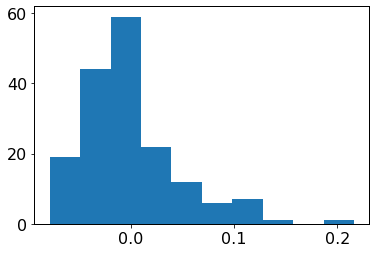

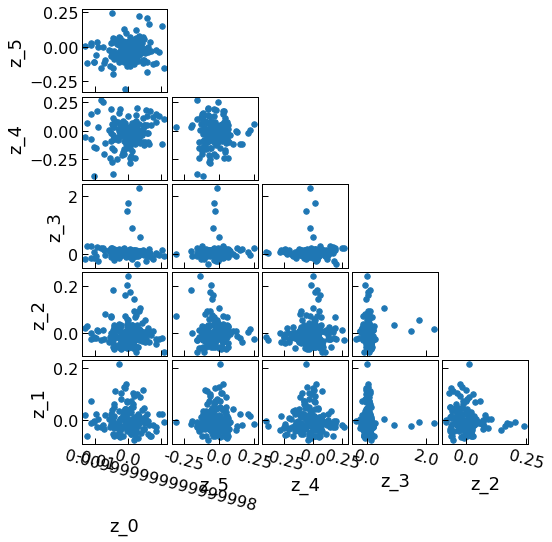

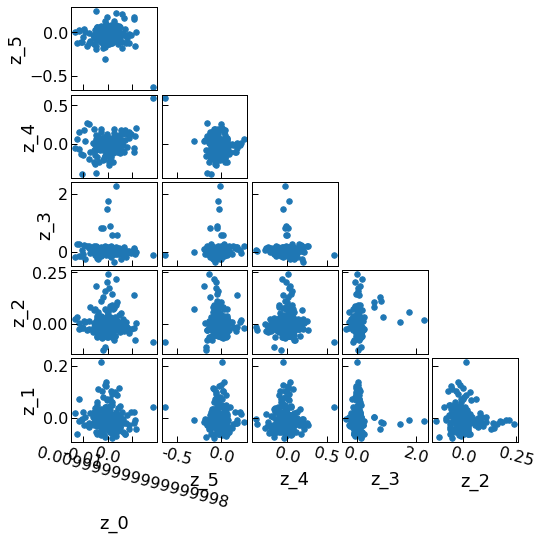

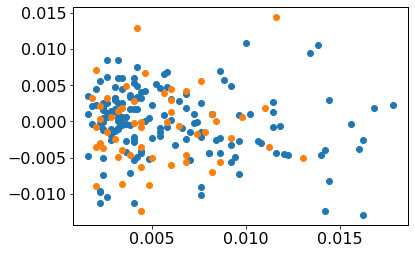

In [251]:
# print(train_data['z_latent'].mean(0))
# print(test_data['z_latent'].mean(0))

plt.hist(train_data['z_latent'][:, 1])

# plt.figure()
# # plt.hist(np.exp(train_data['z_latent'][:, -1]))
# plt.hist(train_data['z_latent'][:, -1])

# plt.figure()
# plt.hist(train_data['u_latent'][:, -1])
print(train_data['z_latent'].mean(0))

dm = get_train_mask(train_data, params)

plot_grid(train_data['z_latent'][dm]) 

plot_grid(train_data['z_latent']) 

plt.figure()
dm = get_train_mask(train_data, params)
plt.scatter(train_data['dphase'][dm]/50, train_data['z_latent'][dm, 0])

dm = get_train_mask(test_data, params)
plt.scatter(test_data['dphase'][dm]/50, test_data['z_latent'][dm, 0])

In [ ]:
for iplt in range(10):
    plt.figure()
    plt.plot(train_data['spectra'][iplt,0])
    plt.plot(train_data['spectra_ae'][iplt,0])
    # plt.plot(train_data['spectra_map'][iplt,0])
    # plt.plot(train_data['spectra_mcmc'][iplt,0])#*10**(-0.4*-0.34430096))


print(train_data['z_latent'].mean(0))

<ipython-input-436-0c88915bf942>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


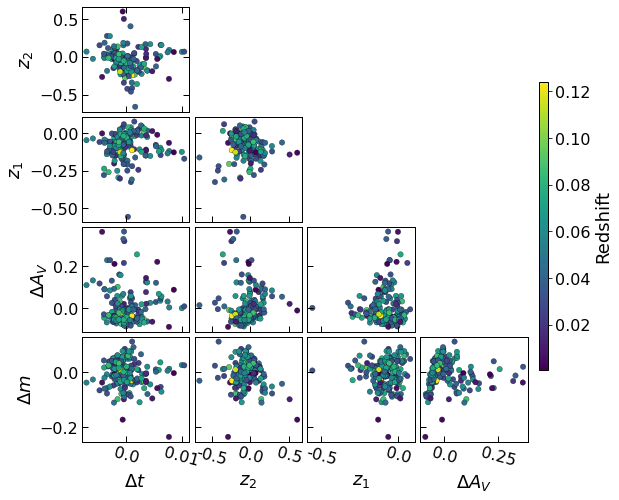

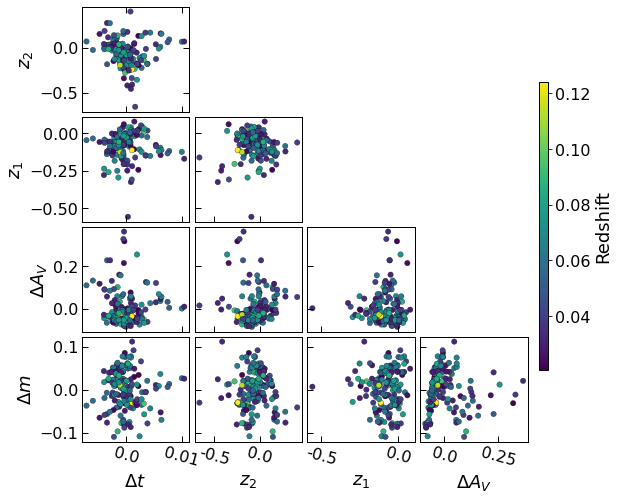

In [450]:
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-2)]
labels = ['$\Delta t$', '$\Delta m$', '$\Delta A_V$'] + latent 
    
dm = get_train_mask(train_data, params)
    
plot_grid(train_data['z_latent'], labels=labels, color_arr=train_data['redshift'], color_label='Redshift', cmap=plt.cm.viridis)
plot_grid(train_data['z_latent'][dm], labels=labels, color_arr=train_data['redshift'][dm], color_label='Redshift', cmap=plt.cm.viridis)


[[0.02 0.2  0.4  0.6  0.8  0.98 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]] [[-10.   0.  10.  20.  30.  40. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10.]]
[[ 0.00047084 -0.00865025 -0.00177488  0.04707656 -0.01980047 -0.0300341 ]] (1, 6) (9, 4)


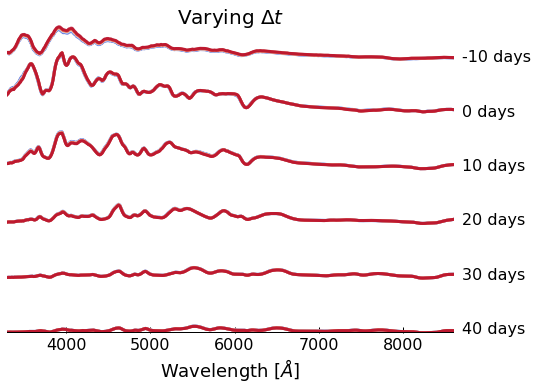

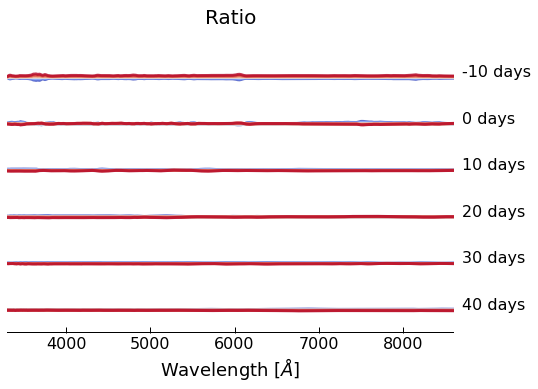

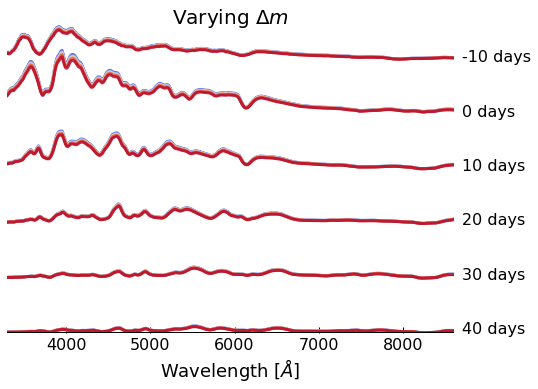

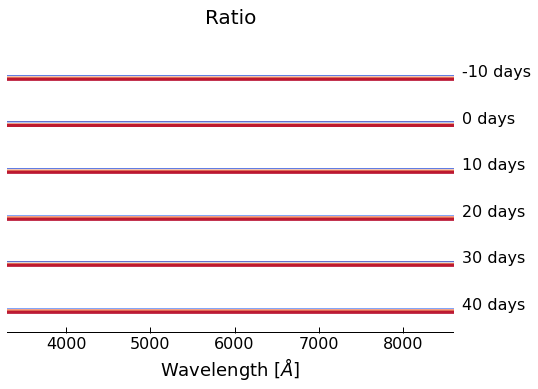

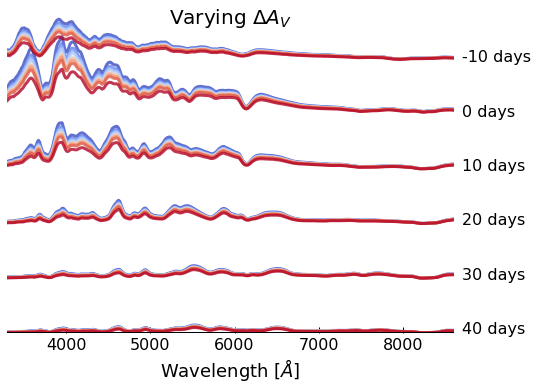

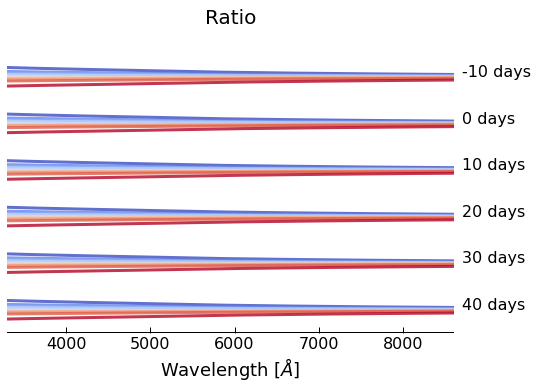

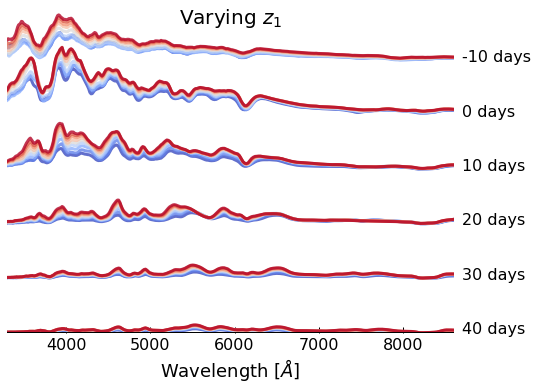

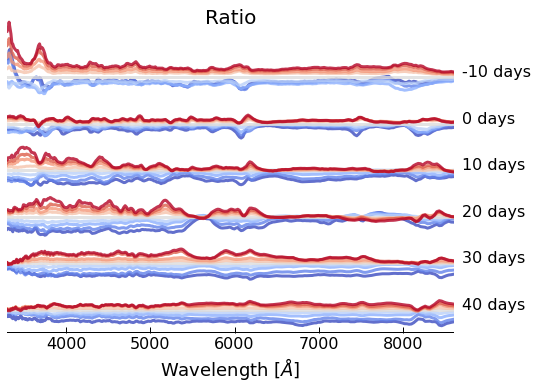

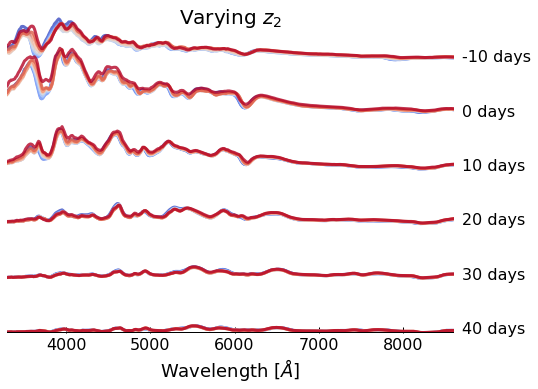

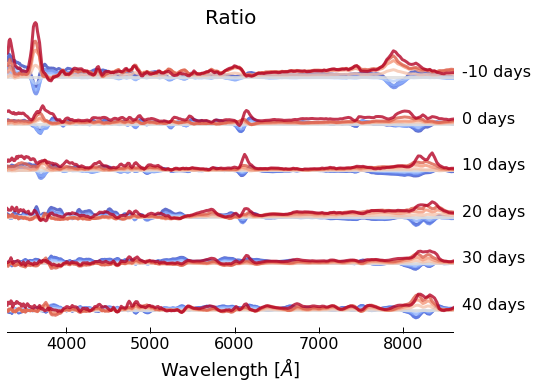

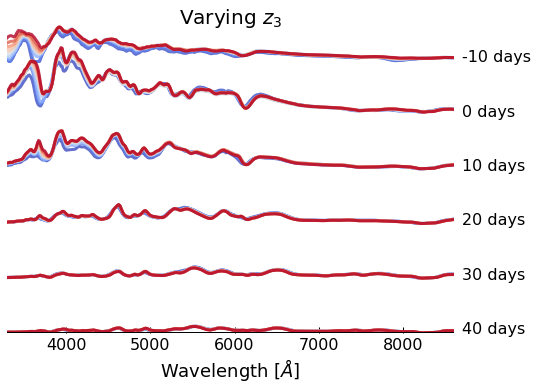

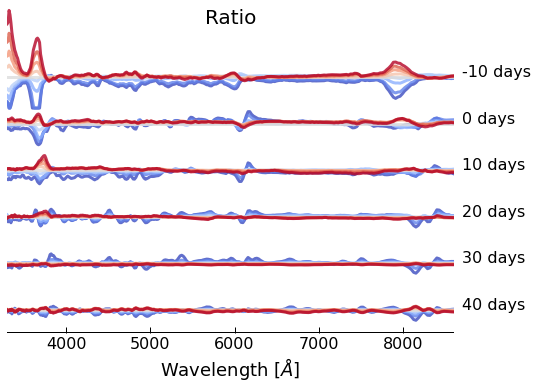

In [253]:
# Plot SN while varying z latent params to see effects
dm = get_train_mask(train_data, params)
# z_latent_use = PAE.encoder((train_data['spectra'], train_data['times'], train_data['mask'])).numpy()[dm]
z_latent_use = train_data['z_latent']

nsamples = 10
percentiles = np.arange(10, 100, nsamples)
z_bin_edge = np.percentile(z_latent_use, percentiles, axis=0)
nsamples = z_bin_edge.shape[0]

savefig = True
# savefig = False

figdir = '../figures/'

lwt = 2
lw  = 3

c0  = 'orangered'
c1  = 'C0'

dim_plus_2 = 1 #2

wave_txt = train_data['wavelengths'][-1]+100

alpha=0.8
#     fig, ((ax1, ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,8), gridspec_kw={'height_ratios': [3, 1]})
plttypes = ['normal', 'residual']
aoffsets_list = [[0.1, 3], [0.1, 5], [1.5, 2.75]] #0.7]

# get data to use

Asamp = np.linspace(0.5, 1.5, nsamples)

nshow = 6 #3
times_lin = np.zeros((1, params['n_timestep'])) 
times_lin[:, :nshow] = np.linspace(0,1,nshow)
mask_     = np.ones((1, params['n_timestep']))

# nshow = 6 #3
# times_lin = np.zeros((1, 24)) + np.linspace(0,4.6,24)


times_orig_lin = times_lin*50 - 10
times_lin[0,0] += 1./50
times_lin[0,nshow-1] -= 1./50

print(times_lin, times_orig_lin)

sample     = 0
seed       = 13579 #np.random.randint(10000)
redshift   = 0.05
ntrainstep = 2000
stop_ratio = 1.0001

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0,1,nsamples))

z_median = np.median(z_latent_use, axis=0)[None, ...]

# get u array of zeros
print(z_median, z_median.shape, colors.shape)
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]

labels = ['$\Delta t$', '$\Delta m$', '$\Delta A_V$'] + latent

for dim in range(z_bin_edge.shape[1]):
    # if dim < 2:
    #     aoffsets = [0.75, 2] #aoffsets_list[dim]
    #     std = 2.0
    # else:
    #     aoffsets = [0.75, 1.25] #aoffsets_list[dim]
    #     std = 2.0
    aoffsets = [0.75, 1.5] #aoffsets_list[dim]

    zsamp = z_bin_edge[:, dim]

    for iplt, plttype in enumerate(plttypes):
        
        if plttype == 'normal':   title = 'Varying {:s}'.format(labels[dim])
        if plttype == 'residual': title = 'Ratio'

        fig, ((ax1 )) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))#, gridspec_kw={'height_ratios': [3, 1]})

        for axis in ['top','bottom','left','right']:
            ax1.spines[axis].set_linewidth(1.)
    #         ax2.spines[axis].set_linewidth(1.5)

        ax1.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
        ax1.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')
    #     ax2.tick_params('both', length=6, width=1.5, which='major', color='k',direction='in')                                         
    #     ax2.tick_params('both', length=3, width=1.5, which='minor', color='k',direction='in')

        ymin = 100
        ymax = 0
        
        # get origin value
        z_ = z_median.copy()
        xpred_m = PAE.decoder((z_, times_lin,  mask_))[0]
        
        offset = np.arange(times_lin.shape[1]) * -1 * aoffsets[iplt]
        
        for sample in range(z_bin_edge.shape[0]):

            # set u values along slice
            z_ = z_median.copy()
            z_[:, dim:dim+dim_plus_2] = zsamp[sample]

            xpred_i = PAE.decoder((z_, times_lin, mask_))[0] #/ (10**(-0.4* (CL*np.exp(z_[:, -1]) + z_[:, 0])))

            for i in range(nshow):
                labp = None
                labo = None
                if i==0:
                    labs = 'Encoder'
                    labp = 'MAP'
                if plttype == 'normal':
                    xpi = xpred_i[i] + offset[i]
                    ax1.plot(train_data['wavelengths'], xpi, '-', c=colors[sample], lw=lw, alpha=alpha)#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)

                    ymin = min(ymin, min(xpi) )
                    ymax = max(ymax, max(xpi) )

                if plttype == 'residual':
                    xti = xpred_m[i]
                    xpi = xpred_i[i]
#                     print(xti, xpi)
                    ax1.plot(train_data['wavelengths'], xpi/xti - 1 + offset[i], '-', c=colors[sample], lw=lw, alpha=alpha)#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, (xpi/xti)[-1] - 1 + offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)
                
#                 if sample == 0:
#                     if plttype == 'normal': 
#                         ymin = 0
#                         ymax = max(ymax, xpi/xti)
#                     if plttype == 'residual': 
#                         ymin = 0
#                         ymax = max(ymax, xpi/xti)
                                       
        #         ax1.set_title(title+', z={:.4f}, latent=[{:.2f}, {:.2f}]'.format(red, z_lat[0], z_lat[1]))
        
        ax1.set_title(title, fontsize=20, y=0.95, pad=0)

        ax1.set_ylabel('Restframe Flux')
    #     ax2.set_ylabel('$|x-x_{recon}|/\sigma$')
        ax1.set_xlabel('Wavelength [$\AA$]')
        ax1.set_ylabel('Normalized Restframe Flux(t, $\lambda$)')

        if plttype == 'normal':
            ymax = offset[0] + aoffsets[iplt] 
            ymin = offset[nshow-1]
        
        if plttype == 'residual':
            ymax = offset[0] + aoffsets[iplt] * 1.5
            ymin = offset[nshow-1] - aoffsets[iplt]*1./2
        
        ax1.set_ylim(ymin, ymax)

#         ax1.set_ylim(ymin-0.1, ymax)
        
#         ax1.spines['right'].set_visible(False)
#         ax1.spines['top'].set_visible(False)

#         # Only show ticks on the left and bottom spines
#         ax1.yaxis.set_ticks_position('left')
#         ax1.xaxis.set_ticks_position('bottom')

        ax1.set_frame_on(False)
        ax1.get_xaxis().tick_bottom()
        ax1.axes.get_yaxis().set_visible(False)
        xmin, xmax = ax1.get_xaxis().get_view_interval()
        ymin, ymax = ax1.get_yaxis().get_view_interval()
        ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

        ax1.legend(loc='upper right', frameon=False, ncol=3)


    #     ax1.axis('off')

    #     ax2.set_yscale('log')
        ax1.set_xlim(train_data['wavelengths'][0], train_data['wavelengths'][-1])
    #     plt.subplots_adjust(hspace=0.025)

        if savefig: 
            fname = 'vary_zlatent_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)
            if dim_plus_2 > 1:
                fname = 'vary_zlatent_dimplus2_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)

            plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')



In [12]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plt_predictions_side_by_side(wavelengths, x_true, x_pred, x_salt, sigma, times, times_unscaled, dtime, red, n_spectra, title='Training', ispec=0, savefig=False, tstr='train', fhead='postMAP'):
    dm = x_true[:,0] != -1.

#                 labo = 'Observed spectra'
#                 labs = 'Encoder'
#                 labp = 'MAP'
    x_truei = x_true.copy()
    x_predi = x_pred.copy() 
    x_salti = x_salt.copy()

    sigmai  =  sigma.copy()
    timesi  =  times_unscaled.copy()

    cmap = cm.coolwarm
    colors = cmap(np.linspace(0,1,len(x_truei)))

    lwt = 2
    lw  = 2
    
    c0  = 'orangered'
    c1  = 'C0'
    
    cmap0 = truncate_colormap(cm.viridis, 0., 1.0)
    cmap1 = truncate_colormap(cm.viridis, 0., 1.0)

    wave_txt = wavelengths[-1]+100

    alpha=0.8
    alphat = 0.4
    
    nrow = 3
    ncol = 2
    
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, figsize=(20,6), gridspec_kw={'height_ratios': [3, 1, 1]})
    plt.subplots_adjust(wspace=0.025, hspace=0.075)
    
    # Make dummie mappable
    xx = np.linspace(-10, 40, 100)
    dummie_cax = ax[0,0].scatter(xx, xx, c=xx, cmap=cmap0)
    # Clear axis
    ax[0, 0].cla()
    
    for axi in ax:
        for axj in axi:
            for axis in ['top','bottom','left','right']:
                axj.spines[axis].set_linewidth(1.)
  
            axj.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
            axj.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')
        
        
    ymax = 0
    for i in range(n_spectra):
        labp = None
        labs = None
        labo = None
        ls= '-'

        if i==0:
            labo = 'Observed spectra'
            if fhead=='preMAP':
                labs = 'SALT2'
                labp = 'Encoder'

            if fhead=='postMAP':
                labs = 'Encoder'
                labp = 'MAP'
                    
        xti = x_truei[i]
        xpi = x_predi[i]
        xsi = x_salti[i]

        for j in range(ncol):
            ax[0,j].plot(wavelengths, xti, '-', c='k', lw=lwt, alpha=alphat, label=labo)#colors[i])
            ax[0,j].fill_between(wavelengths, xti-sigmai[i],  xti+sigmai[i], color='gray', alpha=alphat, lw=1)
    
        im = ax[0,0].plot(wavelengths, xsi, '-', c=cmap0(times[i, 0]), lw=lw, alpha=alpha, label=labs)
        ax[0,1].plot(wavelengths, xpi, ls=ls, c=cmap1(times[i, 0]), lw=lw, alpha=alpha, label=labp)

        if i==0: 
            for j in range(ncol):
                ax[1,j].plot(wavelengths, wavelengths*0, '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])

        ax[1,0].plot(wavelengths, xsi - xti, '-', c=cmap0(times[i, 0]), lw=lw, alpha=alpha, label=labs)
        ax[1,1].plot(wavelengths, xpi - xti, ls=ls, c=cmap1(times[i, 0]), lw=lw, alpha=alpha, label=labp)


        if i==0: 
            for j in range(ncol):
                ax[2,j].plot(wavelengths, wavelengths*0, '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])

        ax[2,0].plot(wavelengths, (xsi - xti)/sigmai[i], '-', c=cmap0(times[i, 0]), lw=lw, alpha=alpha, label=labs)
        ax[2,1].plot(wavelengths, (xpi - xti)/sigmai[i], ls=ls, c=cmap1(times[i, 0]), lw=lw, alpha=alpha, label=labp)
        
        
        ymax = max(ymax, xti.max(), xsi.max(), xpi.max())#1.4
        
    yminmax_resid = 0.09
    yminmax_pull = 9

    for j in range(ncol):
        ax[0,j].set_ylim(0, ymax)
        ax[1,j].set_ylim(-yminmax_resid, yminmax_resid)
        ax[2,j].set_ylim(-yminmax_pull, yminmax_pull)

#         ax[0,j].legend(loc='upper right')

    for i in range(nrow):
        for j in range(ncol):
            ax[i,j].set_xlim(wavelengths[0], wavelengths[-1])
            
            ax[i,j].grid()

#             ax2.set_ylim(0, ymax)

#         if plttype == 'residual':   
#             yminmax = 0.3
#             ax1.set_ylim(-yminmax, yminmax)

    ax[0,0].set_ylabel('Restframe Flux')
#         ax[1,0].text(0.95, 0.95, '$F - \hat{F}$', transform = ax[1,0].transAxes)
    ax[1,0].set_ylabel('Residual')
    ax[2,0].set_ylabel('Pull')

    # turn off ylabels on right plots
    
    for i in range(nrow):
        ax[i,1].set_yticklabels([])
        
    for i in range(ncol):
        ax[2,i].set_xlabel('Wavelength [$\AA$]')

    labo = 'Observed spectra'
    if fhead=='preMAP':
        labs = 'SALT2'
        labp = 'Encoder'

    if fhead=='postMAP':
        labs = 'Encoder'
        labp = 'MAP'
    ax[0,0].set_title(labs)
    ax[0,1].set_title(labp)

    cax = fig.add_axes([0.92, 0.2, 0.01, 0.6])

    fig.colorbar(dummie_cax, cax=cax, label='Days from max light')

    
    if savefig: 
        fname = 'spectra/sidebyside_spectra_{:s}_{:s}{:03d}_{:s}_{:02d}Dlatent'.format(fhead, tstr, ispec, plttype, latent_dim)
        plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')
#
#           
#             ymax = 1.4
#             ax1.set_ylim(0, ymax)
#             ax2.set_ylim(0, ymax)

#         if plttype == 'residual':   
#             yminmax = 0.3
#             ax1.set_ylim(-yminmax, yminmax)
#             ax2.set_ylim(-yminmax, yminmax)

#         if plttype == 'pull':        
#             ax1.set_ylim(ymin-0.1, ymax+0.1)

 
# #         ax1.set_frame_on(False)
# #         ax1.get_xaxis().tick_bottom()
# #         ax1.axes.get_yaxis().set_visible(False)
# #         xmin, xmax = ax1.get_xaxis().get_view_interval()
# #         ymin, ymax = ax1.get_yaxis().get_view_interval()
# #         ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#         ax1.legend(loc='upper right', frameon=False, ncol=3)
#         ax2.legend(loc='upper right', frameon=False, ncol=3)


#         ax1.set_xlim(wavelengths[0], wavelengths[-1])
#         ax2.set_xlim(wavelengths[0], wavelengths[-1])

    

In [13]:
# Plot spectra
savefig = False
# savefig = True

tstr = 'test'
# tstr = 'train'

nplt = 1

for iplt in range(nplt):

    n_timesamples = spectra[tstr].shape[1]
    n_spectra = np.shape(np.where(spectra[tstr][iplt, :, 0] > -1))[1] # number of spectra that exist in observation

    data_dim      = spectra[tstr].shape[2]

    print('Redshift of sample(s) = ', redshifts[tstr][iplt])
    print('number of spectra in sample(s) = ', n_spectra)

    plt_predictions_side_by_side(wavelengths, spectra[tstr][iplt], spectra_ae[tstr][iplt], spectra_salt[tstr][iplt], 
            sigma[tstr][iplt], times[tstr][iplt], times_orig[tstr][iplt], dt[tstr][iplt], redshifts[tstr][iplt], n_spectra, title=tstr, ispec=iplt, savefig=savefig, tstr=tstr, fhead='preMAP')

#     plt_predictions_side_by_side(wavelengths, spectra[tstr][iplt], spectra_map[tstr][iplt], spectra_ae[tstr][iplt], 
#             sigma[tstr][iplt], times[tstr][iplt], times_orig[tstr][iplt], dt[tstr][iplt], redshifts[tstr][iplt], n_spectra, title=tstr, ispec=iplt, savefig=savefig, tstr=tstr, fhead='postMAP')


NameError: name 'spectra' is not defined

In [ ]:
import suPAErnova.utils.calculations as calculations
import matplotlib.patheffects as pe

def plot_spectra_map(data, spec1='salt2',spec2='ae', plttypes=['normal', 'residual'], lwt=1.25, lw=1.5, lwpe=2.5, alpha=0.8, alpha_fill=0.3,

                     ispec=0, train=True, savefig=False, tstr='train', relative_error=False):

    # Get non masked spectra
    spec1 = spec1.upper()
    spec2 = spec2.upper()
    dm = data['mask'][ispec, :, 0] != 0
    x_obs = data['spectra'][ispec, dm].copy()
    
    if spec1=='SALT2':
        x_1 = data['spectra_salt'][ispec, dm].copy()
    if spec1=='AE':
        x_1 = data['spectra_ae'][ispec, dm].copy()
    if spec1=='MAP':
        x_1 = data['spectra_map'][ispec, dm].copy()

    if spec2=='SALT2':
        x_2 = data['spectra_salt'][ispec, dm].copy()
    if spec2=='AE':
        x_2 = data['spectra_ae'][ispec, dm].copy()
    if spec2=='MAP':
        x_2 = data['spectra_map'][ispec, dm].copy()
    if spec2=='PAE':
        x_2 = data['spectra_mcmc'][ispec, dm].copy()

    sigma  = data['sigma'][ispec, dm].copy()
    times_orig  = data['times_orig'][ispec, dm].copy()
    times  = data['times'][ispec, dm].copy()

    wavelengths = data['wavelengths']
    red = data['redshift'][ispec]

    n_spectra = x_obs.shape[0]
    print(n_spectra)
    
    title = data['names'][ispec]
    # Set plot aesthetics                                                                                                 
    aoffsets = [0.4, 0.15, 7]

    cmap = plt.cm.coolwarm
    colors = cmap(np.linspace(0, 1, 256))

    # c0  = 'C3'
    # c1  = 'C0'
    c0  = colors[int(0.9*len(colors))]
    c1  = colors[int(0.1*len(colors))]


    wave_txt = wavelengths[-1]+100
    
    fontsize = 14
    
    # get reconstruction uncertainty
    if spec1!="SALT": 
        if spec1=="MAP":
            tuse = times + data['dtime_map']
        else:
            tuse = times

        sigma1 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=test_data['sigma_ae_time'])) # fill_value='extrapolate')   

    if spec2!="SALT": 
        if spec2=="MAP":
            tuse = times + data['dtime_map']
        if spec2=="PAE":
            tuse = times + data['dtime_mcmc']
        else:
            tuse = times
    
        sigma2 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=test_data['sigma_ae_time'])) # fill_value='extrapolate')   
#         sigma2 = 10**sigma2  
    # plt.figure(figsize=(12,6))
    # print(tuse[...,0].shape, sigma2.shape)
    # for i in range(tuse[...,0].shape[0]):
    #     plt.plot(sigma2.numpy()[i], label='{:.1f}'.format(tuse[...,0][i]*50-10))
    # plt.legend(ncol=4)
    
    # Plot
    for iplt, plttype in enumerate(plttypes):
        fig, ((ax1 )) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,10))                                  

        for axis in ['top','bottom','left','right']:
            ax1.spines[axis].set_linewidth(1.5)

        ax1.tick_params('both', length=6, width=1.5, which='major', color='k',direction='in')
        ax1.tick_params('both', length=3, width=1.5, which='minor', color='k',direction='in')

        # set constant offset scale
        #         offset = np.arange(len(times)) * -1 * aoffsets[iplt]
        amp_scale = 7
        if plttype == 'residual':
            amp_scale = 20
        offset = -times_orig/amp_scale

        phase_text_offset = 0.06*(offset.max()-offset.min())
        ymin = 100
        ymax = 0
        # Plot spectra 1 by 1
        if plttype=='normal':
            toffset_min = 0.3
        else:
            toffset_min = 0.1

        toffset_prev = 0.0
                
        for i in range(n_spectra):
            labp = None
            labs = None
            labo = None
            ls= '-'

            toffset_i = offset[i]
            dt_add = 0
            if np.abs(toffset_i - toffset_prev) < toffset_min and i >0:
                dt_add = np.abs(toffset_i - toffset_prev)-toffset_min
                
            if i==0:
                labo = 'Data'
                labs = spec1.upper()
                labp = spec2.upper()

            if plttype == 'normal':
                xi = x_obs[i] + offset[i]
                x1i = x_1[i] + offset[i]
                x2i = x_2[i] + offset[i]
                
                ax1.plot(wavelengths, xi, '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])                       
                ax1.fill_between(wavelengths, xi-sigma[i],  xi+sigma[i], color='gray', alpha=0.8, lw=1)
                
                if spec1!="SALT2": 
                    if relative_error:
                        ax1.fill_between(wavelengths, x1i-x_1[i]*sigma1[i],  x1i+x_2[i]*sigma1[i], color=c1, alpha=alpha_fill, lw=0)
                    else:
                        ax1.fill_between(wavelengths, x1i-sigma1[i],  x1i+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

                if spec2!="SALT2": 
#                     ax1.fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)
                    if relative_error:
                        ax1.fill_between(wavelengths, x2i-x_2[i]*sigma2[i],  x2i+x_2[i]*sigma2[i], color=c0, alpha=alpha_fill, lw=0)
                    else:
                        ax1.fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

                    #ax1.fill_between(wavelengths, x_2[i]-x_obs[i]*sigma2[i] + offset[i],  x_2[i]+x_obs[i]*sigma2[i]+ offset[i], color=c0, alpha=alpha_fill, lw=0)

#                     tf.print(tf.reduce_min(sigma2[i]), tf.reduce_max(sigma2[i]))
#                     print(x_2[i], x_2[i]*sigma2[i])
                ax1.plot(wavelengths, x1i, '-', c=c1, lw=lw, alpha=alpha, label=labs,
                        path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])
                ax1.plot(wavelengths, x2i, ls=ls, c=c0, lw=lw, alpha=alpha, label=labp,
                        path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])

                # add phase in days
                if i==0:
                    ax1.text(wave_txt+200, offset[i]+phase_text_offset, 'Phase\n[days]', fontsize=fontsize, ha='center', va='bottom')

                ax1.text(wave_txt, offset[i]+(xi[-1]-offset[i])+dt_add, '{:.1f}'.format(times_orig[i][0]), fontsize=fontsize, ha='left', va='center')

                ymin = min(ymin, min(xi), min(x1i), min(x2i) )
                ymax = max(ymax, max(xi), max(x1i), max(x2i) )


            if plttype == 'residual':
                xi = x_obs[i]
                x1i = x_1[i]
                x2i = x_2[i]

                ax1.plot(wavelengths, wavelengths*0+offset[i], '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])  
                ax1.fill_between(wavelengths, offset[i]-sigma[i],  offset[i]+sigma[i], color='gray', alpha=0.8, lw=1)

                if spec1!="SALT2": 
                    if relative_error:
                        ax1.fill_between(wavelengths, x1i-xi-x_1[i]*sigma1[i] +offset[i],  x1i-xi+x_1[i]*sigma1[i] + offset[i], color=c1, alpha=alpha_fill, lw=0)
                    else:
                        ax1.fill_between(wavelengths, x1i-xi-sigma1[i],  x1i-xi+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

                if spec2!="SALT2": 
                    if relative_error:
                        ax1.fill_between(wavelengths, x2i-xi-x_2[i]*sigma2[i] +offset[i],  x2i-xi+x_2[i]*sigma2[i] + offset[i], color=c0, alpha=alpha_fill, lw=0)
                    else:
                        ax1.fill_between(wavelengths, x2i-xi-sigma2[i],  x2i-xi+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

                ax1.plot(wavelengths, x1i - xi + offset[i], '-', c=c1, lw=lw, alpha=alpha, label=labs,
                        path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])

                ax1.plot(wavelengths, x2i - xi + offset[i], ls=ls, c=c0, lw=lw, alpha=alpha, label=labp,
                        path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])


                if i==0:
                    ax1.text(wave_txt+200, offset[i]+phase_text_offset, 'Phase\n[days]', fontsize=fontsize, ha='center')

                ax1.text(wave_txt, offset[i]+dt_add, '{:.1f}'.format(times_orig[i][0]), fontsize=fontsize, ha='left', va='center')

                ymin = min(ymin, min(x1i - xi + offset[i]), min(x2i - xi + offset[i]) )
                ymax = max(ymax, max(x1i - xi + offset[i]), max(x2i - xi + offset[i]) )

        ax1.set_xlabel('Wavelength [$\AA$]')
        ax1.set_ylabel('Normalized Restframe Flux')

        if plttype == 'normal':
            ax1.set_title(title, fontsize=18)
            ax1.set_ylim(ymin-0.1, ymax+0.1)

        if plttype == 'residual':
            ax1.set_title('Residual', fontsize=18)
            dxy = 0.05
            ax1.set_ylim(ymin-dxy, ymax)

        # Turn off axis lines
#         ax1.set_frame_on(False)
#         ax1.get_xaxis().tick_bottom()
#         ax1.axes.get_yaxis().set_visible(False)
#         xmin, xmax = ax1.get_xaxis().get_view_interval()
#         ymin, ymax = ax1.get_yaxis().get_view_interval()
#         ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax1.yaxis.set_ticks_position('left')
        ax1.xaxis.set_ticks_position('bottom')
        
        if plttype == 'normal':
            ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02),
                       frameon=False, ncol=3, columnspacing=1., handletextpad=0.5, handlelength=1.5)

        ax1.set_xlim(wavelengths[0], wavelengths[-1])

        toffset_prev = offset[i]

        if savefig:
            # plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, plttype, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')
            plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, plttype, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')
 

dm = (test_data['redshift'] > params['min_train_redshift']) & \
             (test_data['redshift'] < params['max_train_redshift'])

test_data['sigma_ae_time'], ae_noise_t_bin_edge, ae_noise_t_bin_cent = calculations.compute_sigma_ae_time(test_data['spectra'][dm],
                                                                                            np.clip(test_data['spectra_mcmc'][dm], 0, np.inf),
                                                                                            test_data['sigma'][dm],
                                                                                            test_data['times'][dm],
                                                                                            test_data['mask'][dm])
savefig = False
# savefig = True

istart = 5 #ind_max #4 #44
nplt = 1
# plts = [88,9]
plts = [ 11,  40,  51,  61,  63, 105, 109, 123, 131] # ones not near peak

# for iplt in range(istart, istart+nplt):

print(test_data['mask'].shape)
inds = np.argsort(test_data['mask'].sum(1)[:, 0]) #[::-1]
print('inds shape ', inds.shape)

plttypes = ['normal', 'residual']

# for iplt in inds[dm[inds]][istart:istart+nplt]: 
for iplt in [2,43]: 

    print(iplt)
    print(iplt, test_data['mask'].sum(1)[:, 0][iplt])

    carr = np.arange(train_data['z_samples'][:, iplt].shape[-2])

    latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
    labels = ['$\Delta t$', '$\Delta m$', '$\Delta A_V$'] + latent
    
    # plot_grid(test_data['z_samples'][:, iplt], 
    #           labels=labels, color_arr=carr, 
    #           color_label='HMC step', cmap=plt.cm.viridis, figsize=(12, 12), s=10, rasterized=True, include_mean=True,
    #           savefig=False, filename='../figures/HMC_chains_{:d}_latentdim{:02d}.pdf'.format(iplt, latent_dim))

    plot_spectra_map(test_data, ispec=iplt, spec1='salt2', spec2='pae', train=False, 
                     savefig=savefig, tstr='test', plttypes=plttypes, relative_error=True)
